## **1. Data Preparation**

In [1]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor

from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_daily as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")

# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 4. Create multitarget y  ['temp_next_1','temp_next_2','temp_next_3','temp_next_4','temp_next_5']
train_df, target_col = fe.create_targets(train_df, forecast_horizon= 5)
test_df, _ = fe.create_targets(test_df, forecast_horizon= 5)

# 5. Split X,y 
X_train = train_df.drop(columns= target_col)
y_train = train_df[target_col]

X_test = test_df.drop(columns= target_col)
y_test = test_df[target_col]


Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


## **2. Model Training**

In [ ]:
# Đổi tên task trong task_name
if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="LGB Optuna Tuning full pipeline 2",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

ClearML Task: created new task id=231bf39399ff4182bc82066f11dcdf22
======> WARNING! Git diff too large to store (839kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/231bf39399ff4182bc82066f11dcdf22/output/log
Task ID: 231bf39399ff4182bc82066f11dcdf22


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2025-11-20 15:25:26,431 - clearml.storage - INFO - Uploading: 5.71MB from C:/Users/Admin/AppData/Local/Temp/Final%20MultiOutput%20Model.u6btuo3t.pkl


█████████████████████████████████ 100% | 5.71/5.71 MB [00:20<00:00,  3.61s/MB]: 


In [3]:
task_lgbm = Task.get_task(task_id="231bf39399ff4182bc82066f11dcdf22")
logger_lgbm = task_lgbm.get_logger()

### **2.1. Baseline Model**

####   **Description:** 
`[A LightGBM model using the library's default hyperparameters combined with a target encoding strategy for categorical features.]`

**Default Model Configuration**
*   **LGBM Parameters:**
    *   `boosting_type`: 'gbdt'
    *   `objective`: 'regression'
    *   `n_estimators`: 100
    *   `learning_rate`: 0.1
    *   `max_depth`: -1
    *   `num_leaves`: 31
    *   `min_child_samples`: 20
    *   `subsample`: 1.0
    *   `colsample_bytree`: 1.0
    *   `reg_alpha`: 0.0
    *   `reg_lambda`: 0.0
    *   `random_state`: 42
*   **Encoding Parameters:**
    *   `is_category`: False
    *   `encoding_method_condition`: 'target'
    *   `n_seasons`: 5
    *   `n_quantiles`: 4

In [4]:
df, train_df, test_df, X_train, y_train, X_test, y_test = dp.prepare_data()

Step 1: Load Raw Data
→ Initial data shape: (3660, 33)

Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
Step 2: Basic Preprocessing
→ Data shape after removing redundant columns: (3660, 28)

Step 3: Split Train/Test Sets (80/20)
→ Train shape: (2928, 28)
→ Test  shape: (732, 28)

Step 4: Create Multi-Target Variables
→ Created targets: ['temp_next_1', 'temp_next_2', 'temp_next_3', 'temp_next_4', 'temp_next_5']
→ Multi-target creation completed successfully.

Step 5: Split Features (X) and Targets (y)
→ X_train shape: (2923, 28)
→ y_train shape: (2923, 5)
→ X_test  shape: (727, 28)
→ y_test  shape: (727, 5)


In [5]:
# === 1️. Cấu hình LGBM mặc định ===
default_lgbm_params = dict(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,  # -1 means no limit
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# === 2. Time Series Cross Validation với Pipeline Tổng trong từng fold ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    # Lấy dữ liệu GỐC cho fold
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(columns=y_train.columns)
    
    # Theo dõi số lượng features và thông tin pipeline
    pipeline_info = {}
    
    for target_idx, target_col in enumerate(y_train.columns):        
        # Tạo pipeline tổng MỚI cho mỗi target và mỗi fold
        complete_pipeline = pl.build_full_pipeline(
            is_linear=False,
            is_category_conditions=False, 
            is_category_season=False,
            is_category_wind=False,
            encoding_method_condition='target',
            n_seasons=5,
            n_quantiles=4,
            drop_nan=False,
            drop_base=True
        )
        
        # Lấy target thực cho fold này
        y_tr_target = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        
        # FIT pipeline tổng với target thực (cho encoding)
        complete_pipeline.fit(X_tr_raw, y_tr_target)
        
        # TRANSFORM training data
        X_tr_processed = complete_pipeline.transform(X_tr_raw)
        
        # TRANSFORM validation data  
        X_val_processed = complete_pipeline.transform(X_val_raw)
        
        # CUTOFF 30 dòng đầu do rolling features
        X_tr_final = X_tr_processed.iloc[30:]
        X_val_final = X_val_processed.iloc[30:]
        y_tr_final = y_tr_target.iloc[30:]
        
        # Tạo và huấn luyện LGBM model trên data đã processed
        lgbm_model = LGBMRegressor(**default_lgbm_params)
        lgbm_model.fit(X_tr_final, y_tr_final)
        
        # Dự đoán trên validation data
        y_pred = lgbm_model.predict(X_val_final)
        
        # Lưu predictions
        if len(y_pred_val_all) == 0:
            y_pred_val_all = pd.DataFrame(index=range(len(y_pred)), columns=y_train.columns)
        y_pred_val_all[target_col] = y_pred
        
        # Lưu thông tin pipeline cho target đầu tiên
        if target_idx == 0:
            pipeline_info = {
                'original_features': X_tr_raw.shape[1],
                'features_after_pipeline': X_tr_final.shape[1],
                'train_samples_after_cutoff': len(X_tr_final),
                'val_samples_after_cutoff': len(X_val_final)
            }

    # CUTOFF y_val để khớp với predictions
    y_val_cutoff = y_val_raw.iloc[30:]
    
    # Đánh giá - sử dụng tất cả samples sau cutoff
    metrics_val = evaluate_multi_output(y_val_cutoff.values, y_pred_val_all.values)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} - Samples: Train={pipeline_info['train_samples_after_cutoff']}, Val={len(y_val_cutoff)}")
    
    # In ra index (datetime) gốc của train/val
    # print("\n--- Datetime Index (Original) ---")
    # print(f"Train index ({len(X_tr_raw)} rows):")
    # print(X_tr_raw.index.min(), "→", X_tr_raw.index.max())

    # print(f"Val index ({len(X_val_raw)} rows):")
    # print(X_val_raw.index.min(), "→", X_val_raw.index.max())

    # In index sau cutoff 30 dòng
    # print("\n--- Datetime Index (After Cutoff: first 30 rows removed) ---")
    # print(f"Train index after cutoff ({len(X_tr_final)} rows):")
    # print(X_tr_final.index.min(), "→", X_tr_final.index.max())

    # print(f"Val index after cutoff ({len(y_val_cutoff)} rows):")
    # print(y_val_cutoff.index.min(), "→", y_val_cutoff.index.max())
    # print("\n--------------------------------------------")

    print("Average Metrics:")
    for metric, value in avg_val.items():
        print(f"  {metric}: {value:.4f}")

    # Log artifact
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val,
        "pipeline_info": pipeline_info,
        "samples_info": {
            "train_original": len(X_tr_raw),
            "train_after_cutoff": pipeline_info['train_samples_after_cutoff'],
            "val_original": len(X_val_raw), 
            "val_after_cutoff": len(y_val_cutoff)
        }
    }

    fold_idx += 1


=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===

Fold 1 - Samples: Train=458, Val=457
Average Metrics:
  RMSE: 2.6135
  MAE: 2.0011
  R2: 0.7055

Fold 2 - Samples: Train=945, Val=457
Average Metrics:
  RMSE: 2.5718
  MAE: 1.9952
  R2: 0.7011

Fold 3 - Samples: Train=1432, Val=457
Average Metrics:
  RMSE: 2.5515
  MAE: 2.0175
  R2: 0.7608

Fold 4 - Samples: Train=1919, Val=457
Average Metrics:
  RMSE: 2.2868
  MAE: 1.8188
  R2: 0.8010

Fold 5 - Samples: Train=2406, Val=457
Average Metrics:
  RMSE: 2.1730
  MAE: 1.6767
  R2: 0.7914


In [6]:

# === 3. Tổng hợp kết quả cross-validation ===
if cv_scores:
    cv_df = pd.DataFrame(cv_scores)
    cv_mean = cv_df.mean()
    cv_std = cv_df.std()

    print("\n" + "="*50)
    print("=====> Cross-validation trung bình:")
    print(cv_mean)
    print("\n=====> Cross-validation độ lệch chuẩn:")
    print(cv_std)

    # Log artifact tổng hợp CV
    cv_artifacts["CV_Summary"] = {
        "mean": cv_mean.to_dict(),
        "std": cv_std.to_dict(),
        "model_params": default_lgbm_params,
        "pipeline_config": {
            "is_linear": False,
            "is_category_conditions": False,
            "is_category_season": False, 
            "is_category_wind": False,
            "encoding_method_condition": "target",
            "n_seasons": 5,
            "n_quantiles": 4,
            "drop_nan": False,
            "drop_base": True,
            "cutoff_after_pipeline": 30
        }
    }

    # Gửi toàn bộ artifact CV lên ClearML
    task_lgbm.upload_artifact("Complete_Pipeline_Default_LGBM_CV_Detail", cv_artifacts)

    print("\n=== COMPLETE PIPELINE LGBM CONFIGURATION ===")
    print(f"Boosting type: {default_lgbm_params['boosting_type']}")
    print(f"Learning rate: {default_lgbm_params['learning_rate']}")
    print(f"Number of estimators: {default_lgbm_params['n_estimators']}")
    print(f"Max depth: {default_lgbm_params['max_depth']}")
    print(f"Number of leaves: {default_lgbm_params['num_leaves']}")
    print(f"Pipeline: Complete preprocessing + feature engineering")
    print(f"Encoding method: target")
    print(f"Number of seasons: 5")
    print(f"Number of quantiles: 4")
    print(f"Cutoff: 30 rows")
    print(f"Drop base features: True")
else:
    print("No valid CV results to report!")



=====> Cross-validation trung bình:
RMSE    2.439323
MAE     1.901877
R2      0.751955
dtype: float64

=====> Cross-validation độ lệch chuẩn:
RMSE    0.196661
MAE     0.149608
R2      0.046867
dtype: float64

=== COMPLETE PIPELINE LGBM CONFIGURATION ===
Boosting type: gbdt
Learning rate: 0.1
Number of estimators: 100
Max depth: -1
Number of leaves: 31
Pipeline: Complete preprocessing + feature engineering
Encoding method: target
Number of seasons: 5
Number of quantiles: 4
Cutoff: 30 rows
Drop base features: True


### **2.2. Hyperparameter Tuning Process**
This section details the methodology used to optimize the LightGBM model's performance. We tuned hyperparameters related to both the core LGBM algorithm and the feature encoding pipeline.


*   **Tuning Method:** Bayesian Optimization using Optuna's `TPESampler`. The objective is to minimize the mean Root Mean Squared Error (RMSE) across a 5-fold `TimeSeriesSplit` cross-validation. Each of the 5 target variables (`temp_next_1` to `temp_next_5`) is tuned independently to find the optimal configuration for each forecast horizon.

*   **Libraries / Tools Used:** `Optuna` for optimization, `LightGBM` for the model, `Scikit-learn` for pipelining and cross-validation, and `ClearML` for experiment tracking.

*   **Hyperparameters Tuned:**

    **LGBM Core Parameters**

    *   **`boosting_type`**: Defines the algorithm to use for boosting.
        *   **`gbdt` (Gradient Boosting Decision Tree)**: The traditional and most commonly used boosting algorithm.
        *   **`dart` (Dropouts meet Multiple Additive Regression Trees)**: A variant of `gbdt` that uses dropout to prevent over-fitting.
        *   **`goss` (Gradient-based One-Side Sampling)**: A faster method that focuses on data instances with larger gradients, potentially speeding up training without significant loss in accuracy.
        *   **Search Space**: `['gbdt', 'dart', 'goss']`

    *   **`n_estimators`**: The number of boosting rounds or trees to build. A higher number can lead to better performance but also increases training time and the risk of overfitting.
        *   **Search Space**: Integer between `[100, 1000]`

    *   **`learning_rate`**: The step size at each iteration. A smaller learning rate requires more estimators but often leads to better generalization.
        *   **Search Space**: Log-uniform float between `[0.001, 0.3]`

    *   **`num_leaves`**: The maximum number of leaves in one tree. This is a key parameter for controlling model complexity. A higher value can lead to a more complex model and potential overfitting.
        *   **Search Space**: Integer between `[15, 255]`

    *   **`max_depth`**: The maximum depth of a tree. It limits the complexity of the model to prevent overfitting. A value of -1 means no limit.
        *   **Search Space**: Integer between `[3, 12]`

    *   **`min_child_samples`**: The minimum number of data points needed in a leaf node. This helps control overfitting by avoiding the creation of leaves with very few samples.
        *   **Search Space**: Integer between `[5, 100]`

    *   **`subsample`**: The fraction of data to be randomly sampled for each tree. This is used to prevent overfitting. It is only active for `gbdt` and `dart` boosting types.
        *   **Search Space**: Float between `[0.6, 1.0]`

    *   **`colsample_bytree`**: The fraction of features to be randomly sampled for each tree.
        *   **Search Space**: Float between `[0.6, 1.0]`

    *   **`reg_alpha` (L1 regularization)** & **`reg_lambda` (L2 regularization)**: These parameters are used to combat overfitting by penalizing large weights.
        *   **Search Space**: Log-uniform float between `[1e-8, 10.0]` for both.

    *   **`min_split_gain`**: The minimum gain required to make a split. It helps control the growth of the tree.
        *   **Search Space**: Float between `[0.0, 1.0]`

    **Feature Encoding Parameters**

    *   **`encoding_method_condition`**: The strategy for encoding the `conditions` categorical feature.
        *   **`ordinal`**: Encodes categories into integer values.
        *   **`target`**: Encodes categories based on the mean of the target variable.
        *   **`quantile`**: Encodes categories based on quantile statistics of the target variable.
        *   **Search Space**: `['ordinal', 'target', 'quantile']`

    *   **`n_seasons`**: The number of seasonal components to generate using sine/cosine transformations for time-based features.
        *   **Search Space**: Integer between `[3, 8]`

    *   **`n_quantiles`**: The number of quantiles to use when `encoding_method_condition` is set to `quantile`.
        *   **Search Space**: Integer between `[2, 6]`

    *   **`is_category` Flags**: Boolean flags (`conditions_is_category`, `season_is_category`, `wind_is_category`) to determine whether the output of specific encoders should be treated as a categorical feature by the LGBM model.
        *   **Search Space**: `[True, False]`

#### **Tuning without Pruner**

In [7]:
def objective_complete_pipeline_per_target(trial, target_name, target_idx):
    # Hyperparameters cho COMPLETE pipeline
    is_linear = trial.suggest_categorical("is_linear", [False])
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
    else:
        subsample_freq = 0

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        # Lấy dữ liệu GỐC cho fold hiện tại
        X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Lấy target thực sự cho fold này
        y_tr_target = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        y_val_target = y_val_raw.iloc[:, target_idx] if len(y_val_raw.shape) > 1 else y_val_raw
        
        try:
            # Build COMPLETE pipeline với các parameters được tuning
            complete_pipeline = pl.build_full_pipeline(
                is_linear=is_linear,
                is_category_conditions=conditions_is_category,
                is_category_season=season_is_category,
                is_category_wind=wind_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles,
                drop_nan=False,  # QUAN TRỌNG: không drop NaN trong pipeline
                drop_base=True
            )
            
            # FIT pipeline trên training fold - SỬA Ở ĐÂY: dùng y_tr_target thực sự
            # Encoding cần 'temp' column từ X_tr_raw, nhưng fit vẫn dùng y thực
            complete_pipeline.fit(X_tr_raw, y_tr_target)
            
            # TRANSFORM cả train và validation
            X_tr_processed = complete_pipeline.transform(X_tr_raw)
            X_val_processed = complete_pipeline.transform(X_val_raw)
            
            # CUTOFF 30 dòng đầu do rolling features
            X_tr_final = X_tr_processed.iloc[30:]
            X_val_final = X_val_processed.iloc[30:]
            
            # Lấy target tương ứng sau cutoff 
            y_tr_single = y_tr_target.iloc[30:]
            y_val_single = y_val_target.iloc[30:]
            
            # Đảm bảo indices khớp nhau
            X_tr_final = X_tr_final.loc[y_tr_single.index]
            X_val_final = X_val_final.loc[y_val_single.index]
            
            # LGBM model
            lgbm = LGBMRegressor(
                boosting_type=boosting_type,
                objective='regression',
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                min_split_gain=min_split_gain,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                subsample=subsample,
                subsample_freq=subsample_freq,
                random_state=42,
                n_jobs=1,
                verbosity=-1
            )
            
            # Fit model
            lgbm.fit(X_tr_final, y_tr_single)
            y_pred_val = lgbm.predict(X_val_final)
            
            # Tính RMSE
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)
            
        except Exception as e:
            print(f"Error in trial {trial.number} for {target_name}: {e}")
            import traceback
            traceback.print_exc()
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - Complete Pipeline [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "is_linear": is_linear,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles,
        "conditions_is_category": conditions_is_category,
        "season_is_category": season_is_category,
        "wind_is_category": wind_is_category
    }])
    
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

In [8]:
# === 2. Hàm helper cho LGBM ===
def build_final_complete_pipeline(params):
    """Build complete pipeline với best parameters"""
    return pl.build_full_pipeline(
        is_linear=params['is_linear'],
        is_category_conditions=params['conditions_is_category'],
        is_category_season=params['season_is_category'],
        is_category_wind=params['wind_is_category'],
        encoding_method_condition=params['encoding_method_condition'],
        n_seasons=params['n_seasons'],
        n_quantiles=params['n_quantiles'],
        drop_nan=False,
        drop_base=True
    )

def extract_lgbm_params(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1 
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        
    return lgbm_params


In [9]:
studies_per_target = {}
# === Tune riêng cho từng target với COMPLETE PIPELINE ===
best_complete_models_per_target = {}
best_complete_params_per_target = {}
complete_pipelines_per_target = {}

# Tắt logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning COMPLETE PIPELINE for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
    
    # Tạo study riêng cho mỗi target
    study = optuna.create_study(
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective_complete_pipeline_per_target(trial, target_name, idx), 
        n_trials=50,
        show_progress_bar=True,
        callbacks=[lambda study, trial: None]
    )
    
    studies_per_target[target_name] = study
    
    # Lưu best params
    best_complete_params_per_target[target_name] = study.best_trial.params
    best_complete_params_per_target[target_name]['target_idx'] = idx
    
    # Build final COMPLETE pipeline
    complete_pipeline = build_final_complete_pipeline(study.best_trial.params)
    
    # Fit pipeline trên toàn bộ training data - SỬA Ở ĐÂY: dùng y_target thực
    y_target_full = y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    complete_pipeline.fit(X_train, y_target_full)
    
    # Transform toàn bộ data
    X_train_processed = complete_pipeline.transform(X_train)
    
    # Cutoff 30 dòng đầu
    X_train_final = X_train_processed.iloc[30:]
    y_train_final = y_target_full.iloc[30:]
    
    # Đảm bảo indices khớp
    X_train_final = X_train_final.loc[y_train_final.index]
    
    # Train final LGBM model
    best_lgbm = LGBMRegressor(**extract_lgbm_params(study.best_trial.params))
    best_lgbm.fit(X_train_final, y_train_final)
    
    # Lưu model và pipeline
    best_complete_models_per_target[target_name] = {
        'model': best_lgbm,
        'complete_pipeline': complete_pipeline
    }
    
    complete_pipelines_per_target[target_name] = complete_pipeline
    
    # Log kết quả
    logger_lgbm.report_scalar(
        title='Best RMSE per Target - Complete Pipeline',
        series=target_name,
        value=study.best_value,
        iteration=idx
    )
    
    print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
    print(f" {target_name} - Best encoding: {study.best_trial.params['encoding_method_condition']}")
    print(f" {target_name} - Features after pipeline: {X_train_final.shape[1]}")
    print("-" * 50)

# Khôi phục logging
# optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2025-11-20 13:05:44,684] A new study created in memory with name: no-name-3ed08f0a-2ae9-4725-87bf-e7b372a44107


Tuning COMPLETE PIPELINE for target: temp_next_1 (1/5)


Best trial: 0. Best value: 2.87034:   2%|▏         | 1/50 [00:35<29:21, 35.95s/it]

[I 2025-11-20 13:06:20,631] Trial 0 finished with value: 2.870336365526015 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 2.870336365526015.


Best trial: 1. Best value: 1.57646:   4%|▍         | 2/50 [01:00<23:22, 29.21s/it]

[I 2025-11-20 13:06:45,134] Trial 1 finished with value: 1.576464270587709 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:   6%|▌         | 3/50 [01:17<18:36, 23.75s/it]

[I 2025-11-20 13:07:02,375] Trial 2 finished with value: 1.763811850592226 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:   8%|▊         | 4/50 [01:43<18:53, 24.65s/it]

[I 2025-11-20 13:07:28,399] Trial 3 finished with value: 1.7988676315393952 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  10%|█         | 5/50 [02:11<19:25, 25.90s/it]

[I 2025-11-20 13:07:56,514] Trial 4 finished with value: 2.18264609388884 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  12%|█▏        | 6/50 [02:27<16:23, 22.35s/it]

[I 2025-11-20 13:08:11,992] Trial 5 finished with value: 1.866651586094164 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  14%|█▍        | 7/50 [02:43<14:28, 20.19s/it]

[I 2025-11-20 13:08:27,719] Trial 6 finished with value: 1.622856872632409 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  16%|█▌        | 8/50 [04:01<27:03, 38.65s/it]

[I 2025-11-20 13:09:45,902] Trial 7 finished with value: 1.860677185368163 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  18%|█▊        | 9/50 [04:28<23:59, 35.11s/it]

[I 2025-11-20 13:10:13,221] Trial 8 finished with value: 18.335887531815064 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  20%|██        | 10/50 [05:40<31:02, 46.56s/it]

[I 2025-11-20 13:11:25,414] Trial 9 finished with value: 1.7123862652919883 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  22%|██▏       | 11/50 [06:05<26:00, 40.02s/it]

[I 2025-11-20 13:11:50,627] Trial 10 finished with value: 1.620970792252357 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 664, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 95, 'min_split_gain': 0.340900612142237, 'colsample_bytree': 0.7168953862007945, 'reg_alpha': 1.2096060313323957e-05, 'reg_lambda': 1.997938716689886e-08, 'subsample': 0.9934317343731491}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  24%|██▍       | 12/50 [06:33<22:56, 36.23s/it]

[I 2025-11-20 13:12:18,177] Trial 11 finished with value: 1.6186708354665167 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013565228657352815, 'n_estimators': 720, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 99, 'min_split_gain': 0.26050134126999797, 'colsample_bytree': 0.7113411923530987, 'reg_alpha': 3.2731091941637804e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.9966842065613537}. Best is trial 1 with value: 1.576464270587709.


Best trial: 1. Best value: 1.57646:  26%|██▌       | 13/50 [06:58<20:16, 32.87s/it]

[I 2025-11-20 13:12:43,313] Trial 12 finished with value: 1.6239707755473414 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02068514761435548, 'n_estimators': 725, 'max_depth': 3, 'num_leaves': 193, 'min_child_samples': 97, 'min_split_gain': 0.08419622745238281, 'colsample_bytree': 0.7238743924924842, 'reg_alpha': 3.1220228052709125e-05, 'reg_lambda': 1.22508077038476e-08, 'subsample': 0.9930744627111218}. Best is trial 1 with value: 1.576464270587709.


Best trial: 13. Best value: 1.57494:  28%|██▊       | 14/50 [07:33<20:09, 33.60s/it]

[I 2025-11-20 13:13:18,593] Trial 13 finished with value: 1.5749400471421928 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0247407325302209, 'n_estimators': 732, 'max_depth': 4, 'num_leaves': 244, 'min_child_samples': 6, 'min_split_gain': 0.3684513824370012, 'colsample_bytree': 0.6059581366829156, 'reg_alpha': 0.0010584366783340177, 'reg_lambda': 1.812119299334501e-05, 'subsample': 0.8758697700847069}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  30%|███       | 15/50 [08:05<19:19, 33.14s/it]

[I 2025-11-20 13:13:50,662] Trial 14 finished with value: 1.5861189158330582 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.037116992086581625, 'n_estimators': 550, 'max_depth': 5, 'num_leaves': 172, 'min_child_samples': 8, 'min_split_gain': 0.4220975605279324, 'colsample_bytree': 0.6008387021872554, 'reg_alpha': 0.10347938067716836, 'reg_lambda': 4.06159054003533e-05, 'subsample': 0.8704439901788259}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  32%|███▏      | 16/50 [09:03<22:56, 40.47s/it]

[I 2025-11-20 13:14:48,168] Trial 15 finished with value: 1.6225486806327218 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.031856220412312404, 'n_estimators': 819, 'max_depth': 5, 'num_leaves': 99, 'min_child_samples': 8, 'min_split_gain': 0.07832319526589776, 'colsample_bytree': 0.6543106209810282, 'reg_alpha': 0.0017754245304648472, 'reg_lambda': 1.659596398029564e-05}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  34%|███▍      | 17/50 [09:37<21:07, 38.40s/it]

[I 2025-11-20 13:15:21,748] Trial 16 finished with value: 1.5883281271601584 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00820878389539167, 'n_estimators': 535, 'max_depth': 4, 'num_leaves': 218, 'min_child_samples': 32, 'min_split_gain': 0.5147334979045031, 'colsample_bytree': 0.6703748163595015, 'reg_alpha': 0.03595609063214089, 'reg_lambda': 0.0035823506335638977, 'subsample': 0.8923280753444248}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  36%|███▌      | 18/50 [09:53<16:57, 31.78s/it]

[I 2025-11-20 13:15:38,133] Trial 17 finished with value: 1.5919367497642012 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.056258460547137346, 'n_estimators': 120, 'max_depth': 6, 'num_leaves': 157, 'min_child_samples': 28, 'min_split_gain': 0.2001339150767622, 'colsample_bytree': 0.7649011048051568, 'reg_alpha': 1.4430737633995596, 'reg_lambda': 3.0226816030428617e-07, 'subsample': 0.8146394547769664}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  38%|███▊      | 19/50 [10:47<19:54, 38.52s/it]

[I 2025-11-20 13:16:32,355] Trial 18 finished with value: 1.5930612546683247 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.22967297599750966, 'n_estimators': 660, 'max_depth': 4, 'num_leaves': 112, 'min_child_samples': 7, 'min_split_gain': 0.6194488775447818, 'colsample_bytree': 0.7744518474686886, 'reg_alpha': 0.00028978634172151284, 'reg_lambda': 0.005509954965782279, 'subsample': 0.7731716250009738, 'subsample_freq': 8}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  40%|████      | 20/50 [11:08<16:37, 33.23s/it]

[I 2025-11-20 13:16:53,262] Trial 19 finished with value: 1.6130014329331281 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.018189064776241968, 'n_estimators': 438, 'max_depth': 7, 'num_leaves': 72, 'min_child_samples': 52, 'min_split_gain': 0.3836140239526261, 'colsample_bytree': 0.6699552566002736, 'reg_alpha': 0.00976508209828913, 'reg_lambda': 4.173669146495569e-05}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  42%|████▏     | 21/50 [11:24<13:32, 28.00s/it]

[I 2025-11-20 13:17:09,061] Trial 20 finished with value: 1.629615688080587 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.13993410424647065, 'n_estimators': 796, 'max_depth': 4, 'num_leaves': 234, 'min_child_samples': 15, 'min_split_gain': 0.9892033936768403, 'colsample_bytree': 0.6025772683146238, 'reg_alpha': 0.700597358386701, 'reg_lambda': 1.5003204107741978e-07, 'subsample': 0.928105658304223}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  44%|████▍     | 22/50 [11:55<13:26, 28.79s/it]

[I 2025-11-20 13:17:39,688] Trial 21 finished with value: 1.5841256260637588 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.034939373881299286, 'n_estimators': 568, 'max_depth': 5, 'num_leaves': 164, 'min_child_samples': 5, 'min_split_gain': 0.3968330538188113, 'colsample_bytree': 0.6051436193806257, 'reg_alpha': 0.22671310180782822, 'reg_lambda': 4.8857606754450465e-05, 'subsample': 0.8579950881107392}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 13. Best value: 1.57494:  46%|████▌     | 23/50 [12:20<12:29, 27.75s/it]

[I 2025-11-20 13:18:05,029] Trial 22 finished with value: 1.5973781178346005 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.05342854345498359, 'n_estimators': 597, 'max_depth': 6, 'num_leaves': 169, 'min_child_samples': 11, 'min_split_gain': 0.4148178627446538, 'colsample_bytree': 0.6454601119327287, 'reg_alpha': 0.4638112553171257, 'reg_lambda': 9.864697661052245e-06, 'subsample': 0.8416849137141263}. Best is trial 13 with value: 1.5749400471421928.


Best trial: 23. Best value: 1.56149:  48%|████▊     | 24/50 [12:57<13:11, 30.44s/it]

[I 2025-11-20 13:18:41,739] Trial 23 finished with value: 1.5614921361790208 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.026819764832261433, 'n_estimators': 505, 'max_depth': 4, 'num_leaves': 125, 'min_child_samples': 5, 'min_split_gain': 0.21669504483179003, 'colsample_bytree': 0.6859230929742824, 'reg_alpha': 0.0031917311973313927, 'reg_lambda': 0.00015413554674504164, 'subsample': 0.9231669497678751}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  50%|█████     | 25/50 [13:24<12:21, 29.68s/it]

[I 2025-11-20 13:19:09,639] Trial 24 finished with value: 1.5796627285518645 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.022033641082985778, 'n_estimators': 485, 'max_depth': 4, 'num_leaves': 122, 'min_child_samples': 31, 'min_split_gain': 0.16799044115702483, 'colsample_bytree': 0.6896805640849525, 'reg_alpha': 0.000371865929150211, 'reg_lambda': 0.000570651221138605, 'subsample': 0.9402368072545482}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  52%|█████▏    | 26/50 [13:43<10:29, 26.25s/it]

[I 2025-11-20 13:19:27,877] Trial 25 finished with value: 1.5948135347917491 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.012243646874666336, 'n_estimators': 360, 'max_depth': 3, 'num_leaves': 79, 'min_child_samples': 22, 'min_split_gain': 0.006486812643827555, 'colsample_bytree': 0.7682128871016443, 'reg_alpha': 0.005335636302107531, 'reg_lambda': 0.0010039793112901877, 'subsample': 0.9324896053761128}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  54%|█████▍    | 27/50 [14:21<11:30, 30.00s/it]

[I 2025-11-20 13:20:06,626] Trial 26 finished with value: 1.5839092913731956 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006814103654888121, 'n_estimators': 640, 'max_depth': 4, 'num_leaves': 95, 'min_child_samples': 39, 'min_split_gain': 0.2058615458458652, 'colsample_bytree': 0.7354069673149841, 'reg_alpha': 0.0001561711762963508, 'reg_lambda': 0.00014211377747581756, 'subsample': 0.9160939258841968}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  56%|█████▌    | 28/50 [14:45<10:15, 27.97s/it]

[I 2025-11-20 13:20:29,859] Trial 27 finished with value: 1.5966610671282733 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0596098147462915, 'n_estimators': 474, 'max_depth': 6, 'num_leaves': 120, 'min_child_samples': 13, 'min_split_gain': 0.4833418800850935, 'colsample_bytree': 0.6313376495084189, 'reg_alpha': 0.022043351637811893, 'reg_lambda': 8.886225713978979, 'subsample': 0.7735265634750099}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  58%|█████▊    | 29/50 [15:43<13:00, 37.18s/it]

[I 2025-11-20 13:21:28,404] Trial 28 finished with value: 2.3333538432594834 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.026219853302110473, 'n_estimators': 790, 'max_depth': 5, 'num_leaves': 55, 'min_child_samples': 80, 'min_split_gain': 0.2683791600359044, 'colsample_bytree': 0.6842800837939526, 'reg_alpha': 0.002175199562278862, 'reg_lambda': 2.5330254505080283e-06, 'subsample': 0.8440961816026216, 'subsample_freq': 5}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  60%|██████    | 30/50 [16:38<14:08, 42.43s/it]

[I 2025-11-20 13:22:23,219] Trial 29 finished with value: 1.6483538566653984 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003358491648155874, 'n_estimators': 863, 'max_depth': 6, 'num_leaves': 135, 'min_child_samples': 40, 'min_split_gain': 0.30397604911472137, 'colsample_bytree': 0.7537056293675408, 'reg_alpha': 0.001346626304197952, 'reg_lambda': 6.547499784019692e-06}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  62%|██████▏   | 31/50 [17:08<12:13, 38.61s/it]

[I 2025-11-20 13:22:52,891] Trial 30 finished with value: 1.5705711194719638 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013052264296708478, 'n_estimators': 712, 'max_depth': 3, 'num_leaves': 151, 'min_child_samples': 26, 'min_split_gain': 0.6559618866610653, 'colsample_bytree': 0.6920597335106238, 'reg_alpha': 5.195835177139495e-06, 'reg_lambda': 1.7350442344178111e-07, 'subsample': 0.959605823729024}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  64%|██████▍   | 32/50 [17:43<11:18, 37.68s/it]

[I 2025-11-20 13:23:28,406] Trial 31 finished with value: 1.5685654403138414 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01586226582709305, 'n_estimators': 723, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 16, 'min_split_gain': 0.9062978472262064, 'colsample_bytree': 0.6916841945365478, 'reg_alpha': 4.241015920509389e-06, 'reg_lambda': 2.3260814225669577e-07, 'subsample': 0.9710616980890363}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  66%|██████▌   | 33/50 [18:13<10:01, 35.38s/it]

[I 2025-11-20 13:23:58,442] Trial 32 finished with value: 1.5762347850699714 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.014670981304267184, 'n_estimators': 999, 'max_depth': 3, 'num_leaves': 194, 'min_child_samples': 26, 'min_split_gain': 0.6528115997800363, 'colsample_bytree': 0.6382991514465362, 'reg_alpha': 3.0367572880003587e-06, 'reg_lambda': 1.466510382441766e-07, 'subsample': 0.9600744574584451}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  68%|██████▊   | 34/50 [18:43<08:58, 33.64s/it]

[I 2025-11-20 13:24:28,008] Trial 33 finished with value: 1.6211680822122596 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004690809193775907, 'n_estimators': 708, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 13, 'min_split_gain': 0.8910443025779458, 'colsample_bytree': 0.669204707479671, 'reg_alpha': 6.325427653077395e-05, 'reg_lambda': 4.796699559097669e-07, 'subsample': 0.9662021143103098}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  70%|███████   | 35/50 [19:35<09:49, 39.30s/it]

[I 2025-11-20 13:25:20,510] Trial 34 finished with value: 1.5785007406234632 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010691743491466612, 'n_estimators': 756, 'max_depth': 4, 'num_leaves': 226, 'min_child_samples': 17, 'min_split_gain': 0.5689369860435773, 'colsample_bytree': 0.7397926946564576, 'reg_alpha': 6.248716526032818e-06, 'reg_lambda': 6.311076772715366e-08, 'subsample': 0.9120862686043014}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  72%|███████▏  | 36/50 [20:03<08:20, 35.76s/it]

[I 2025-11-20 13:25:48,012] Trial 35 finished with value: 1.5775118005670228 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.017538078811299755, 'n_estimators': 608, 'max_depth': 3, 'num_leaves': 143, 'min_child_samples': 17, 'min_split_gain': 0.7109851596299749, 'colsample_bytree': 0.7927601669278636, 'reg_alpha': 5.832537045049881e-07, 'reg_lambda': 6.410668900037303e-08, 'subsample': 0.9635092042286534}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  74%|███████▍  | 37/50 [20:47<08:18, 38.35s/it]

[I 2025-11-20 13:26:32,401] Trial 36 finished with value: 1.5815596126918356 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02735358532033393, 'n_estimators': 862, 'max_depth': 5, 'num_leaves': 180, 'min_child_samples': 5, 'min_split_gain': 0.8183302656175384, 'colsample_bytree': 0.8620950325258924, 'reg_alpha': 1.7874402749367427e-07, 'reg_lambda': 0.03271443268686261, 'subsample': 0.8971576645491015}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  76%|███████▌  | 38/50 [21:19<07:15, 36.29s/it]

[I 2025-11-20 13:27:03,880] Trial 37 finished with value: 1.5911158325793633 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006916192686090191, 'n_estimators': 658, 'max_depth': 4, 'num_leaves': 204, 'min_child_samples': 35, 'min_split_gain': 0.458372411702252, 'colsample_bytree': 0.6953137828824206, 'reg_alpha': 9.423974647877441e-05, 'reg_lambda': 3.6668908273661506e-06}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  78%|███████▊  | 39/50 [21:40<05:50, 31.87s/it]

[I 2025-11-20 13:27:25,451] Trial 38 finished with value: 1.5773302174859378 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.04498510427484171, 'n_estimators': 754, 'max_depth': 7, 'num_leaves': 155, 'min_child_samples': 46, 'min_split_gain': 0.9543212835066699, 'colsample_bytree': 0.6207829236535064, 'reg_alpha': 1.3495503395198778e-06, 'reg_lambda': 8.469531838992713e-07, 'subsample': 0.9620235887276672}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  80%|████████  | 40/50 [24:59<13:39, 81.95s/it]

[I 2025-11-20 13:30:44,252] Trial 39 finished with value: 4.058677840441606 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.015450071789182385, 'n_estimators': 692, 'max_depth': 12, 'num_leaves': 121, 'min_child_samples': 24, 'min_split_gain': 0.3239447767009205, 'colsample_bytree': 0.9835406089972292, 'reg_alpha': 8.177700720922004e-06, 'reg_lambda': 9.30597760832864e-05, 'subsample': 0.9464706397169794, 'subsample_freq': 7}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  82%|████████▏ | 41/50 [25:25<09:46, 65.20s/it]

[I 2025-11-20 13:31:10,377] Trial 40 finished with value: 1.6398865721624936 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.07158346276645274, 'n_estimators': 902, 'max_depth': 9, 'num_leaves': 239, 'min_child_samples': 19, 'min_split_gain': 0.7876587734016234, 'colsample_bytree': 0.6544082292106201, 'reg_alpha': 8.684851358534009e-08, 'reg_lambda': 0.0013079555338076417, 'subsample': 0.9728933284097846}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  84%|████████▍ | 42/50 [26:04<07:37, 57.18s/it]

[I 2025-11-20 13:31:48,832] Trial 41 finished with value: 1.5771001027740155 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013914264405800054, 'n_estimators': 991, 'max_depth': 3, 'num_leaves': 207, 'min_child_samples': 27, 'min_split_gain': 0.6464238759786624, 'colsample_bytree': 0.6372698530157522, 'reg_alpha': 2.4804966144270473e-06, 'reg_lambda': 1.1896009402590516e-07, 'subsample': 0.9502973609691556}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  86%|████████▌ | 43/50 [26:40<05:56, 50.88s/it]

[I 2025-11-20 13:32:25,032] Trial 42 finished with value: 1.5791797575907887 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02298007069326005, 'n_estimators': 975, 'max_depth': 3, 'num_leaves': 192, 'min_child_samples': 11, 'min_split_gain': 0.6764603476204405, 'colsample_bytree': 0.6801421165278253, 'reg_alpha': 3.431786927490632e-06, 'reg_lambda': 5.26696146771321e-08, 'subsample': 0.9080828133716774}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  88%|████████▊ | 44/50 [27:33<05:09, 51.50s/it]

[I 2025-11-20 13:33:17,982] Trial 43 finished with value: 1.5929111948387213 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00500584423368429, 'n_estimators': 831, 'max_depth': 4, 'num_leaves': 184, 'min_child_samples': 26, 'min_split_gain': 0.5834382495372759, 'colsample_bytree': 0.6301697696770925, 'reg_alpha': 2.810381572952472e-05, 'reg_lambda': 2.992337507600207e-07, 'subsample': 0.9282578631791645}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  90%|█████████ | 45/50 [28:07<03:51, 46.27s/it]

[I 2025-11-20 13:33:52,034] Trial 44 finished with value: 1.5736767909024476 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010918085709407886, 'n_estimators': 935, 'max_depth': 3, 'num_leaves': 133, 'min_child_samples': 20, 'min_split_gain': 0.8350975636747269, 'colsample_bytree': 0.6566843893418557, 'reg_alpha': 5.771879275417328e-07, 'reg_lambda': 1.4203695716553653e-06, 'subsample': 0.9750471146038147}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  92%|█████████▏| 46/50 [28:42<02:51, 42.89s/it]

[I 2025-11-20 13:34:27,041] Trial 45 finished with value: 1.5688545856090896 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010925305532852538, 'n_estimators': 935, 'max_depth': 3, 'num_leaves': 136, 'min_child_samples': 19, 'min_split_gain': 0.8353399846240435, 'colsample_bytree': 0.7030993628994534, 'reg_alpha': 5.384426074381322e-07, 'reg_lambda': 1.7599784775690842e-05, 'subsample': 0.993917275794791}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  94%|█████████▍| 47/50 [29:16<02:00, 40.22s/it]

[I 2025-11-20 13:35:01,024] Trial 46 finished with value: 1.5637466963739592 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010112769133687005, 'n_estimators': 896, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 21, 'min_split_gain': 0.9269481642314082, 'colsample_bytree': 0.7054517315435224, 'reg_alpha': 1.639870051347313e-08, 'reg_lambda': 1.7442677879912703e-06, 'subsample': 0.9822583067639745}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  96%|█████████▌| 48/50 [30:03<01:24, 42.26s/it]

[I 2025-11-20 13:35:48,062] Trial 47 finished with value: 11.170314375426624 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0032001288668380167, 'n_estimators': 949, 'max_depth': 3, 'num_leaves': 108, 'min_child_samples': 44, 'min_split_gain': 0.9393433571044878, 'colsample_bytree': 0.7076507804561009, 'reg_alpha': 1.0015225081811664e-08, 'reg_lambda': 3.5629538661479828e-06, 'subsample': 0.9838138267792407, 'subsample_freq': 1}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149:  98%|█████████▊| 49/50 [30:35<00:39, 39.16s/it]

[I 2025-11-20 13:36:19,971] Trial 48 finished with value: 1.5839975455000075 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.007800826350399142, 'n_estimators': 883, 'max_depth': 3, 'num_leaves': 91, 'min_child_samples': 58, 'min_split_gain': 0.8630953370977942, 'colsample_bytree': 0.7383394069552794, 'reg_alpha': 2.0845222789096248e-07, 'reg_lambda': 8.304520525489887e-07, 'subsample': 0.9959404085252137}. Best is trial 23 with value: 1.5614921361790208.


Best trial: 23. Best value: 1.56149: 100%|██████████| 50/50 [31:20<00:00, 37.61s/it]


[I 2025-11-20 13:37:05,340] Trial 49 finished with value: 1.5787994172475728 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005867004083514637, 'n_estimators': 910, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 34, 'min_split_gain': 0.7550895711252238, 'colsample_bytree': 0.7218955447912394, 'reg_alpha': 4.613445874861576e-08, 'reg_lambda': 0.00016195341876271244}. Best is trial 23 with value: 1.5614921361790208.


[I 2025-11-20 13:37:08,964] A new study created in memory with name: no-name-a89ebc24-d346-4c5f-9552-289b8a0ee3f7


 temp_next_1 - Best RMSE: 1.5615
 temp_next_1 - Best encoding: quantile
 temp_next_1 - Features after pipeline: 268
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_2 (2/5)


Best trial: 0. Best value: 3.1846:   2%|▏         | 1/50 [00:32<26:48, 32.83s/it]

[I 2025-11-20 13:37:41,791] Trial 0 finished with value: 3.1846023853715777 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.1846023853715777.


Best trial: 1. Best value: 2.34636:   4%|▍         | 2/50 [00:57<22:35, 28.24s/it]

[I 2025-11-20 13:38:06,815] Trial 1 finished with value: 2.3463637859211652 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:   6%|▌         | 3/50 [01:14<17:53, 22.84s/it]

[I 2025-11-20 13:38:23,223] Trial 2 finished with value: 2.4045968707109426 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:   8%|▊         | 4/50 [01:36<17:17, 22.56s/it]

[I 2025-11-20 13:38:45,372] Trial 3 finished with value: 2.432644259683035 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:  10%|█         | 5/50 [02:00<17:13, 22.97s/it]

[I 2025-11-20 13:39:09,051] Trial 4 finished with value: 2.6719354734550214 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:  12%|█▏        | 6/50 [02:17<15:21, 20.94s/it]

[I 2025-11-20 13:39:26,061] Trial 5 finished with value: 2.703285528808313 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:  14%|█▍        | 7/50 [02:36<14:42, 20.53s/it]

[I 2025-11-20 13:39:45,751] Trial 6 finished with value: 2.3757955254767498 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:  16%|█▌        | 8/50 [04:03<29:05, 41.55s/it]

[I 2025-11-20 13:41:12,296] Trial 7 finished with value: 2.437299101985207 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:  18%|█▊        | 9/50 [04:39<27:11, 39.80s/it]

[I 2025-11-20 13:41:48,258] Trial 8 finished with value: 18.341004666689948 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 1. Best value: 2.34636:  20%|██        | 10/50 [05:59<34:48, 52.22s/it]

[I 2025-11-20 13:43:08,282] Trial 9 finished with value: 2.4245268162232825 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 1 with value: 2.3463637859211652.


Best trial: 10. Best value: 2.26695:  22%|██▏       | 11/50 [06:25<28:49, 44.34s/it]

[I 2025-11-20 13:43:34,768] Trial 10 finished with value: 2.266945875585463 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 664, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 95, 'min_split_gain': 0.340900612142237, 'colsample_bytree': 0.7168953862007945, 'reg_alpha': 1.2096060313323957e-05, 'reg_lambda': 1.997938716689886e-08, 'subsample': 0.9934317343731491}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  24%|██▍       | 12/50 [06:53<24:49, 39.20s/it]

[I 2025-11-20 13:44:02,197] Trial 11 finished with value: 2.2849407423215182 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013565228657352815, 'n_estimators': 720, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 99, 'min_split_gain': 0.26050134126999797, 'colsample_bytree': 0.7113411923530987, 'reg_alpha': 3.2731091941637804e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.9966842065613537}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  26%|██▌       | 13/50 [07:22<22:13, 36.04s/it]

[I 2025-11-20 13:44:30,958] Trial 12 finished with value: 2.2797366469942437 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01182190445404165, 'n_estimators': 713, 'max_depth': 3, 'num_leaves': 242, 'min_child_samples': 99, 'min_split_gain': 0.044484882765798095, 'colsample_bytree': 0.7306028830290099, 'reg_alpha': 2.3216639169521766e-05, 'reg_lambda': 1.196409926556595e-08, 'subsample': 0.9930744627111218}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  28%|██▊       | 14/50 [07:47<19:39, 32.76s/it]

[I 2025-11-20 13:44:56,154] Trial 13 finished with value: 2.270498268065893 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.012425613877507864, 'n_estimators': 694, 'max_depth': 3, 'num_leaves': 254, 'min_child_samples': 92, 'min_split_gain': 0.018107326091163445, 'colsample_bytree': 0.6332013063783791, 'reg_alpha': 1.9943575652237363e-05, 'reg_lambda': 2.9283168014772237e-08, 'subsample': 0.9862301801713017}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  30%|███       | 15/50 [08:26<20:11, 34.60s/it]

[I 2025-11-20 13:45:35,031] Trial 14 finished with value: 2.2684776871879158 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006253941774602199, 'n_estimators': 704, 'max_depth': 5, 'num_leaves': 212, 'min_child_samples': 83, 'min_split_gain': 0.01768547492959348, 'colsample_bytree': 0.6010624830627183, 'reg_alpha': 6.095768062017222e-06, 'reg_lambda': 1.3954828910054733e-07, 'subsample': 0.9209600844700676}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  32%|███▏      | 16/50 [08:51<17:58, 31.73s/it]

[I 2025-11-20 13:46:00,099] Trial 15 finished with value: 2.3738984631429147 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005433197828088261, 'n_estimators': 810, 'max_depth': 5, 'num_leaves': 213, 'min_child_samples': 84, 'min_split_gain': 0.34978829279646667, 'colsample_bytree': 0.605202561346161, 'reg_alpha': 4.643682866076496e-06, 'reg_lambda': 1.7863034797963643e-07}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  34%|███▍      | 17/50 [09:31<18:48, 34.21s/it]

[I 2025-11-20 13:46:40,056] Trial 16 finished with value: 2.3324051847513365 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02623809242775488, 'n_estimators': 594, 'max_depth': 5, 'num_leaves': 190, 'min_child_samples': 83, 'min_split_gain': 0.13445528187168165, 'colsample_bytree': 0.758702187938058, 'reg_alpha': 0.0002987770231357501, 'reg_lambda': 4.836222207036687e-05, 'subsample': 0.9039704969390834}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  36%|███▌      | 18/50 [10:27<21:48, 40.88s/it]

[I 2025-11-20 13:47:36,460] Trial 17 finished with value: 2.2797483496630875 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005884326478498681, 'n_estimators': 825, 'max_depth': 6, 'num_leaves': 218, 'min_child_samples': 81, 'min_split_gain': 0.4258990543757993, 'colsample_bytree': 0.6724870243358636, 'reg_alpha': 0.00047141691271499066, 'reg_lambda': 3.0226816030428617e-07, 'subsample': 0.8860019833123233}. Best is trial 10 with value: 2.266945875585463.


Best trial: 10. Best value: 2.26695:  38%|███▊      | 19/50 [11:14<22:04, 42.72s/it]

[I 2025-11-20 13:48:23,491] Trial 18 finished with value: 15.023644283590746 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.002708239153481837, 'n_estimators': 638, 'max_depth': 4, 'num_leaves': 167, 'min_child_samples': 55, 'min_split_gain': 0.15445066339302552, 'colsample_bytree': 0.7711292972451943, 'reg_alpha': 1.3299463443267927e-06, 'reg_lambda': 0.009400144496521283, 'subsample': 0.9307088692098651, 'subsample_freq': 8}. Best is trial 10 with value: 2.266945875585463.


Best trial: 19. Best value: 2.25934:  40%|████      | 20/50 [11:37<18:27, 36.90s/it]

[I 2025-11-20 13:48:46,831] Trial 19 finished with value: 2.2593387289694267 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008860061744127352, 'n_estimators': 792, 'max_depth': 4, 'num_leaves': 225, 'min_child_samples': 55, 'min_split_gain': 0.48012350227728373, 'colsample_bytree': 0.6664711027479833, 'reg_alpha': 0.00010321704694139268, 'reg_lambda': 1.664538396783036e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  42%|████▏     | 21/50 [12:12<17:27, 36.12s/it]

[I 2025-11-20 13:49:21,128] Trial 20 finished with value: 2.325191351782016 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.021241212293444153, 'n_estimators': 806, 'max_depth': 4, 'num_leaves': 234, 'min_child_samples': 34, 'min_split_gain': 0.48309452877077586, 'colsample_bytree': 0.6710626819024624, 'reg_alpha': 0.700597358386701, 'reg_lambda': 4.624157455708259e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  44%|████▍     | 22/50 [12:30<14:25, 30.91s/it]

[I 2025-11-20 13:49:39,875] Trial 21 finished with value: 2.3897915302973534 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00852847312682281, 'n_estimators': 654, 'max_depth': 6, 'num_leaves': 226, 'min_child_samples': 92, 'min_split_gain': 0.40423659343746887, 'colsample_bytree': 0.6622034799627059, 'reg_alpha': 0.00010611356943866429, 'reg_lambda': 1.0150758193189267e-07}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  46%|████▌     | 23/50 [13:00<13:45, 30.58s/it]

[I 2025-11-20 13:50:09,687] Trial 22 finished with value: 2.261873826953652 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006901561660726675, 'n_estimators': 984, 'max_depth': 4, 'num_leaves': 198, 'min_child_samples': 54, 'min_split_gain': 0.5844574191243669, 'colsample_bytree': 0.6130091359633324, 'reg_alpha': 0.004558953706669433, 'reg_lambda': 2.4988747653436447e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  48%|████▊     | 24/50 [13:25<12:29, 28.83s/it]

[I 2025-11-20 13:50:34,448] Trial 23 finished with value: 2.2690170848702955 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0033407503544835974, 'n_estimators': 968, 'max_depth': 3, 'num_leaves': 190, 'min_child_samples': 53, 'min_split_gain': 0.6009594772637471, 'colsample_bytree': 0.647296150254894, 'reg_alpha': 0.004600192238176467, 'reg_lambda': 0.004429058776484899}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  50%|█████     | 25/50 [13:55<12:08, 29.15s/it]

[I 2025-11-20 13:51:04,329] Trial 24 finished with value: 2.265350180676046 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.009092177578950648, 'n_estimators': 993, 'max_depth': 4, 'num_leaves': 170, 'min_child_samples': 59, 'min_split_gain': 0.6639796667419148, 'colsample_bytree': 0.7435670931568179, 'reg_alpha': 0.003532989625418584, 'reg_lambda': 3.39646911917982e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  52%|█████▏    | 26/50 [14:30<12:22, 30.96s/it]

[I 2025-11-20 13:51:39,501] Trial 25 finished with value: 2.3173320661387846 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.017532076670535406, 'n_estimators': 980, 'max_depth': 7, 'num_leaves': 164, 'min_child_samples': 59, 'min_split_gain': 0.6702065375891377, 'colsample_bytree': 0.7660464129737345, 'reg_alpha': 0.05702044679692804, 'reg_lambda': 2.575417710922868e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  54%|█████▍    | 27/50 [14:56<11:19, 29.54s/it]

[I 2025-11-20 13:52:05,752] Trial 26 finished with value: 2.3489683783380073 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.031974673055395614, 'n_estimators': 862, 'max_depth': 4, 'num_leaves': 175, 'min_child_samples': 45, 'min_split_gain': 0.5388567619958535, 'colsample_bytree': 0.677345524084304, 'reg_alpha': 0.0018216961434485517, 'reg_lambda': 0.0005732236475398163}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  56%|█████▌    | 28/50 [15:48<13:17, 36.25s/it]

[I 2025-11-20 13:52:57,622] Trial 27 finished with value: 2.263885630322073 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0040205874392844065, 'n_estimators': 991, 'max_depth': 6, 'num_leaves': 112, 'min_child_samples': 46, 'min_split_gain': 0.4715323346652385, 'colsample_bytree': 0.7493368935848469, 'reg_alpha': 0.064438842116852, 'reg_lambda': 1.4797805744091422e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  58%|█████▊    | 29/50 [16:58<16:12, 46.32s/it]

[I 2025-11-20 13:54:07,458] Trial 28 finished with value: 2.268926354810251 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0039102531191520145, 'n_estimators': 890, 'max_depth': 6, 'num_leaves': 97, 'min_child_samples': 34, 'min_split_gain': 0.46814731818141997, 'colsample_bytree': 0.7868506271975987, 'reg_alpha': 0.07044789967290982, 'reg_lambda': 0.0011699595517515424}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  60%|██████    | 30/50 [18:06<17:36, 52.83s/it]

[I 2025-11-20 13:55:15,480] Trial 29 finished with value: 2.5612397154491484 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0018435957528443844, 'n_estimators': 761, 'max_depth': 6, 'num_leaves': 116, 'min_child_samples': 44, 'min_split_gain': 0.24034770371027322, 'colsample_bytree': 0.8639707256520438, 'reg_alpha': 0.45683051083359455, 'reg_lambda': 6.769263572442278e-06}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  62%|██████▏   | 31/50 [18:44<15:18, 48.35s/it]

[I 2025-11-20 13:55:53,369] Trial 30 finished with value: 2.440658353867914 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.001962004993120506, 'n_estimators': 933, 'max_depth': 7, 'num_leaves': 73, 'min_child_samples': 48, 'min_split_gain': 0.5600890017164294, 'colsample_bytree': 0.689068164157929, 'reg_alpha': 0.02049841695133863, 'reg_lambda': 8.329810206868862}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  64%|██████▍   | 32/50 [19:15<12:57, 43.19s/it]

[I 2025-11-20 13:56:24,521] Trial 31 finished with value: 2.26876397808158 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008261593691771998, 'n_estimators': 994, 'max_depth': 4, 'num_leaves': 153, 'min_child_samples': 59, 'min_split_gain': 0.6830770084329418, 'colsample_bytree': 0.7535571705549522, 'reg_alpha': 0.0015313380010002731, 'reg_lambda': 2.5974654712674563e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  66%|██████▌   | 33/50 [19:54<11:54, 42.05s/it]

[I 2025-11-20 13:57:03,914] Trial 32 finished with value: 2.2874833461965878 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.003362346451188167, 'n_estimators': 874, 'max_depth': 5, 'num_leaves': 201, 'min_child_samples': 50, 'min_split_gain': 0.6126095430910972, 'colsample_bytree': 0.7378868622993573, 'reg_alpha': 0.46321924214008536, 'reg_lambda': 5.696917605776821e-06}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  68%|██████▊   | 34/50 [20:21<09:58, 37.42s/it]

[I 2025-11-20 13:57:30,536] Trial 33 finished with value: 2.2652047051196464 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004441092615080836, 'n_estimators': 944, 'max_depth': 4, 'num_leaves': 126, 'min_child_samples': 59, 'min_split_gain': 0.4250111226263107, 'colsample_bytree': 0.6286800829084814, 'reg_alpha': 7.435341086123121e-05, 'reg_lambda': 8.289728798483669e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  70%|███████   | 35/50 [20:56<09:12, 36.80s/it]

[I 2025-11-20 13:58:05,888] Trial 34 finished with value: 2.771606740772344 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.001282456130330172, 'n_estimators': 910, 'max_depth': 4, 'num_leaves': 127, 'min_child_samples': 72, 'min_split_gain': 0.41158193993221354, 'colsample_bytree': 0.6283372003103033, 'reg_alpha': 9.612128453468975e-05, 'reg_lambda': 0.00010052409320475105}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  72%|███████▏  | 36/50 [21:33<08:35, 36.80s/it]

[I 2025-11-20 13:58:42,683] Trial 35 finished with value: 2.2742707814966177 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004192383321102776, 'n_estimators': 773, 'max_depth': 5, 'num_leaves': 148, 'min_child_samples': 38, 'min_split_gain': 0.3322758645581329, 'colsample_bytree': 0.6439260194099627, 'reg_alpha': 0.016129656924921475, 'reg_lambda': 1.4696260755787504e-06}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  74%|███████▍  | 37/50 [22:21<08:42, 40.18s/it]

[I 2025-11-20 13:59:30,761] Trial 36 finished with value: 2.33216110140856 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0025760514407407176, 'n_estimators': 837, 'max_depth': 6, 'num_leaves': 94, 'min_child_samples': 41, 'min_split_gain': 0.48194973818453296, 'colsample_bytree': 0.6129007686122733, 'reg_alpha': 0.00014192726617730326, 'reg_lambda': 0.00013920524461187827}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  76%|███████▌  | 38/50 [23:00<07:56, 39.68s/it]

[I 2025-11-20 14:00:09,271] Trial 37 finished with value: 2.2690131150024615 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0048299545639391055, 'n_estimators': 943, 'max_depth': 5, 'num_leaves': 71, 'min_child_samples': 32, 'min_split_gain': 0.5223110382795897, 'colsample_bytree': 0.646587659315999, 'reg_alpha': 8.079614370312159, 'reg_lambda': 1.0596026237352702e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  78%|███████▊  | 39/50 [23:28<06:37, 36.14s/it]

[I 2025-11-20 14:00:37,135] Trial 38 finished with value: 2.851964059515004 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.055383450479479145, 'n_estimators': 465, 'max_depth': 7, 'num_leaves': 118, 'min_child_samples': 27, 'min_split_gain': 0.4341493408346627, 'colsample_bytree': 0.6927596901273, 'reg_alpha': 1.9895568247608149, 'reg_lambda': 0.0014063593362043459, 'subsample': 0.6004314055053915, 'subsample_freq': 5}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  80%|████████  | 40/50 [24:20<06:50, 41.09s/it]

[I 2025-11-20 14:01:29,782] Trial 39 finished with value: 2.2847193369139385 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006699604744881133, 'n_estimators': 914, 'max_depth': 4, 'num_leaves': 55, 'min_child_samples': 6, 'min_split_gain': 0.7893650875624196, 'colsample_bytree': 0.6235895428589991, 'reg_alpha': 0.0010332838674449965, 'reg_lambda': 0.024751936307605853}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  82%|████████▏ | 41/50 [24:54<05:50, 38.94s/it]

[I 2025-11-20 14:02:03,716] Trial 40 finished with value: 2.3160909020358043 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.01743275492730962, 'n_estimators': 769, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 64, 'min_split_gain': 0.5910006379035623, 'colsample_bytree': 0.9835406089972292, 'reg_alpha': 0.027345451263732515, 'reg_lambda': 2.4796485360526556e-06}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  84%|████████▍ | 42/50 [25:24<04:49, 36.16s/it]

[I 2025-11-20 14:02:33,369] Trial 41 finished with value: 2.2658834572689024 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.01055778567468549, 'n_estimators': 977, 'max_depth': 3, 'num_leaves': 139, 'min_child_samples': 58, 'min_split_gain': 0.6652180015838461, 'colsample_bytree': 0.7922005479502026, 'reg_alpha': 0.004539009859612443, 'reg_lambda': 1.772981221420803e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  86%|████████▌ | 43/50 [25:51<03:53, 33.30s/it]

[I 2025-11-20 14:03:00,008] Trial 42 finished with value: 2.3684033464219096 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00685956380289689, 'n_estimators': 946, 'max_depth': 4, 'num_leaves': 197, 'min_child_samples': 70, 'min_split_gain': 0.3780128426221649, 'colsample_bytree': 0.7379092267082521, 'reg_alpha': 0.20514478088989874, 'reg_lambda': 0.00021000638227333343}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  88%|████████▊ | 44/50 [26:13<03:00, 30.06s/it]

[I 2025-11-20 14:03:22,493] Trial 43 finished with value: 2.26655379417899 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008306407614558144, 'n_estimators': 868, 'max_depth': 4, 'num_leaves': 155, 'min_child_samples': 62, 'min_split_gain': 0.7323843293715767, 'colsample_bytree': 0.6539266025523651, 'reg_alpha': 0.0028484118886201062, 'reg_lambda': 7.174366377454045e-07}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  90%|█████████ | 45/50 [26:34<02:16, 27.37s/it]

[I 2025-11-20 14:03:43,593] Trial 44 finished with value: 2.2714953534084072 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.013356835091736437, 'n_estimators': 903, 'max_depth': 3, 'num_leaves': 175, 'min_child_samples': 54, 'min_split_gain': 0.8461412565892217, 'colsample_bytree': 0.6953631538074546, 'reg_alpha': 0.0002564410463011591, 'reg_lambda': 7.274107176762715e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  92%|█████████▏| 46/50 [26:47<01:32, 23.03s/it]

[I 2025-11-20 14:03:56,477] Trial 45 finished with value: 15.382597317058432 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.004567087635740232, 'n_estimators': 123, 'max_depth': 5, 'num_leaves': 181, 'min_child_samples': 77, 'min_split_gain': 0.9111057578134782, 'colsample_bytree': 0.7225257845684114, 'reg_alpha': 0.009058164841231427, 'reg_lambda': 3.196695313752067e-06, 'subsample': 0.761064394288076, 'subsample_freq': 7}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  94%|█████████▍| 47/50 [27:18<01:16, 25.38s/it]

[I 2025-11-20 14:04:27,373] Trial 46 finished with value: 2.5952401965185996 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.13583868993318995, 'n_estimators': 999, 'max_depth': 3, 'num_leaves': 128, 'min_child_samples': 50, 'min_split_gain': 0.3038270137446489, 'colsample_bytree': 0.8352887453928197, 'reg_alpha': 5.4885949082668454e-05, 'reg_lambda': 0.0006938986947977502}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  96%|█████████▌| 48/50 [27:44<00:50, 25.49s/it]

[I 2025-11-20 14:04:53,095] Trial 47 finished with value: 2.8306032607153706 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.2946834158357646, 'n_estimators': 946, 'max_depth': 8, 'num_leaves': 228, 'min_child_samples': 64, 'min_split_gain': 0.5692747720982632, 'colsample_bytree': 0.8058718164466496, 'reg_alpha': 2.922919077857971e-07, 'reg_lambda': 1.1539751839654882e-05}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934:  98%|█████████▊| 49/50 [28:59<00:40, 40.47s/it]

[I 2025-11-20 14:06:08,532] Trial 48 finished with value: 2.6776898854455293 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0032965099796340006, 'n_estimators': 367, 'max_depth': 11, 'num_leaves': 84, 'min_child_samples': 15, 'min_split_gain': 0.5083052568409342, 'colsample_bytree': 0.6172243801532409, 'reg_alpha': 0.0007007759364654627, 'reg_lambda': 0.0003284449891895979}. Best is trial 19 with value: 2.2593387289694267.


Best trial: 19. Best value: 2.25934: 100%|██████████| 50/50 [30:52<00:00, 37.05s/it]


[I 2025-11-20 14:08:01,448] Trial 49 finished with value: 5.758966210687991 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.007346819147693941, 'n_estimators': 996, 'max_depth': 5, 'num_leaves': 204, 'min_child_samples': 42, 'min_split_gain': 0.6314132272589646, 'colsample_bytree': 0.9055425931767942, 'reg_alpha': 9.176594153201777e-06, 'reg_lambda': 7.256632640129268e-07, 'subsample': 0.839389559121902, 'subsample_freq': 1}. Best is trial 19 with value: 2.2593387289694267.


[I 2025-11-20 14:08:05,938] A new study created in memory with name: no-name-7a273853-3ec1-44e5-87f1-e3b7c1c6d106


 temp_next_2 - Best RMSE: 2.2593
 temp_next_2 - Best encoding: quantile
 temp_next_2 - Features after pipeline: 268
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_3 (3/5)


Best trial: 0. Best value: 3.27701:   2%|▏         | 1/50 [00:30<24:53, 30.47s/it]

[I 2025-11-20 14:08:36,409] Trial 0 finished with value: 3.2770118247932145 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.2770118247932145.


Best trial: 1. Best value: 2.68159:   4%|▍         | 2/50 [00:54<21:16, 26.59s/it]

[I 2025-11-20 14:09:00,280] Trial 1 finished with value: 2.6815904483974506 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.6815904483974506.


Best trial: 2. Best value: 2.64387:   6%|▌         | 3/50 [01:10<16:56, 21.63s/it]

[I 2025-11-20 14:09:16,020] Trial 2 finished with value: 2.643865951064794 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 2 with value: 2.643865951064794.


Best trial: 2. Best value: 2.64387:   8%|▊         | 4/50 [01:31<16:29, 21.52s/it]

[I 2025-11-20 14:09:37,356] Trial 3 finished with value: 2.6867341625949184 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 2 with value: 2.643865951064794.


Best trial: 2. Best value: 2.64387:  10%|█         | 5/50 [01:53<16:23, 21.85s/it]

[I 2025-11-20 14:09:59,799] Trial 4 finished with value: 2.8190170110978174 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 2 with value: 2.643865951064794.


Best trial: 2. Best value: 2.64387:  12%|█▏        | 6/50 [02:12<15:13, 20.76s/it]

[I 2025-11-20 14:10:18,440] Trial 5 finished with value: 2.8856787556468744 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 2 with value: 2.643865951064794.


Best trial: 6. Best value: 2.64381:  14%|█▍        | 7/50 [02:30<14:17, 19.94s/it]

[I 2025-11-20 14:10:36,688] Trial 6 finished with value: 2.6438129384059263 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 6 with value: 2.6438129384059263.


Best trial: 7. Best value: 2.6328:  16%|█▌        | 8/50 [03:42<25:31, 36.47s/it] 

[I 2025-11-20 14:11:48,551] Trial 7 finished with value: 2.632796805035496 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 7 with value: 2.632796805035496.


Best trial: 7. Best value: 2.6328:  18%|█▊        | 9/50 [04:09<22:52, 33.49s/it]

[I 2025-11-20 14:12:15,476] Trial 8 finished with value: 18.345162512726183 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 7 with value: 2.632796805035496.


Best trial: 7. Best value: 2.6328:  20%|██        | 10/50 [05:18<29:37, 44.44s/it]

[I 2025-11-20 14:13:24,433] Trial 9 finished with value: 2.6563056533424234 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 7 with value: 2.632796805035496.


Best trial: 10. Best value: 2.58707:  22%|██▏       | 11/50 [06:24<33:05, 50.91s/it]

[I 2025-11-20 14:14:30,006] Trial 10 finished with value: 2.5870740230233378 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 974, 'max_depth': 12, 'num_leaves': 79, 'min_child_samples': 95, 'min_split_gain': 0.3235582411629041, 'colsample_bytree': 0.744572885141946, 'reg_alpha': 4.7146507183761385e-05, 'reg_lambda': 1.7404500636241055e-08, 'subsample': 0.6043677303176598}. Best is trial 10 with value: 2.5870740230233378.


Best trial: 11. Best value: 2.56727:  24%|██▍       | 12/50 [07:28<34:48, 54.95s/it]

[I 2025-11-20 14:15:34,203] Trial 11 finished with value: 2.567265266149407 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.007263236064750946, 'n_estimators': 996, 'max_depth': 12, 'num_leaves': 69, 'min_child_samples': 99, 'min_split_gain': 0.3262084537514047, 'colsample_bytree': 0.731679985571537, 'reg_alpha': 5.22268026999097e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.6144197082530735}. Best is trial 11 with value: 2.567265266149407.


Best trial: 11. Best value: 2.56727:  26%|██▌       | 13/50 [08:20<33:25, 54.20s/it]

[I 2025-11-20 14:16:26,666] Trial 12 finished with value: 2.576875036256476 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0120857834140279, 'n_estimators': 732, 'max_depth': 12, 'num_leaves': 65, 'min_child_samples': 99, 'min_split_gain': 0.04072100254301941, 'colsample_bytree': 0.73894235854373, 'reg_alpha': 2.3024417385878584e-05, 'reg_lambda': 1.196409926556595e-08, 'subsample': 0.9930744627111218}. Best is trial 11 with value: 2.567265266149407.


Best trial: 11. Best value: 2.56727:  28%|██▊       | 14/50 [09:07<31:06, 51.86s/it]

[I 2025-11-20 14:17:13,130] Trial 13 finished with value: 2.5962398878954174 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01803656844465775, 'n_estimators': 729, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 92, 'min_split_gain': 0.017347249738564552, 'colsample_bytree': 0.6387723026968585, 'reg_alpha': 1.9811080427679e-05, 'reg_lambda': 2.9283168014772237e-08, 'subsample': 0.9276393497056152}. Best is trial 11 with value: 2.567265266149407.


Best trial: 11. Best value: 2.56727:  30%|███       | 15/50 [09:55<29:40, 50.87s/it]

[I 2025-11-20 14:18:01,717] Trial 14 finished with value: 2.5970733667498838 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.014542116371183647, 'n_estimators': 749, 'max_depth': 12, 'num_leaves': 16, 'min_child_samples': 83, 'min_split_gain': 0.016796555795349746, 'colsample_bytree': 0.7536833785064659, 'reg_alpha': 5.964665123393043e-06, 'reg_lambda': 1.5063196221152497e-07, 'subsample': 0.9965108784574398}. Best is trial 11 with value: 2.567265266149407.


Best trial: 11. Best value: 2.56727:  32%|███▏      | 16/50 [10:10<22:40, 40.01s/it]

[I 2025-11-20 14:18:16,513] Trial 15 finished with value: 2.591622850174037 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.006211632124916573, 'n_estimators': 755, 'max_depth': 10, 'num_leaves': 96, 'min_child_samples': 98, 'min_split_gain': 0.21050864624288476, 'colsample_bytree': 0.6850190114833611, 'reg_alpha': 6.745033773983972e-05, 'reg_lambda': 1.774307748920864e-07}. Best is trial 11 with value: 2.567265266149407.


Best trial: 11. Best value: 2.56727:  34%|███▍      | 17/50 [10:29<18:31, 33.68s/it]

[I 2025-11-20 14:18:35,456] Trial 16 finished with value: 2.6072825930842223 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.021106420700901216, 'n_estimators': 636, 'max_depth': 3, 'num_leaves': 253, 'min_child_samples': 85, 'min_split_gain': 0.18830610858533428, 'colsample_bytree': 0.7613692847726347, 'reg_alpha': 0.0010357845277552582, 'reg_lambda': 1.938418664214207e-05, 'subsample': 0.8910950214684841}. Best is trial 11 with value: 2.567265266149407.


Best trial: 17. Best value: 2.52586:  36%|███▌      | 18/50 [11:15<19:52, 37.26s/it]

[I 2025-11-20 14:19:21,064] Trial 17 finished with value: 2.525856091003614 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0037594360009122487, 'n_estimators': 847, 'max_depth': 11, 'num_leaves': 46, 'min_child_samples': 79, 'min_split_gain': 0.4281942292006801, 'colsample_bytree': 0.6742669509670223, 'reg_alpha': 0.8919679547618734, 'reg_lambda': 1.3755451615146e-08, 'subsample': 0.9925824066528175}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  38%|███▊      | 19/50 [11:38<17:10, 33.24s/it]

[I 2025-11-20 14:19:44,927] Trial 18 finished with value: 11.40788347448012 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.003289448400561583, 'n_estimators': 850, 'max_depth': 11, 'num_leaves': 41, 'min_child_samples': 79, 'min_split_gain': 0.4354215960238239, 'colsample_bytree': 0.6573692851514299, 'reg_alpha': 8.294667356727828, 'reg_lambda': 4.11851441464693e-05, 'subsample': 0.7461465865019956, 'subsample_freq': 8}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  40%|████      | 20/50 [12:37<20:27, 40.91s/it]

[I 2025-11-20 14:20:43,731] Trial 19 finished with value: 3.1458127912318483 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0010243042626235299, 'n_estimators': 848, 'max_depth': 9, 'num_leaves': 109, 'min_child_samples': 56, 'min_split_gain': 0.42846606275620186, 'colsample_bytree': 0.6170980720318567, 'reg_alpha': 0.8669388526492012, 'reg_lambda': 0.0058215743021279446}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  42%|████▏     | 21/50 [13:40<22:56, 47.48s/it]

[I 2025-11-20 14:21:46,524] Trial 20 finished with value: 2.5716481592802323 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006941226210672308, 'n_estimators': 975, 'max_depth': 11, 'num_leaves': 39, 'min_child_samples': 89, 'min_split_gain': 0.5938560064524688, 'colsample_bytree': 0.7840613940410683, 'reg_alpha': 0.13641127370200473, 'reg_lambda': 1.437543317744647e-07, 'subsample': 0.8700551115845065}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  44%|████▍     | 22/50 [14:38<23:39, 50.69s/it]

[I 2025-11-20 14:22:44,706] Trial 21 finished with value: 2.5519056280980523 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005302416301979899, 'n_estimators': 999, 'max_depth': 11, 'num_leaves': 40, 'min_child_samples': 88, 'min_split_gain': 0.5597869004890261, 'colsample_bytree': 0.7868055529709421, 'reg_alpha': 0.15107597045031118, 'reg_lambda': 1.3382696324094418e-07, 'subsample': 0.9360405551998554}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  46%|████▌     | 23/50 [15:24<22:09, 49.24s/it]

[I 2025-11-20 14:23:30,568] Trial 22 finished with value: 2.5388789044919755 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003068245282170464, 'n_estimators': 845, 'max_depth': 11, 'num_leaves': 52, 'min_child_samples': 79, 'min_split_gain': 0.47057312876119656, 'colsample_bytree': 0.6814407618278423, 'reg_alpha': 0.7838809788905039, 'reg_lambda': 3.701473527751267e-07, 'subsample': 0.9442271538858648}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  48%|████▊     | 24/50 [16:23<22:34, 52.11s/it]

[I 2025-11-20 14:24:29,355] Trial 23 finished with value: 2.528877930258605 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003444560746641458, 'n_estimators': 861, 'max_depth': 9, 'num_leaves': 41, 'min_child_samples': 78, 'min_split_gain': 0.49894854122233007, 'colsample_bytree': 0.677691755008327, 'reg_alpha': 0.7671480033147385, 'reg_lambda': 4.125838644787532e-07, 'subsample': 0.9446667122904371}. Best is trial 17 with value: 2.525856091003614.


Best trial: 17. Best value: 2.52586:  50%|█████     | 25/50 [17:11<21:12, 50.89s/it]

[I 2025-11-20 14:25:17,412] Trial 24 finished with value: 2.7294846950953557 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0022141723751817497, 'n_estimators': 654, 'max_depth': 9, 'num_leaves': 15, 'min_child_samples': 56, 'min_split_gain': 0.4691550321834365, 'colsample_bytree': 0.6841915348184894, 'reg_alpha': 0.5513867192526292, 'reg_lambda': 7.215876410178032e-07, 'subsample': 0.9525943289874578}. Best is trial 17 with value: 2.525856091003614.


Best trial: 25. Best value: 2.52439:  52%|█████▏    | 26/50 [17:59<19:59, 49.98s/it]

[I 2025-11-20 14:26:05,266] Trial 25 finished with value: 2.5243940944062206 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0038099918940780212, 'n_estimators': 832, 'max_depth': 10, 'num_leaves': 55, 'min_child_samples': 76, 'min_split_gain': 0.6769274430560134, 'colsample_bytree': 0.6570230854063173, 'reg_alpha': 1.7804401153237834, 'reg_lambda': 4.884278182816975e-05, 'subsample': 0.9680221375315508}. Best is trial 25 with value: 2.5243940944062206.


Best trial: 25. Best value: 2.52439:  54%|█████▍    | 27/50 [18:27<16:35, 43.30s/it]

[I 2025-11-20 14:26:33,001] Trial 26 finished with value: 2.919938286646431 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0014180038295645715, 'n_estimators': 787, 'max_depth': 7, 'num_leaves': 89, 'min_child_samples': 75, 'min_split_gain': 0.6719146934742122, 'colsample_bytree': 0.6050043962128719, 'reg_alpha': 0.014372817838729977, 'reg_lambda': 4.407514784140496e-05, 'subsample': 0.9736483222156225}. Best is trial 25 with value: 2.5243940944062206.


Best trial: 25. Best value: 2.52439:  56%|█████▌    | 28/50 [18:45<13:08, 35.82s/it]

[I 2025-11-20 14:26:51,370] Trial 27 finished with value: 2.55840285070573 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003887168815994993, 'n_estimators': 653, 'max_depth': 9, 'num_leaves': 29, 'min_child_samples': 70, 'min_split_gain': 0.3722072411109317, 'colsample_bytree': 0.6525905479391267, 'reg_alpha': 2.4177177564477144, 'reg_lambda': 8.886225713978979, 'subsample': 0.853419861027827}. Best is trial 25 with value: 2.5243940944062206.


Best trial: 25. Best value: 2.52439:  58%|█████▊    | 29/50 [19:16<12:02, 34.40s/it]

[I 2025-11-20 14:27:22,458] Trial 28 finished with value: 16.998231711247183 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0018869088512145878, 'n_estimators': 589, 'max_depth': 10, 'num_leaves': 119, 'min_child_samples': 60, 'min_split_gain': 0.5357516083677134, 'colsample_bytree': 0.6631816587354286, 'reg_alpha': 0.02590321305558514, 'reg_lambda': 0.003660576155626787, 'subsample': 0.9102769477385786, 'subsample_freq': 5}. Best is trial 25 with value: 2.5243940944062206.


Best trial: 29. Best value: 2.52367:  60%|██████    | 30/50 [19:40<10:25, 31.30s/it]

[I 2025-11-20 14:27:46,503] Trial 29 finished with value: 2.523672170631493 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0040467372115627525, 'n_estimators': 884, 'max_depth': 8, 'num_leaves': 55, 'min_child_samples': 46, 'min_split_gain': 0.23779477891635914, 'colsample_bytree': 0.7074676863199947, 'reg_alpha': 2.0793459837818533, 'reg_lambda': 0.0010951691930716184}. Best is trial 29 with value: 2.523672170631493.


Best trial: 29. Best value: 2.52367:  62%|██████▏   | 31/50 [20:00<08:51, 27.95s/it]

[I 2025-11-20 14:28:06,648] Trial 30 finished with value: 2.6184529610893255 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.025867547256695447, 'n_estimators': 799, 'max_depth': 7, 'num_leaves': 155, 'min_child_samples': 47, 'min_split_gain': 0.24525269905753022, 'colsample_bytree': 0.7121158640070084, 'reg_alpha': 0.002310155780402893, 'reg_lambda': 0.0018159356518508809}. Best is trial 29 with value: 2.523672170631493.


Best trial: 31. Best value: 2.52048:  64%|██████▍   | 32/50 [20:27<08:14, 27.47s/it]

[I 2025-11-20 14:28:33,006] Trial 31 finished with value: 2.5204769958380417 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004096128932155073, 'n_estimators': 909, 'max_depth': 8, 'num_leaves': 59, 'min_child_samples': 41, 'min_split_gain': 0.12567842860026557, 'colsample_bytree': 0.6040414038540538, 'reg_alpha': 1.4998236697795972, 'reg_lambda': 4.241015920509389e-06}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  66%|██████▌   | 33/50 [20:49<07:19, 25.83s/it]

[I 2025-11-20 14:28:55,009] Trial 32 finished with value: 2.570107717987322 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.010488240033424006, 'n_estimators': 914, 'max_depth': 6, 'num_leaves': 58, 'min_child_samples': 39, 'min_split_gain': 0.08175341802971917, 'colsample_bytree': 0.6118790382416438, 'reg_alpha': 1.816950958900576, 'reg_lambda': 6.102301062474549e-06}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  68%|██████▊   | 34/50 [21:06<06:12, 23.26s/it]

[I 2025-11-20 14:29:12,271] Trial 33 finished with value: 2.5237377557412004 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004195152289317683, 'n_estimators': 902, 'max_depth': 6, 'num_leaves': 86, 'min_child_samples': 36, 'min_split_gain': 0.09865810435883919, 'colsample_bytree': 0.6445781029044524, 'reg_alpha': 9.757821847431728, 'reg_lambda': 0.000880518541024672}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  70%|███████   | 35/50 [21:33<06:06, 24.46s/it]

[I 2025-11-20 14:29:39,525] Trial 34 finished with value: 2.5841386602116665 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0022191720485982202, 'n_estimators': 917, 'max_depth': 5, 'num_leaves': 83, 'min_child_samples': 30, 'min_split_gain': 0.1308183816186983, 'colsample_bytree': 0.6375330278596842, 'reg_alpha': 7.96035620047894, 'reg_lambda': 0.022451380700868204}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  72%|███████▏  | 36/50 [21:53<05:25, 23.24s/it]

[I 2025-11-20 14:29:59,933] Trial 35 finished with value: 2.5256295889451543 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004289132579366646, 'n_estimators': 692, 'max_depth': 6, 'num_leaves': 124, 'min_child_samples': 46, 'min_split_gain': 0.11932536171386275, 'colsample_bytree': 0.6340120459049118, 'reg_alpha': 0.06021896137978544, 'reg_lambda': 0.0006804708228575132}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  74%|███████▍  | 37/50 [22:17<05:04, 23.43s/it]

[I 2025-11-20 14:30:23,805] Trial 36 finished with value: 2.542000961802946 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0076967275746818485, 'n_estimators': 799, 'max_depth': 5, 'num_leaves': 70, 'min_child_samples': 36, 'min_split_gain': 0.23999346320999437, 'colsample_bytree': 0.7052983905918007, 'reg_alpha': 3.6635937122196256, 'reg_lambda': 0.00011714575671801989}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  76%|███████▌  | 38/50 [23:20<07:03, 35.30s/it]

[I 2025-11-20 14:31:26,781] Trial 37 finished with value: 2.7977010826003275 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.002640186187868024, 'n_estimators': 487, 'max_depth': 8, 'num_leaves': 107, 'min_child_samples': 13, 'min_split_gain': 0.13697428739064066, 'colsample_bytree': 0.6030946797522295, 'reg_alpha': 0.3926984189570901, 'reg_lambda': 0.0009175332741032816}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  78%|███████▊  | 39/50 [23:55<06:27, 35.23s/it]

[I 2025-11-20 14:32:01,872] Trial 38 finished with value: 2.6908484935986734 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.036893661022684016, 'n_estimators': 936, 'max_depth': 6, 'num_leaves': 155, 'min_child_samples': 31, 'min_split_gain': 0.18232670305914378, 'colsample_bytree': 0.8639486799968881, 'reg_alpha': 0.18997686152207705, 'reg_lambda': 0.00015138224541846675}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  80%|████████  | 40/50 [24:03<04:28, 26.87s/it]

[I 2025-11-20 14:32:09,237] Trial 39 finished with value: 3.767640797362092 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004509854972082432, 'n_estimators': 105, 'max_depth': 4, 'num_leaves': 30, 'min_child_samples': 52, 'min_split_gain': 0.271661441109259, 'colsample_bytree': 0.999474988385968, 'reg_alpha': 3.100216749447949, 'reg_lambda': 1.3020860252557007e-05}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 31. Best value: 2.52048:  82%|████████▏ | 41/50 [25:00<05:23, 36.00s/it]

[I 2025-11-20 14:33:06,523] Trial 40 finished with value: 2.746177646898886 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0015526355135765458, 'n_estimators': 893, 'max_depth': 8, 'num_leaves': 86, 'min_child_samples': 41, 'min_split_gain': 0.07279936173638366, 'colsample_bytree': 0.6499445517519616, 'reg_alpha': 0.043106083958597434, 'reg_lambda': 0.030748756127820877}. Best is trial 31 with value: 2.5204769958380417.


Best trial: 41. Best value: 2.51649:  84%|████████▍ | 42/50 [25:22<04:13, 31.63s/it]

[I 2025-11-20 14:33:27,954] Trial 41 finished with value: 2.516489849415669 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004836097135068745, 'n_estimators': 803, 'max_depth': 6, 'num_leaves': 128, 'min_child_samples': 46, 'min_split_gain': 0.13587069736560473, 'colsample_bytree': 0.6295924277622499, 'reg_alpha': 2.4871835480271662, 'reg_lambda': 0.0008206999019663025}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  86%|████████▌ | 43/50 [25:51<03:36, 30.86s/it]

[I 2025-11-20 14:33:57,034] Trial 42 finished with value: 2.5525747384908373 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005516473628765183, 'n_estimators': 890, 'max_depth': 7, 'num_leaves': 176, 'min_child_samples': 32, 'min_split_gain': 0.16605870244887794, 'colsample_bytree': 0.621427652705189, 'reg_alpha': 3.191626512863444, 'reg_lambda': 2.382253877066546e-06}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  88%|████████▊ | 44/50 [26:14<02:51, 28.58s/it]

[I 2025-11-20 14:34:20,273] Trial 43 finished with value: 2.569615392324111 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.009216553351282427, 'n_estimators': 816, 'max_depth': 5, 'num_leaves': 96, 'min_child_samples': 25, 'min_split_gain': 0.08822620422458914, 'colsample_bytree': 0.6419942402653155, 'reg_alpha': 8.479744553999197, 'reg_lambda': 0.000742569372519975}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  90%|█████████ | 45/50 [26:49<02:32, 30.43s/it]

[I 2025-11-20 14:34:55,038] Trial 44 finished with value: 2.5316067877471693 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.002686540107959114, 'n_estimators': 955, 'max_depth': 6, 'num_leaves': 55, 'min_child_samples': 47, 'min_split_gain': 0.7860129452879344, 'colsample_bytree': 0.6988251000740447, 'reg_alpha': 0.3480785480397895, 'reg_lambda': 8.638122056833081e-05}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  92%|█████████▏| 46/50 [27:01<01:39, 24.90s/it]

[I 2025-11-20 14:35:07,020] Trial 45 finished with value: 3.071093331221994 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.2750343526479201, 'n_estimators': 891, 'max_depth': 7, 'num_leaves': 76, 'min_child_samples': 42, 'min_split_gain': 0.8742987729666764, 'colsample_bytree': 0.6005398064156844, 'reg_alpha': 1.7177443674058057, 'reg_lambda': 0.00039785655467250685}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  94%|█████████▍| 47/50 [27:29<01:18, 26.09s/it]

[I 2025-11-20 14:35:35,883] Trial 46 finished with value: 3.0141022101775516 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0014165789284116548, 'n_estimators': 701, 'max_depth': 4, 'num_leaves': 118, 'min_child_samples': 50, 'min_split_gain': 0.7145452619613745, 'colsample_bytree': 0.7228463356948127, 'reg_alpha': 0.004408038139796551, 'reg_lambda': 0.02443779228470374}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  96%|█████████▌| 48/50 [28:38<01:17, 38.72s/it]

[I 2025-11-20 14:36:44,083] Trial 47 finished with value: 4.143108423397315 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.012996428735230037, 'n_estimators': 947, 'max_depth': 8, 'num_leaves': 26, 'min_child_samples': 60, 'min_split_gain': 0.30963473285425563, 'colsample_bytree': 0.9076646944112313, 'reg_alpha': 3.8479507534213745e-07, 'reg_lambda': 0.00304217400469945, 'subsample': 0.8261709664456344, 'subsample_freq': 7}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649:  98%|█████████▊| 49/50 [29:03<00:34, 34.83s/it]

[I 2025-11-20 14:37:09,825] Trial 48 finished with value: 2.5321908782762352 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.00472135158757581, 'n_estimators': 773, 'max_depth': 7, 'num_leaves': 211, 'min_child_samples': 36, 'min_split_gain': 0.3718050343799797, 'colsample_bytree': 0.6232514937607897, 'reg_alpha': 0.2404709972803419, 'reg_lambda': 0.21036265207223737}. Best is trial 41 with value: 2.516489849415669.


Best trial: 41. Best value: 2.51649: 100%|██████████| 50/50 [29:13<00:00, 35.07s/it]


[I 2025-11-20 14:37:19,541] Trial 49 finished with value: 2.519538516466139 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008401198695034454, 'n_estimators': 347, 'max_depth': 6, 'num_leaves': 140, 'min_child_samples': 43, 'min_split_gain': 0.9715639447922895, 'colsample_bytree': 0.665947083007786, 'reg_alpha': 4.769070865538061, 'reg_lambda': 2.092715243262721e-05}. Best is trial 41 with value: 2.516489849415669.


[I 2025-11-20 14:37:24,319] A new study created in memory with name: no-name-18838ab7-fbd4-4a6d-91f4-e7eb9e8e0f18


 temp_next_3 - Best RMSE: 2.5165
 temp_next_3 - Best encoding: ordinal
 temp_next_3 - Features after pipeline: 268
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_4 (4/5)


Best trial: 0. Best value: 3.34575:   2%|▏         | 1/50 [00:22<18:36, 22.78s/it]

[I 2025-11-20 14:37:47,117] Trial 0 finished with value: 3.3457472066801017 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.3457472066801017.


Best trial: 1. Best value: 2.7439:   4%|▍         | 2/50 [00:38<14:50, 18.54s/it] 

[I 2025-11-20 14:38:02,694] Trial 1 finished with value: 2.7439029978176155 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.7439029978176155.


Best trial: 2. Best value: 2.73483:   6%|▌         | 3/50 [00:49<11:44, 14.98s/it]

[I 2025-11-20 14:38:13,444] Trial 2 finished with value: 2.7348272581966286 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 2 with value: 2.7348272581966286.


Best trial: 2. Best value: 2.73483:   8%|▊         | 4/50 [01:06<12:18, 16.06s/it]

[I 2025-11-20 14:38:31,150] Trial 3 finished with value: 2.778853816733952 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 2 with value: 2.7348272581966286.


Best trial: 2. Best value: 2.73483:  10%|█         | 5/50 [01:26<12:55, 17.23s/it]

[I 2025-11-20 14:38:50,453] Trial 4 finished with value: 2.8736479747720605 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 2 with value: 2.7348272581966286.


Best trial: 2. Best value: 2.73483:  12%|█▏        | 6/50 [01:43<12:37, 17.22s/it]

[I 2025-11-20 14:39:07,665] Trial 5 finished with value: 3.054311856615036 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 2 with value: 2.7348272581966286.


Best trial: 6. Best value: 2.72986:  14%|█▍        | 7/50 [02:00<12:13, 17.05s/it]

[I 2025-11-20 14:39:24,358] Trial 6 finished with value: 2.7298592821215015 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 6 with value: 2.7298592821215015.


Best trial: 7. Best value: 2.69724:  16%|█▌        | 8/50 [02:55<20:35, 29.41s/it]

[I 2025-11-20 14:40:20,231] Trial 7 finished with value: 2.6972447209303048 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 7 with value: 2.6972447209303048.


Best trial: 7. Best value: 2.69724:  18%|█▊        | 9/50 [03:15<17:57, 26.27s/it]

[I 2025-11-20 14:40:39,604] Trial 8 finished with value: 18.34599568220042 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 7 with value: 2.6972447209303048.


Best trial: 7. Best value: 2.69724:  20%|██        | 10/50 [04:05<22:31, 33.79s/it]

[I 2025-11-20 14:41:30,236] Trial 9 finished with value: 2.7441973896734617 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 7 with value: 2.6972447209303048.


Best trial: 10. Best value: 2.64522:  22%|██▏       | 11/50 [04:47<23:25, 36.03s/it]

[I 2025-11-20 14:42:11,355] Trial 10 finished with value: 2.645223746796804 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 974, 'max_depth': 12, 'num_leaves': 79, 'min_child_samples': 95, 'min_split_gain': 0.3235582411629041, 'colsample_bytree': 0.744572885141946, 'reg_alpha': 4.7146507183761385e-05, 'reg_lambda': 1.7404500636241055e-08, 'subsample': 0.6043677303176598}. Best is trial 10 with value: 2.645223746796804.


Best trial: 11. Best value: 2.61259:  24%|██▍       | 12/50 [05:28<23:53, 37.73s/it]

[I 2025-11-20 14:42:52,972] Trial 11 finished with value: 2.612588542668005 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.007263236064750946, 'n_estimators': 996, 'max_depth': 12, 'num_leaves': 69, 'min_child_samples': 99, 'min_split_gain': 0.3262084537514047, 'colsample_bytree': 0.731679985571537, 'reg_alpha': 5.22268026999097e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.6144197082530735}. Best is trial 11 with value: 2.612588542668005.


Best trial: 11. Best value: 2.61259:  26%|██▌       | 13/50 [06:00<22:11, 36.00s/it]

[I 2025-11-20 14:43:24,980] Trial 12 finished with value: 2.635380549425615 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0120857834140279, 'n_estimators': 732, 'max_depth': 12, 'num_leaves': 65, 'min_child_samples': 99, 'min_split_gain': 0.04072100254301941, 'colsample_bytree': 0.73894235854373, 'reg_alpha': 2.3024417385878584e-05, 'reg_lambda': 1.196409926556595e-08, 'subsample': 0.9930744627111218}. Best is trial 11 with value: 2.612588542668005.


Best trial: 11. Best value: 2.61259:  28%|██▊       | 14/50 [06:28<20:04, 33.46s/it]

[I 2025-11-20 14:43:52,573] Trial 13 finished with value: 2.667130330806377 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01803656844465775, 'n_estimators': 729, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 92, 'min_split_gain': 0.017347249738564552, 'colsample_bytree': 0.6387723026968585, 'reg_alpha': 1.9811080427679e-05, 'reg_lambda': 2.9283168014772237e-08, 'subsample': 0.9276393497056152}. Best is trial 11 with value: 2.612588542668005.


Best trial: 11. Best value: 2.61259:  30%|███       | 15/50 [07:03<19:48, 33.95s/it]

[I 2025-11-20 14:44:27,646] Trial 14 finished with value: 2.6753266113677574 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.014542116371183647, 'n_estimators': 749, 'max_depth': 12, 'num_leaves': 16, 'min_child_samples': 83, 'min_split_gain': 0.016796555795349746, 'colsample_bytree': 0.7536833785064659, 'reg_alpha': 5.964665123393043e-06, 'reg_lambda': 1.5063196221152497e-07, 'subsample': 0.9965108784574398}. Best is trial 11 with value: 2.612588542668005.


Best trial: 11. Best value: 2.61259:  32%|███▏      | 16/50 [07:16<15:41, 27.70s/it]

[I 2025-11-20 14:44:40,842] Trial 15 finished with value: 2.6572486789987773 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.006211632124916573, 'n_estimators': 755, 'max_depth': 10, 'num_leaves': 96, 'min_child_samples': 98, 'min_split_gain': 0.21050864624288476, 'colsample_bytree': 0.6850190114833611, 'reg_alpha': 6.745033773983972e-05, 'reg_lambda': 1.774307748920864e-07}. Best is trial 11 with value: 2.612588542668005.


Best trial: 11. Best value: 2.61259:  34%|███▍      | 17/50 [07:32<13:14, 24.06s/it]

[I 2025-11-20 14:44:56,438] Trial 16 finished with value: 2.6837566109785196 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.021106420700901216, 'n_estimators': 636, 'max_depth': 3, 'num_leaves': 253, 'min_child_samples': 85, 'min_split_gain': 0.18830610858533428, 'colsample_bytree': 0.7613692847726347, 'reg_alpha': 0.0010357845277552582, 'reg_lambda': 1.938418664214207e-05, 'subsample': 0.8910950214684841}. Best is trial 11 with value: 2.612588542668005.


Best trial: 17. Best value: 2.59884:  36%|███▌      | 18/50 [08:08<14:44, 27.63s/it]

[I 2025-11-20 14:45:32,377] Trial 17 finished with value: 2.598840967365091 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0037594360009122487, 'n_estimators': 847, 'max_depth': 11, 'num_leaves': 46, 'min_child_samples': 79, 'min_split_gain': 0.4281942292006801, 'colsample_bytree': 0.6742669509670223, 'reg_alpha': 0.8919679547618734, 'reg_lambda': 1.3755451615146e-08, 'subsample': 0.9925824066528175}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  38%|███▊      | 19/50 [08:26<12:48, 24.80s/it]

[I 2025-11-20 14:45:50,578] Trial 18 finished with value: 11.408405166797266 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.003289448400561583, 'n_estimators': 850, 'max_depth': 11, 'num_leaves': 41, 'min_child_samples': 79, 'min_split_gain': 0.4354215960238239, 'colsample_bytree': 0.6573692851514299, 'reg_alpha': 8.294667356727828, 'reg_lambda': 4.11851441464693e-05, 'subsample': 0.7461465865019956, 'subsample_freq': 8}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  40%|████      | 20/50 [09:05<14:37, 29.24s/it]

[I 2025-11-20 14:46:30,169] Trial 19 finished with value: 3.1920170019529195 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0010243042626235299, 'n_estimators': 848, 'max_depth': 9, 'num_leaves': 109, 'min_child_samples': 56, 'min_split_gain': 0.42846606275620186, 'colsample_bytree': 0.6170980720318567, 'reg_alpha': 0.8669388526492012, 'reg_lambda': 0.0058215743021279446}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  42%|████▏     | 21/50 [09:55<17:04, 35.32s/it]

[I 2025-11-20 14:47:19,658] Trial 20 finished with value: 2.6382685032669366 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006941226210672308, 'n_estimators': 975, 'max_depth': 11, 'num_leaves': 39, 'min_child_samples': 89, 'min_split_gain': 0.5938560064524688, 'colsample_bytree': 0.7840613940410683, 'reg_alpha': 0.13641127370200473, 'reg_lambda': 1.437543317744647e-07, 'subsample': 0.8700551115845065}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  44%|████▍     | 22/50 [10:16<14:27, 30.97s/it]

[I 2025-11-20 14:47:40,497] Trial 21 finished with value: 2.602107218301879 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.010238657525537868, 'n_estimators': 656, 'max_depth': 12, 'num_leaves': 62, 'min_child_samples': 99, 'min_split_gain': 0.13483811874652274, 'colsample_bytree': 0.6765469256538248, 'reg_alpha': 0.00021267677342634355, 'reg_lambda': 1.3452120657203388e-08, 'subsample': 0.972783373584901}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  46%|████▌     | 23/50 [10:45<13:42, 30.46s/it]

[I 2025-11-20 14:48:09,774] Trial 22 finished with value: 2.621831674419343 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0036760626070569406, 'n_estimators': 636, 'max_depth': 11, 'num_leaves': 52, 'min_child_samples': 78, 'min_split_gain': 0.14725250469851978, 'colsample_bytree': 0.668004776906892, 'reg_alpha': 0.003049794610038738, 'reg_lambda': 3.701473527751267e-07, 'subsample': 0.9446200723609557}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  48%|████▊     | 24/50 [11:14<13:01, 30.07s/it]

[I 2025-11-20 14:48:38,937] Trial 23 finished with value: 2.7150569943807925 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0330275831705166, 'n_estimators': 844, 'max_depth': 12, 'num_leaves': 85, 'min_child_samples': 89, 'min_split_gain': 0.33931337344310564, 'colsample_bytree': 0.6062953837172119, 'reg_alpha': 0.00013999398171132696, 'reg_lambda': 5.82420288161511e-08, 'subsample': 0.9666131478264975}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  50%|█████     | 25/50 [11:46<12:48, 30.75s/it]

[I 2025-11-20 14:49:11,270] Trial 24 finished with value: 2.6981213953615826 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0017799162584616096, 'n_estimators': 999, 'max_depth': 9, 'num_leaves': 116, 'min_child_samples': 100, 'min_split_gain': 0.4420974900129311, 'colsample_bytree': 0.6995785984966767, 'reg_alpha': 0.037552792916985836, 'reg_lambda': 7.822854656361587, 'subsample': 0.8516143711854645}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  52%|█████▏    | 26/50 [12:22<12:54, 32.29s/it]

[I 2025-11-20 14:49:47,136] Trial 25 finished with value: 2.6354476011132113 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.010072678836372893, 'n_estimators': 640, 'max_depth': 10, 'num_leaves': 30, 'min_child_samples': 74, 'min_split_gain': 0.11663537686667075, 'colsample_bytree': 0.7196034726078552, 'reg_alpha': 0.00046656954556977524, 'reg_lambda': 1.2548086618928568e-08, 'subsample': 0.9256555474041557}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  54%|█████▍    | 27/50 [13:11<14:18, 37.32s/it]

[I 2025-11-20 14:50:36,207] Trial 26 finished with value: 2.6217333666983875 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005331613967622155, 'n_estimators': 808, 'max_depth': 11, 'num_leaves': 59, 'min_child_samples': 58, 'min_split_gain': 0.2557702916168555, 'colsample_bytree': 0.6577965511662478, 'reg_alpha': 2.6653349601352588e-06, 'reg_lambda': 3.5226256621280405e-07, 'subsample': 0.9543315860810008}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  56%|█████▌    | 28/50 [13:49<13:39, 37.26s/it]

[I 2025-11-20 14:51:13,338] Trial 27 finished with value: 2.723323513185507 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.024731567578450974, 'n_estimators': 884, 'max_depth': 12, 'num_leaves': 160, 'min_child_samples': 84, 'min_split_gain': 0.3589620078825692, 'colsample_bytree': 0.7736693022179455, 'reg_alpha': 0.0026528911062914154, 'reg_lambda': 6.859757882914664e-08, 'subsample': 0.8416881536432498}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  58%|█████▊    | 29/50 [14:14<11:47, 33.70s/it]

[I 2025-11-20 14:51:38,719] Trial 28 finished with value: 16.65966914211137 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.00207395306555684, 'n_estimators': 560, 'max_depth': 11, 'num_leaves': 76, 'min_child_samples': 94, 'min_split_gain': 0.5031864262038681, 'colsample_bytree': 0.674163607456019, 'reg_alpha': 8.49747687871129e-06, 'reg_lambda': 7.402304843885958e-07, 'subsample': 0.7762286982552374, 'subsample_freq': 5}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  60%|██████    | 30/50 [14:41<10:35, 31.77s/it]

[I 2025-11-20 14:52:05,987] Trial 29 finished with value: 2.6258303403061563 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003358491648155874, 'n_estimators': 683, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 46, 'min_split_gain': 0.25597983506860494, 'colsample_bytree': 0.7235910323333077, 'reg_alpha': 0.5933157628777469, 'reg_lambda': 2.8451128871948925e-06}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  62%|██████▏   | 31/50 [15:23<10:59, 34.71s/it]

[I 2025-11-20 14:52:47,566] Trial 30 finished with value: 2.6266364408211222 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.00796449477679494, 'n_estimators': 788, 'max_depth': 10, 'num_leaves': 120, 'min_child_samples': 89, 'min_split_gain': 0.0958090303438758, 'colsample_bytree': 0.7920017426372259, 'reg_alpha': 5.8840670011463e-07, 'reg_lambda': 9.549021413184293e-06, 'subsample': 0.9072178477833808}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  64%|██████▍   | 32/50 [16:40<14:16, 47.59s/it]

[I 2025-11-20 14:54:05,216] Trial 31 finished with value: 2.665191538682328 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005416472239039984, 'n_estimators': 811, 'max_depth': 11, 'num_leaves': 63, 'min_child_samples': 38, 'min_split_gain': 0.23035438202946243, 'colsample_bytree': 0.6566814573950253, 'reg_alpha': 2.559514994995461e-06, 'reg_lambda': 5.0378859932344917e-08, 'subsample': 0.9612266442580464}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  66%|██████▌   | 33/50 [17:36<14:10, 50.06s/it]

[I 2025-11-20 14:55:01,024] Trial 32 finished with value: 2.6293598942118273 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004651614915048205, 'n_estimators': 920, 'max_depth': 12, 'num_leaves': 57, 'min_child_samples': 56, 'min_split_gain': 0.28442544696302424, 'colsample_bytree': 0.688014815622859, 'reg_alpha': 0.00015896115691088248, 'reg_lambda': 2.456653394240727e-07, 'subsample': 0.9710184323263037}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  68%|██████▊   | 34/50 [18:09<11:56, 44.79s/it]

[I 2025-11-20 14:55:33,513] Trial 33 finished with value: 2.664016165998212 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013378209019165378, 'n_estimators': 801, 'max_depth': 5, 'num_leaves': 89, 'min_child_samples': 59, 'min_split_gain': 0.38534859793238285, 'colsample_bytree': 0.6482157288417412, 'reg_alpha': 2.0419777726326758e-07, 'reg_lambda': 1.232320556491501e-08, 'subsample': 0.9999162417200584}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  70%|███████   | 35/50 [19:06<12:08, 48.57s/it]

[I 2025-11-20 14:56:30,902] Trial 34 finished with value: 2.656923080444309 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0024759334758506025, 'n_estimators': 929, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 47, 'min_split_gain': 0.28837182998033895, 'colsample_bytree': 0.6319873743294199, 'reg_alpha': 2.0508684564295364e-06, 'reg_lambda': 4.6359722784091825e-08, 'subsample': 0.9387304800729138}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  72%|███████▏  | 36/50 [19:30<09:35, 41.11s/it]

[I 2025-11-20 14:56:54,613] Trial 35 finished with value: 2.6510046652239616 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004465598737805686, 'n_estimators': 473, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 72, 'min_split_gain': 0.1679955466125448, 'colsample_bytree': 0.6995142466511834, 'reg_alpha': 0.012930213474723267, 'reg_lambda': 3.808772064503007e-07, 'subsample': 0.711394842206067}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  74%|███████▍  | 37/50 [20:17<09:19, 43.00s/it]

[I 2025-11-20 14:57:42,038] Trial 36 finished with value: 2.6716092782327876 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007829017663182216, 'n_estimators': 681, 'max_depth': 9, 'num_leaves': 71, 'min_child_samples': 37, 'min_split_gain': 0.4937425278803227, 'colsample_bytree': 0.6027434557726561, 'reg_alpha': 0.00016371374469477314, 'reg_lambda': 6.35449340324197e-05, 'subsample': 0.7820564703682413}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  76%|███████▌  | 38/50 [20:33<06:58, 34.87s/it]

[I 2025-11-20 14:57:57,912] Trial 37 finished with value: 2.711864100790755 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.027648751379739503, 'n_estimators': 109, 'max_depth': 12, 'num_leaves': 155, 'min_child_samples': 6, 'min_split_gain': 0.08524402182738972, 'colsample_bytree': 0.676421051231474, 'reg_alpha': 2.093918177994051, 'reg_lambda': 2.8630046606092004e-06}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  78%|███████▊  | 39/50 [21:01<06:00, 32.76s/it]

[I 2025-11-20 14:58:25,768] Trial 38 finished with value: 2.7210165512044338 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.04433919837324096, 'n_estimators': 887, 'max_depth': 10, 'num_leaves': 99, 'min_child_samples': 61, 'min_split_gain': 0.37787834213893334, 'colsample_bytree': 0.8628898198614432, 'reg_alpha': 7.53941130651051e-07, 'reg_lambda': 0.001749604444179786, 'subsample': 0.9696517538262854}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  80%|████████  | 40/50 [21:38<05:41, 34.19s/it]

[I 2025-11-20 14:59:03,278] Trial 39 finished with value: 17.753127610546425 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0015371634890218816, 'n_estimators': 579, 'max_depth': 11, 'num_leaves': 46, 'min_child_samples': 79, 'min_split_gain': 0.6779575734409811, 'colsample_bytree': 0.9835406089972292, 'reg_alpha': 1.0440010596273921e-05, 'reg_lambda': 8.237122339047335e-08, 'subsample': 0.9112200269372149, 'subsample_freq': 7}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  82%|████████▏ | 41/50 [22:13<05:09, 34.40s/it]

[I 2025-11-20 14:59:38,175] Trial 40 finished with value: 2.6460557533033313 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.010764879335116984, 'n_estimators': 683, 'max_depth': 8, 'num_leaves': 187, 'min_child_samples': 70, 'min_split_gain': 0.26269733933355444, 'colsample_bytree': 0.7294823252859785, 'reg_alpha': 8.570736516131417e-08, 'reg_lambda': 7.968698012795611e-07, 'subsample': 0.9543506013622216}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  84%|████████▍ | 42/50 [22:42<04:22, 32.79s/it]

[I 2025-11-20 15:00:07,203] Trial 41 finished with value: 2.6208835219888305 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0037755384482708455, 'n_estimators': 625, 'max_depth': 11, 'num_leaves': 50, 'min_child_samples': 76, 'min_split_gain': 0.13412410699009167, 'colsample_bytree': 0.6627339967212929, 'reg_alpha': 0.002345577787583707, 'reg_lambda': 4.49208136757263e-07, 'subsample': 0.9419777813595209}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  86%|████████▌ | 43/50 [23:05<03:29, 29.86s/it]

[I 2025-11-20 15:00:30,227] Trial 42 finished with value: 2.88477106702885 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0027614593844289136, 'n_estimators': 448, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 65, 'min_split_gain': 0.1417349482171062, 'colsample_bytree': 0.6336091246855359, 'reg_alpha': 0.001221701594234754, 'reg_lambda': 2.983268785066062e-08, 'subsample': 0.977737252287526}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  88%|████████▊ | 44/50 [23:58<03:40, 36.72s/it]

[I 2025-11-20 15:01:22,954] Trial 43 finished with value: 2.727235841886406 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.004029598315003452, 'n_estimators': 502, 'max_depth': 11, 'num_leaves': 68, 'min_child_samples': 30, 'min_split_gain': 0.20905196145287158, 'colsample_bytree': 0.69836718075553, 'reg_alpha': 4.697362058861473e-05, 'reg_lambda': 6.398177834148905e-06, 'subsample': 0.9398151649282939}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  90%|█████████ | 45/50 [24:18<02:37, 31.58s/it]

[I 2025-11-20 15:01:42,534] Trial 44 finished with value: 2.614741351733697 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006919712802971763, 'n_estimators': 384, 'max_depth': 12, 'num_leaves': 89, 'min_child_samples': 76, 'min_split_gain': 0.32902045190670137, 'colsample_bytree': 0.6514102667859525, 'reg_alpha': 0.11713026615011365, 'reg_lambda': 1.0482462758829154e-08, 'subsample': 0.8264920186322094}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  92%|█████████▏| 46/50 [24:35<01:49, 27.25s/it]

[I 2025-11-20 15:01:59,687] Trial 45 finished with value: 2.616460221572595 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01638183578327423, 'n_estimators': 361, 'max_depth': 12, 'num_leaves': 85, 'min_child_samples': 94, 'min_split_gain': 0.0627628783250423, 'colsample_bytree': 0.7112688098467289, 'reg_alpha': 0.2166721863254399, 'reg_lambda': 1.0557438665980918e-08, 'subsample': 0.8225466269902217}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  94%|█████████▍| 47/50 [24:52<01:12, 24.14s/it]

[I 2025-11-20 15:02:16,559] Trial 46 finished with value: 2.606249621602326 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.016542208387487187, 'n_estimators': 348, 'max_depth': 12, 'num_leaves': 80, 'min_child_samples': 96, 'min_split_gain': 0.5014839638302698, 'colsample_bytree': 0.7393497924522827, 'reg_alpha': 0.13942399146197604, 'reg_lambda': 2.7619521065086552e-08, 'subsample': 0.8159898659525788}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  96%|█████████▌| 48/50 [25:01<00:39, 19.77s/it]

[I 2025-11-20 15:02:26,147] Trial 47 finished with value: 12.366951417614604 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.008784473913184978, 'n_estimators': 249, 'max_depth': 12, 'num_leaves': 125, 'min_child_samples': 100, 'min_split_gain': 0.5367675110290234, 'colsample_bytree': 0.8147921361937995, 'reg_alpha': 2.1305442643310526, 'reg_lambda': 2.215387582865625e-08, 'subsample': 0.7871080709064813, 'subsample_freq': 1}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884:  98%|█████████▊| 49/50 [25:10<00:16, 16.45s/it]

[I 2025-11-20 15:02:34,835] Trial 48 finished with value: 2.8303711126704756 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.222596087499286, 'n_estimators': 336, 'max_depth': 12, 'num_leaves': 106, 'min_child_samples': 87, 'min_split_gain': 0.4795705841539236, 'colsample_bytree': 0.7395798604234517, 'reg_alpha': 0.07425895292117846, 'reg_lambda': 0.04320663011767613, 'subsample': 0.6854859361116588}. Best is trial 17 with value: 2.598840967365091.


Best trial: 17. Best value: 2.59884: 100%|██████████| 50/50 [25:18<00:00, 30.38s/it]


[I 2025-11-20 15:02:43,280] Trial 49 finished with value: 2.688225628491413 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.020044992944723207, 'n_estimators': 407, 'max_depth': 12, 'num_leaves': 93, 'min_child_samples': 95, 'min_split_gain': 0.4090647954885597, 'colsample_bytree': 0.7745434487631346, 'reg_alpha': 0.013464582882304142, 'reg_lambda': 8.461293657227245e-08}. Best is trial 17 with value: 2.598840967365091.


[I 2025-11-20 15:02:48,340] A new study created in memory with name: no-name-77a49855-969c-4822-b334-1598aa77ed19


 temp_next_4 - Best RMSE: 2.5988
 temp_next_4 - Best encoding: quantile
 temp_next_4 - Features after pipeline: 268
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_5 (5/5)


Best trial: 0. Best value: 3.34134:   2%|▏         | 1/50 [00:21<17:44, 21.72s/it]

[I 2025-11-20 15:03:10,062] Trial 0 finished with value: 3.3413388125386376 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.3413388125386376.


Best trial: 1. Best value: 2.71608:   4%|▍         | 2/50 [00:37<14:45, 18.44s/it]

[I 2025-11-20 15:03:26,201] Trial 1 finished with value: 2.7160783059365654 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.7160783059365654.


Best trial: 1. Best value: 2.71608:   6%|▌         | 3/50 [00:48<11:42, 14.94s/it]

[I 2025-11-20 15:03:36,978] Trial 2 finished with value: 2.7492562161585505 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 1 with value: 2.7160783059365654.


Best trial: 1. Best value: 2.71608:   8%|▊         | 4/50 [01:05<11:54, 15.53s/it]

[I 2025-11-20 15:03:53,418] Trial 3 finished with value: 2.7466243150484524 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 1 with value: 2.7160783059365654.


Best trial: 1. Best value: 2.71608:  10%|█         | 5/50 [01:22<12:07, 16.16s/it]

[I 2025-11-20 15:04:10,701] Trial 4 finished with value: 2.8908130072464395 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 1 with value: 2.7160783059365654.


Best trial: 1. Best value: 2.71608:  12%|█▏        | 6/50 [01:35<10:58, 14.97s/it]

[I 2025-11-20 15:04:23,344] Trial 5 finished with value: 3.070701054524944 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 1 with value: 2.7160783059365654.


Best trial: 1. Best value: 2.71608:  14%|█▍        | 7/50 [01:48<10:23, 14.49s/it]

[I 2025-11-20 15:04:36,860] Trial 6 finished with value: 2.736517275580833 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 1 with value: 2.7160783059365654.


Best trial: 7. Best value: 2.70758:  16%|█▌        | 8/50 [02:42<19:00, 27.16s/it]

[I 2025-11-20 15:05:31,135] Trial 7 finished with value: 2.7075819520839643 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 7 with value: 2.7075819520839643.


Best trial: 7. Best value: 2.70758:  18%|█▊        | 9/50 [03:01<16:43, 24.48s/it]

[I 2025-11-20 15:05:49,725] Trial 8 finished with value: 18.345950018750063 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 7 with value: 2.7075819520839643.


Best trial: 9. Best value: 2.70709:  20%|██        | 10/50 [03:49<21:06, 31.67s/it]

[I 2025-11-20 15:06:37,495] Trial 9 finished with value: 2.7070897493705566 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 9 with value: 2.7070897493705566.


Best trial: 9. Best value: 2.70709:  22%|██▏       | 11/50 [04:11<18:48, 28.94s/it]

[I 2025-11-20 15:07:00,249] Trial 10 finished with value: 5.394571081579852 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.012971676465466694, 'n_estimators': 667, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 95, 'min_split_gain': 0.31269693210699434, 'colsample_bytree': 0.7168953862007945, 'reg_alpha': 1.2096060313323957e-05, 'reg_lambda': 0.014648294595686055, 'subsample': 0.9934317343731491, 'subsample_freq': 10}. Best is trial 9 with value: 2.7070897493705566.


Best trial: 9. Best value: 2.70709:  24%|██▍       | 12/50 [05:32<28:19, 44.72s/it]

[I 2025-11-20 15:08:21,067] Trial 11 finished with value: 3.6099063230934094 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.014957386430206632, 'n_estimators': 993, 'max_depth': 12, 'num_leaves': 76, 'min_child_samples': 32, 'min_split_gain': 0.6893080766396729, 'colsample_bytree': 0.7372065061568776, 'reg_alpha': 8.381405158668186e-05, 'reg_lambda': 2.5915515914234403e-08, 'subsample': 0.613712019069039, 'subsample_freq': 10}. Best is trial 9 with value: 2.7070897493705566.


Best trial: 9. Best value: 2.70709:  26%|██▌       | 13/50 [05:47<21:58, 35.62s/it]

[I 2025-11-20 15:08:35,750] Trial 12 finished with value: 2.8786885830737186 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.2809030828961255, 'n_estimators': 735, 'max_depth': 10, 'num_leaves': 98, 'min_child_samples': 81, 'min_split_gain': 0.010989189243771236, 'colsample_bytree': 0.6098465795322622, 'reg_alpha': 0.000256372191415134, 'reg_lambda': 0.003283109802630527, 'subsample': 0.6015317258855235}. Best is trial 9 with value: 2.7070897493705566.


Best trial: 9. Best value: 2.70709:  28%|██▊       | 14/50 [06:00<17:15, 28.75s/it]

[I 2025-11-20 15:08:48,634] Trial 13 finished with value: 18.170059428141695 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0011690526633745416, 'n_estimators': 696, 'max_depth': 10, 'num_leaves': 66, 'min_child_samples': 50, 'min_split_gain': 0.4304520829036108, 'colsample_bytree': 0.7690985539952566, 'reg_alpha': 1.2513414326443903e-08, 'reg_lambda': 9.133948787698323, 'subsample': 0.6656222143908919, 'subsample_freq': 7}. Best is trial 9 with value: 2.7070897493705566.


Best trial: 14. Best value: 2.67259:  30%|███       | 15/50 [06:15<14:22, 24.64s/it]

[I 2025-11-20 15:09:03,732] Trial 14 finished with value: 2.672587597464125 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.006253565457015811, 'n_estimators': 834, 'max_depth': 8, 'num_leaves': 175, 'min_child_samples': 91, 'min_split_gain': 0.6066875559395064, 'colsample_bytree': 0.6738167307850613, 'reg_alpha': 0.004283899977006966, 'reg_lambda': 1.2422172979035904e-08}. Best is trial 14 with value: 2.672587597464125.


Best trial: 14. Best value: 2.67259:  32%|███▏      | 16/50 [06:26<11:39, 20.58s/it]

[I 2025-11-20 15:09:14,884] Trial 15 finished with value: 2.687387101366177 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.010027092275637446, 'n_estimators': 599, 'max_depth': 8, 'num_leaves': 181, 'min_child_samples': 100, 'min_split_gain': 0.4806294831093864, 'colsample_bytree': 0.6653364163479973, 'reg_alpha': 0.782018320563384, 'reg_lambda': 6.932465996789307e-05}. Best is trial 14 with value: 2.672587597464125.


Best trial: 14. Best value: 2.67259:  34%|███▍      | 17/50 [06:39<10:05, 18.34s/it]

[I 2025-11-20 15:09:28,023] Trial 16 finished with value: 2.6790984412468046 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006895908629153557, 'n_estimators': 814, 'max_depth': 7, 'num_leaves': 198, 'min_child_samples': 98, 'min_split_gain': 0.4494658808191082, 'colsample_bytree': 0.6542710933110493, 'reg_alpha': 3.1315828958716208, 'reg_lambda': 3.075346402969708e-08}. Best is trial 14 with value: 2.672587597464125.


Best trial: 14. Best value: 2.67259:  36%|███▌      | 18/50 [06:53<09:02, 16.94s/it]

[I 2025-11-20 15:09:41,707] Trial 17 finished with value: 2.6843566972009176 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.006155817898446949, 'n_estimators': 815, 'max_depth': 6, 'num_leaves': 240, 'min_child_samples': 87, 'min_split_gain': 0.312640952621691, 'colsample_bytree': 0.6657179399749427, 'reg_alpha': 8.95111346229384, 'reg_lambda': 1.4499439570939124e-08}. Best is trial 14 with value: 2.672587597464125.


Best trial: 14. Best value: 2.67259:  38%|███▊      | 19/50 [07:06<08:12, 15.89s/it]

[I 2025-11-20 15:09:55,157] Trial 18 finished with value: 2.731278394950614 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.02258848316595669, 'n_estimators': 832, 'max_depth': 7, 'num_leaves': 206, 'min_child_samples': 88, 'min_split_gain': 0.1527112275301103, 'colsample_bytree': 0.6532912859582702, 'reg_alpha': 0.20009831035986883, 'reg_lambda': 1.3762717782230424e-07}. Best is trial 14 with value: 2.672587597464125.


Best trial: 19. Best value: 2.67248:  40%|████      | 20/50 [07:27<08:41, 17.38s/it]

[I 2025-11-20 15:10:15,991] Trial 19 finished with value: 2.672478482137305 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004332636149326738, 'n_estimators': 796, 'max_depth': 6, 'num_leaves': 171, 'min_child_samples': 76, 'min_split_gain': 0.5800206610884129, 'colsample_bytree': 0.7657724769815869, 'reg_alpha': 0.007581227452293114, 'reg_lambda': 1.292139886896667e-07}. Best is trial 19 with value: 2.672478482137305.


Best trial: 19. Best value: 2.67248:  42%|████▏     | 21/50 [07:48<08:57, 18.52s/it]

[I 2025-11-20 15:10:37,176] Trial 20 finished with value: 2.701329212485686 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0034190055980804915, 'n_estimators': 729, 'max_depth': 5, 'num_leaves': 164, 'min_child_samples': 77, 'min_split_gain': 0.600241164751386, 'colsample_bytree': 0.7782668561748953, 'reg_alpha': 0.004330140765000224, 'reg_lambda': 1.7676843321758304e-07}. Best is trial 19 with value: 2.672478482137305.


Best trial: 21. Best value: 2.67098:  44%|████▍     | 22/50 [08:03<08:07, 17.40s/it]

[I 2025-11-20 15:10:51,966] Trial 21 finished with value: 2.6709843564751257 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005763246300408342, 'n_estimators': 820, 'max_depth': 6, 'num_leaves': 217, 'min_child_samples': 90, 'min_split_gain': 0.41107922767386035, 'colsample_bytree': 0.60017164045677, 'reg_alpha': 0.036027343143903386, 'reg_lambda': 1.261359391194559e-07}. Best is trial 21 with value: 2.6709843564751257.


Best trial: 21. Best value: 2.67098:  46%|████▌     | 23/50 [08:22<08:00, 17.79s/it]

[I 2025-11-20 15:11:10,666] Trial 22 finished with value: 2.6806852346270995 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.003410401274609528, 'n_estimators': 874, 'max_depth': 6, 'num_leaves': 228, 'min_child_samples': 85, 'min_split_gain': 0.40307106548953053, 'colsample_bytree': 0.6028586721765192, 'reg_alpha': 0.038310405257214845, 'reg_lambda': 2.2088127815227686e-07}. Best is trial 21 with value: 2.6709843564751257.


Best trial: 23. Best value: 2.63978:  48%|████▊     | 24/50 [08:43<08:05, 18.68s/it]

[I 2025-11-20 15:11:31,421] Trial 23 finished with value: 2.639780039666539 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008518447450194418, 'n_estimators': 765, 'max_depth': 5, 'num_leaves': 224, 'min_child_samples': 57, 'min_split_gain': 0.5484512186241819, 'colsample_bytree': 0.7495299067683905, 'reg_alpha': 0.002177313941031681, 'reg_lambda': 1.0491591910252657e-05}. Best is trial 23 with value: 2.639780039666539.


Best trial: 23. Best value: 2.63978:  50%|█████     | 25/50 [08:57<07:12, 17.29s/it]

[I 2025-11-20 15:11:45,468] Trial 24 finished with value: 2.670985539614333 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.02084922175268942, 'n_estimators': 631, 'max_depth': 4, 'num_leaves': 232, 'min_child_samples': 59, 'min_split_gain': 0.5439949388742065, 'colsample_bytree': 0.7519707880232024, 'reg_alpha': 0.00047654010938964953, 'reg_lambda': 5.263541706934006e-05}. Best is trial 23 with value: 2.639780039666539.


Best trial: 23. Best value: 2.63978:  52%|█████▏    | 26/50 [09:10<06:24, 16.04s/it]

[I 2025-11-20 15:11:58,595] Trial 25 finished with value: 2.657554490120627 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.02142198846532137, 'n_estimators': 589, 'max_depth': 3, 'num_leaves': 223, 'min_child_samples': 59, 'min_split_gain': 0.20691654285372701, 'colsample_bytree': 0.892149237621401, 'reg_alpha': 0.0006432910810457529, 'reg_lambda': 4.045421238165304e-05}. Best is trial 23 with value: 2.639780039666539.


Best trial: 23. Best value: 2.63978:  54%|█████▍    | 27/50 [09:22<05:42, 14.89s/it]

[I 2025-11-20 15:12:10,795] Trial 26 finished with value: 2.696040130437706 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.030929109634626646, 'n_estimators': 487, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 57, 'min_split_gain': 0.1775327183316272, 'colsample_bytree': 0.9218248250267241, 'reg_alpha': 3.381315574126936e-05, 'reg_lambda': 2.9239314019158243e-05}. Best is trial 23 with value: 2.639780039666539.


Best trial: 23. Best value: 2.63978:  56%|█████▌    | 28/50 [09:44<06:16, 17.10s/it]

[I 2025-11-20 15:12:33,065] Trial 27 finished with value: 2.6423004091249274 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.010949002160977536, 'n_estimators': 739, 'max_depth': 4, 'num_leaves': 219, 'min_child_samples': 43, 'min_split_gain': 0.19725867544969006, 'colsample_bytree': 0.881152147867332, 'reg_alpha': 0.0011030047988397605, 'reg_lambda': 7.927196308096088e-06}. Best is trial 23 with value: 2.639780039666539.


Best trial: 28. Best value: 2.63603:  58%|█████▊    | 29/50 [10:03<06:10, 17.66s/it]

[I 2025-11-20 15:12:52,034] Trial 28 finished with value: 2.6360271612104222 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.010832122570483108, 'n_estimators': 579, 'max_depth': 4, 'num_leaves': 223, 'min_child_samples': 40, 'min_split_gain': 0.011231835351048602, 'colsample_bytree': 0.8743442079423743, 'reg_alpha': 0.0014209414184656744, 'reg_lambda': 1.4953368567382688e-05}. Best is trial 28 with value: 2.6360271612104222.


Best trial: 28. Best value: 2.63603:  60%|██████    | 30/50 [10:26<06:21, 19.10s/it]

[I 2025-11-20 15:13:14,480] Trial 29 finished with value: 2.653222111859333 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.010453152591635151, 'n_estimators': 748, 'max_depth': 4, 'num_leaves': 193, 'min_child_samples': 42, 'min_split_gain': 0.005857137027505545, 'colsample_bytree': 0.9752507306199916, 'reg_alpha': 5.07032206853272e-06, 'reg_lambda': 6.404193226840058e-06}. Best is trial 28 with value: 2.6360271612104222.


Best trial: 28. Best value: 2.63603:  62%|██████▏   | 31/50 [11:04<07:55, 25.02s/it]

[I 2025-11-20 15:13:53,319] Trial 30 finished with value: 2.8092637621009 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.002156923224120028, 'n_estimators': 653, 'max_depth': 5, 'num_leaves': 148, 'min_child_samples': 32, 'min_split_gain': 0.09103153188746001, 'colsample_bytree': 0.8595465145989721, 'reg_alpha': 0.0020016540121156412, 'reg_lambda': 0.0013800117640113709}. Best is trial 28 with value: 2.6360271612104222.


Best trial: 28. Best value: 2.63603:  64%|██████▍   | 32/50 [11:26<07:13, 24.06s/it]

[I 2025-11-20 15:14:15,135] Trial 31 finished with value: 2.6538160338727224 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.011195879332835263, 'n_estimators': 741, 'max_depth': 4, 'num_leaves': 197, 'min_child_samples': 41, 'min_split_gain': 0.022153495759271467, 'colsample_bytree': 0.9982716510900259, 'reg_alpha': 4.910656964573696e-06, 'reg_lambda': 4.57234396677309e-06}. Best is trial 28 with value: 2.6360271612104222.


Best trial: 32. Best value: 2.61892:  66%|██████▌   | 33/50 [11:50<06:48, 24.05s/it]

[I 2025-11-20 15:14:39,167] Trial 32 finished with value: 2.6189211917061477 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.009147241404270428, 'n_estimators': 516, 'max_depth': 4, 'num_leaves': 192, 'min_child_samples': 46, 'min_split_gain': 0.08867810554911039, 'colsample_bytree': 0.9553732914690681, 'reg_alpha': 0.00016139303240128756, 'reg_lambda': 1.0858045210078513e-05}. Best is trial 32 with value: 2.6189211917061477.


Best trial: 33. Best value: 2.61138:  68%|██████▊   | 34/50 [12:11<06:06, 22.89s/it]

[I 2025-11-20 15:14:59,365] Trial 33 finished with value: 2.6113773470527697 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.007841195939951648, 'n_estimators': 515, 'max_depth': 4, 'num_leaves': 236, 'min_child_samples': 49, 'min_split_gain': 0.1020960944859441, 'colsample_bytree': 0.9557900431550711, 'reg_alpha': 0.00011774608585514162, 'reg_lambda': 1.245148522212632e-05}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  70%|███████   | 35/50 [12:28<05:19, 21.33s/it]

[I 2025-11-20 15:15:17,054] Trial 34 finished with value: 2.6174523853190546 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008875397999980125, 'n_estimators': 449, 'max_depth': 5, 'num_leaves': 241, 'min_child_samples': 51, 'min_split_gain': 0.09490576145794924, 'colsample_bytree': 0.9519511489828345, 'reg_alpha': 0.00011245434444198194, 'reg_lambda': 1.000542083073795e-06}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  72%|███████▏  | 36/50 [12:39<04:13, 18.14s/it]

[I 2025-11-20 15:15:27,747] Trial 35 finished with value: 2.690522493706284 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.03189548224501448, 'n_estimators': 459, 'max_depth': 3, 'num_leaves': 239, 'min_child_samples': 49, 'min_split_gain': 0.10327852134096988, 'colsample_bytree': 0.9523160001909976, 'reg_alpha': 0.00014225840860706868, 'reg_lambda': 1.1056871254478285e-06}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  74%|███████▍  | 37/50 [12:59<04:04, 18.79s/it]

[I 2025-11-20 15:15:48,042] Trial 36 finished with value: 2.7523398156051964 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.05242704287476554, 'n_estimators': 390, 'max_depth': 5, 'num_leaves': 255, 'min_child_samples': 34, 'min_split_gain': 0.2647516751604867, 'colsample_bytree': 0.9439367224822711, 'reg_alpha': 4.3249341684193856e-05, 'reg_lambda': 0.0008718077206454774, 'subsample': 0.962837240693234}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  76%|███████▌  | 38/50 [13:19<03:48, 19.06s/it]

[I 2025-11-20 15:16:07,734] Trial 37 finished with value: 2.6835630806194715 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.016525821418229444, 'n_estimators': 532, 'max_depth': 4, 'num_leaves': 212, 'min_child_samples': 26, 'min_split_gain': 0.09098921229324733, 'colsample_bytree': 0.9139065634686409, 'reg_alpha': 6.608009468955584e-07, 'reg_lambda': 0.0001865437806470564}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  78%|███████▊  | 39/50 [13:29<03:00, 16.44s/it]

[I 2025-11-20 15:16:18,072] Trial 38 finished with value: 2.622437881616041 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.007694428320129456, 'n_estimators': 319, 'max_depth': 3, 'num_leaves': 242, 'min_child_samples': 47, 'min_split_gain': 0.25417383868971444, 'colsample_bytree': 0.9605271065812603, 'reg_alpha': 1.5769787800138774e-05, 'reg_lambda': 1.6975570185435605e-06}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  80%|████████  | 40/50 [13:44<02:39, 15.94s/it]

[I 2025-11-20 15:16:32,831] Trial 39 finished with value: 2.7983487833327514 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004527574579541993, 'n_estimators': 332, 'max_depth': 3, 'num_leaves': 241, 'min_child_samples': 10, 'min_split_gain': 0.24641055049432312, 'colsample_bytree': 0.9582476630514644, 'reg_alpha': 1.6454045611545105e-05, 'reg_lambda': 1.912727543744024e-06, 'subsample': 0.8885848202829215}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  82%|████████▏ | 41/50 [13:56<02:13, 14.86s/it]

[I 2025-11-20 15:16:45,191] Trial 40 finished with value: 4.093736313394051 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.002240164083656545, 'n_estimators': 149, 'max_depth': 5, 'num_leaves': 205, 'min_child_samples': 47, 'min_split_gain': 0.12016472910494395, 'colsample_bytree': 0.9245520663098505, 'reg_alpha': 1.0170786368225833e-06, 'reg_lambda': 4.938140601707874e-07}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 33. Best value: 2.61138:  84%|████████▍ | 42/50 [14:11<01:58, 14.85s/it]

[I 2025-11-20 15:17:00,011] Trial 41 finished with value: 2.6230916414725582 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.007208129327928988, 'n_estimators': 430, 'max_depth': 4, 'num_leaves': 235, 'min_child_samples': 54, 'min_split_gain': 0.06438228090776532, 'colsample_bytree': 0.9701332379238264, 'reg_alpha': 0.00010544477044586099, 'reg_lambda': 1.8301925428424467e-05}. Best is trial 33 with value: 2.6113773470527697.


Best trial: 42. Best value: 2.60757:  86%|████████▌ | 43/50 [14:23<01:37, 13.92s/it]

[I 2025-11-20 15:17:11,774] Trial 42 finished with value: 2.607571034021233 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008545913106427048, 'n_estimators': 423, 'max_depth': 3, 'num_leaves': 244, 'min_child_samples': 53, 'min_split_gain': 0.05570878460445389, 'colsample_bytree': 0.9755633039712456, 'reg_alpha': 0.00015598726539755675, 'reg_lambda': 0.00010341460574441136}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757:  88%|████████▊ | 44/50 [14:34<01:17, 12.97s/it]

[I 2025-11-20 15:17:22,533] Trial 43 finished with value: 2.6122970895192923 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0081079669295708, 'n_estimators': 338, 'max_depth': 3, 'num_leaves': 240, 'min_child_samples': 67, 'min_split_gain': 0.15263641655639354, 'colsample_bytree': 0.9971600798590426, 'reg_alpha': 3.8128367529107604e-06, 'reg_lambda': 0.0001953302402569828}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757:  90%|█████████ | 45/50 [14:45<01:01, 12.38s/it]

[I 2025-11-20 15:17:33,521] Trial 44 finished with value: 3.004978189596735 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004277373184264486, 'n_estimators': 256, 'max_depth': 3, 'num_leaves': 186, 'min_child_samples': 68, 'min_split_gain': 0.14775915298739284, 'colsample_bytree': 0.9886596663928858, 'reg_alpha': 4.284013913358993e-06, 'reg_lambda': 0.0001548844440250316}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757:  92%|█████████▏| 46/50 [15:01<00:53, 13.49s/it]

[I 2025-11-20 15:17:49,593] Trial 45 finished with value: 8.146889220151108 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.014877341477574567, 'n_estimators': 370, 'max_depth': 3, 'num_leaves': 248, 'min_child_samples': 64, 'min_split_gain': 0.058526937765604685, 'colsample_bytree': 0.9364772224344877, 'reg_alpha': 5.531602362497748e-05, 'reg_lambda': 0.00038032985581863444, 'subsample': 0.8826210875811633, 'subsample_freq': 5}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757:  94%|█████████▍| 47/50 [15:32<00:56, 18.90s/it]

[I 2025-11-20 15:18:21,137] Trial 46 finished with value: 2.6389403063831107 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008125159511014049, 'n_estimators': 517, 'max_depth': 5, 'num_leaves': 158, 'min_child_samples': 53, 'min_split_gain': 0.1414408158890062, 'colsample_bytree': 0.8979181280266378, 'reg_alpha': 2.4769525480486846e-07, 'reg_lambda': 0.00010727755305172769, 'subsample': 0.923608575357619}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757:  96%|█████████▌| 48/50 [15:53<00:38, 19.30s/it]

[I 2025-11-20 15:18:41,367] Trial 47 finished with value: 2.7932232685139504 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.003221504015091758, 'n_estimators': 456, 'max_depth': 4, 'num_leaves': 232, 'min_child_samples': 63, 'min_split_gain': 0.35422873346349143, 'colsample_bytree': 0.9822977749960807, 'reg_alpha': 0.00016804523529449474, 'reg_lambda': 0.01504568825421383}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757:  98%|█████████▊| 49/50 [16:10<00:18, 18.84s/it]

[I 2025-11-20 15:18:59,117] Trial 48 finished with value: 13.847784369359115 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.005258990673194166, 'n_estimators': 363, 'max_depth': 4, 'num_leaves': 122, 'min_child_samples': 71, 'min_split_gain': 0.04810347332640084, 'colsample_bytree': 0.8443833840761443, 'reg_alpha': 0.0003264214262637475, 'reg_lambda': 3.049078562323512e-06, 'subsample': 0.7688582611785891, 'subsample_freq': 7}. Best is trial 42 with value: 2.607571034021233.


Best trial: 42. Best value: 2.60757: 100%|██████████| 50/50 [16:28<00:00, 19.76s/it]


[I 2025-11-20 15:19:16,443] Trial 49 finished with value: 3.4606529087602653 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0015837887751952177, 'n_estimators': 418, 'max_depth': 3, 'num_leaves': 213, 'min_child_samples': 35, 'min_split_gain': 0.20482037004644885, 'colsample_bytree': 0.9999543567530466, 'reg_alpha': 5.623921567225818e-08, 'reg_lambda': 0.00042159572280383515}. Best is trial 42 with value: 2.607571034021233.
 temp_next_5 - Best RMSE: 2.6076
 temp_next_5 - Best encoding: quantile
 temp_next_5 - Features after pipeline: 268
--------------------------------------------------


#### **Tuning with Pruner**

In [ ]:
from optuna.pruners import MedianPruner
from lightgbm import early_stopping
import traceback

# === 1. Objective function cho LGBM với Early Stopping và Pruner ===
def objective_lgbm_per_target_prune(trial, target_name, target_idx):
    # Hyperparameters cho encoding pipeline
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
        drop_rate = trial.suggest_float("drop_rate", 0.05, 0.5)
        skip_drop = trial.suggest_float("skip_drop", 0.3, 0.7)
    else:
        subsample_freq = 0
        drop_rate = 0.1
        skip_drop = 0.5

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
      X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
      
      # Chỉ lấy target hiện tại
      y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
      y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

      try:
         # Build encoding pipeline với các parameters được tuning
         encoding_pipeline = pl.build_encoding_pipeline(
               is_category=conditions_is_category,
               encoding_method_condition=encoding_method_condition,
               n_seasons=n_seasons,
               n_quantiles=n_quantiles
         )
         
         # Override is_category cho từng component
         encoding_pipeline.named_steps['season_encode'].is_category = season_is_category
         encoding_pipeline.named_steps['wind_encode'].is_category = wind_is_category
         
         # Apply encoding
         X_tr_encoded = encoding_pipeline.fit_transform(X_tr, y_tr_single)
         X_val_encoded = encoding_pipeline.transform(X_val)
         
         # LGBM model với early stopping
         lgbm_params = {
               'boosting_type': boosting_type,
               'objective': 'regression',
               'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
               'min_child_samples': min_child_samples,
               'min_split_gain': min_split_gain,
               'colsample_bytree': colsample_bytree,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda,
               'subsample': subsample,
               'subsample_freq': subsample_freq,
               'random_state': 42,
               'n_jobs': 1,
               'verbosity': -1
         }
         
         # Thêm params cho dart
         if boosting_type == 'dart':
               lgbm_params['drop_rate'] = drop_rate
               lgbm_params['skip_drop'] = skip_drop
         
         lgbm = LGBMRegressor(**lgbm_params)
         
         # Fit với early stopping
         lgbm.fit(
               X_tr_encoded, y_tr_single,
               eval_set=[(X_val_encoded, y_val_single)],
               eval_metric='rmse',
               callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
         )
         
         y_pred_val = lgbm.predict(X_val_encoded)
         result = evaluate(y_val_single, y_pred_val)
         rmse = result['RMSE']
         rmse_scores.append(rmse)
      
      except optuna.TrialPruned:
         raise 
            
      except Exception as e:
            print(f"Error in trial: {e}")
            # traceback.print_exc()
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - LGBM [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

# === 2. Hàm helper cho LGBM (CẬP NHẬT) ===
def extract_lgbm_params_prune(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': -1
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        lgbm_params['drop_rate'] = params.get('drop_rate', 0.1)
        lgbm_params['skip_drop'] = params.get('skip_drop', 0.5)
        
    return lgbm_params

#### **Tuning Performance Visualization**

The following charts are examples generated by Optuna to visualize the tuning process. This specific run involved 100 trials and was conducted without a pruner.

*   **Optimization History Plot:** Shows the RMSE for each trial, illustrating how the optimization process converged towards a better solution over time.
*   **Parallel Coordinate Plot:** Visualizes the relationships between hyperparameters and the resulting RMSE. Each line represents a single trial, allowing us to identify which hyperparameter values lead to lower errors.
*   **Hyperparameter Importances Plot:** Ranks the hyperparameters based on their influence on the model's performance, helping to identify the most critical parameters.

In [13]:
completed_trials = studies_per_target['temp_next_1'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_1']

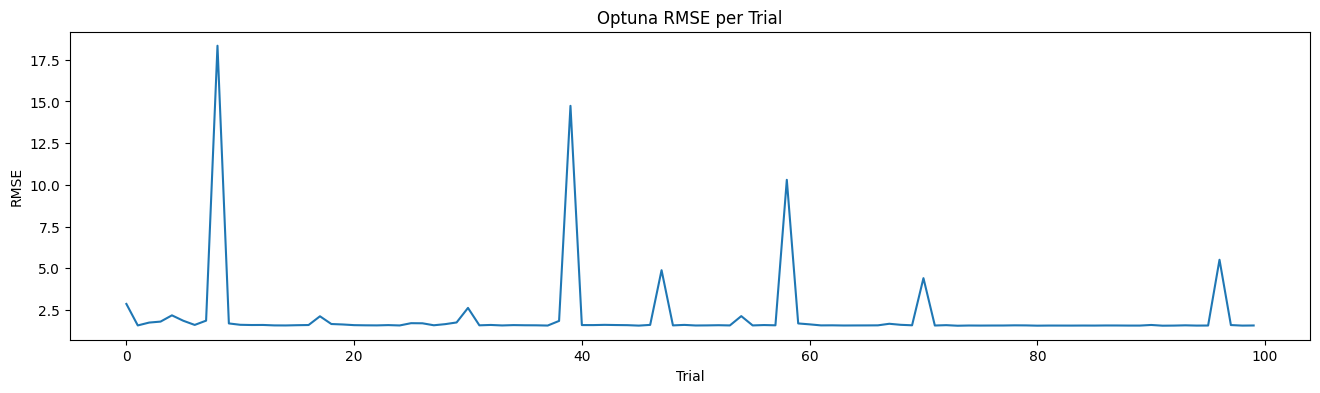

In [14]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [15]:
vis.plot_parallel_coordinate(temp_study)

In [16]:
vis.plot_param_importances(study=temp_study)

In [17]:
completed_trials = studies_per_target['temp_next_2'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_2']

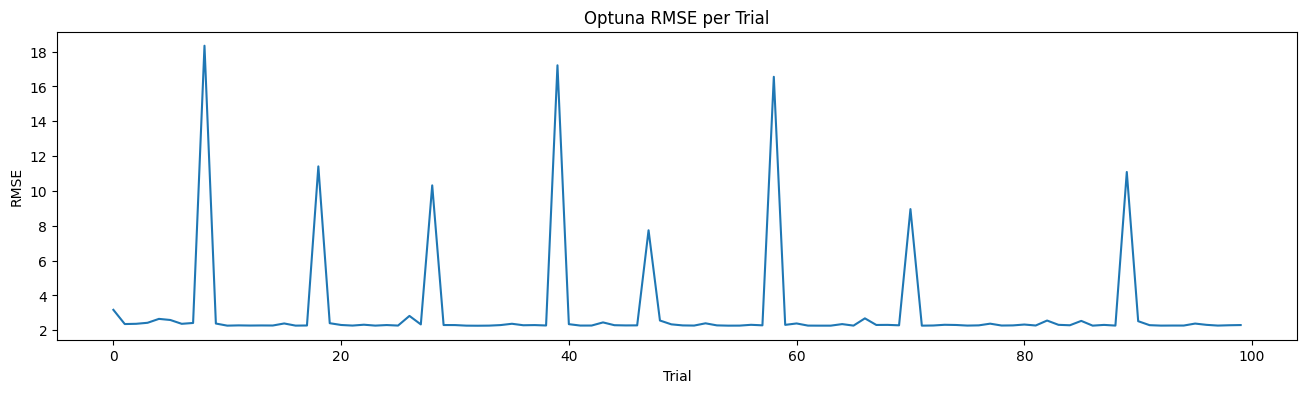

In [18]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [19]:
vis.plot_parallel_coordinate(temp_study)

In [20]:
vis.plot_param_importances(study=temp_study)

In [21]:
completed_trials = studies_per_target['temp_next_3'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_3']

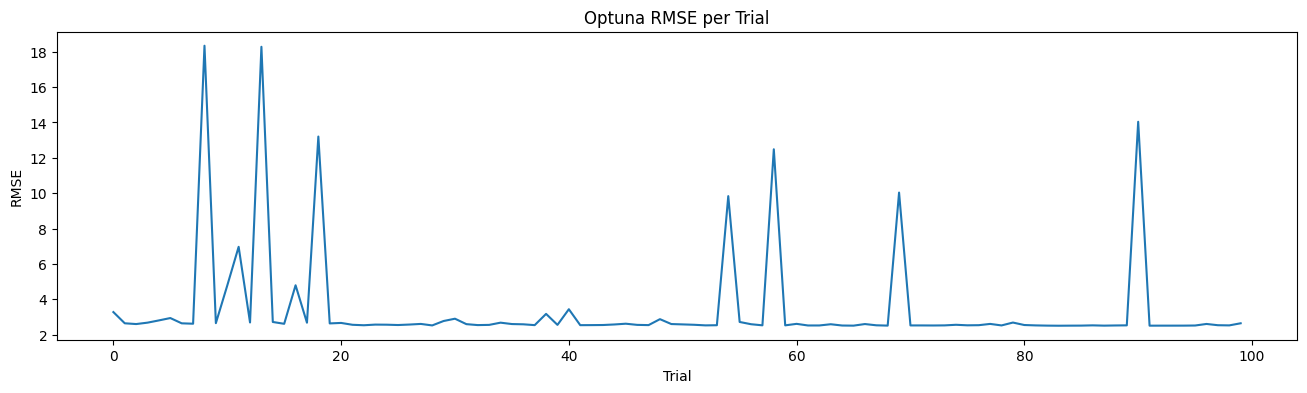

In [22]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [23]:
vis.plot_parallel_coordinate(temp_study)

In [24]:
vis.plot_param_importances(study=temp_study)

In [25]:
completed_trials = studies_per_target['temp_next_4'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_4']

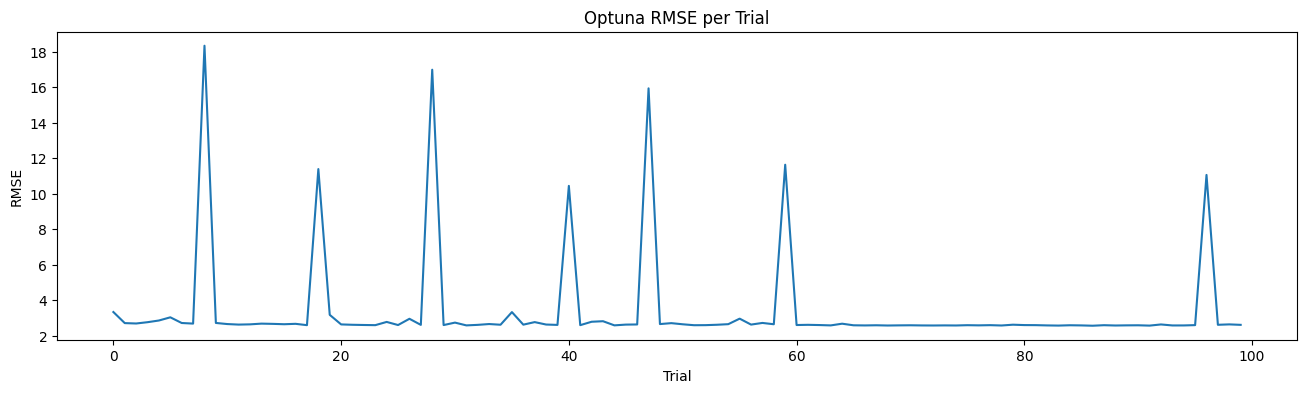

In [26]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [27]:
vis.plot_parallel_coordinate(temp_study)

In [28]:
vis.plot_param_importances(study=temp_study)

In [29]:
completed_trials = studies_per_target['temp_next_5'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_5']

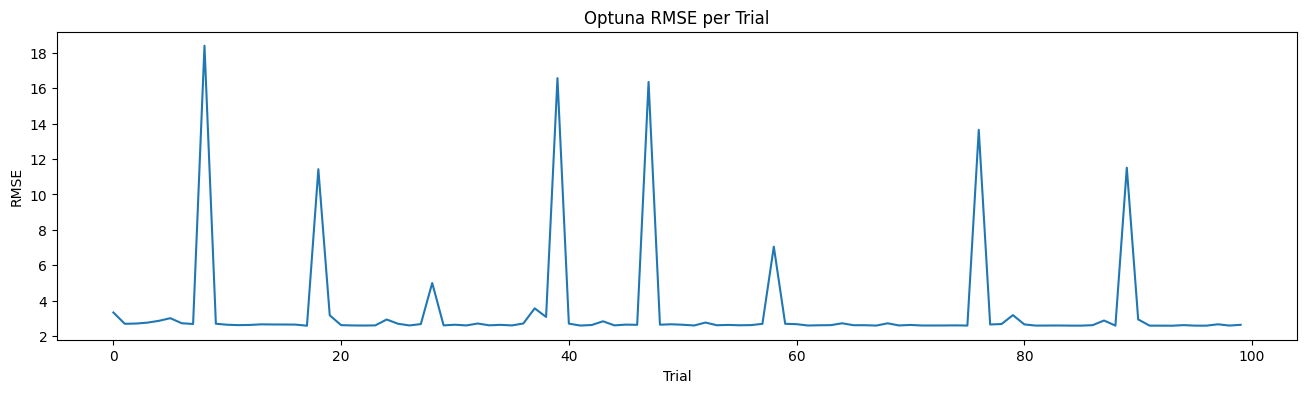

In [43]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [31]:
vis.plot_parallel_coordinate(temp_study)

In [32]:
vis.plot_param_importances(study=temp_study)

### **2.3. Training Final Model with Tuned Hyperparameters on Test Set**

In [10]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
    def __init__(self, models_per_target, complete_pipelines_per_target):
        self.models_per_target = models_per_target
        self.complete_pipelines_per_target = complete_pipelines_per_target
        self.target_names = list(models_per_target.keys())
    
    def predict(self, X):
        predictions = {}
        for target_name, model_info in self.models_per_target.items():
            # Sử dụng complete pipeline của target đó
            pipeline = self.complete_pipelines_per_target[target_name]
            X_processed = pipeline.transform(X)
            X_final = X_processed.iloc[30:]
            
            pred = model_info['model'].predict(X_final)
            predictions[target_name] = pred
        
        return pd.DataFrame(predictions)
    
    def get_params(self, deep=True):
        return {
            "models_per_target": self.models_per_target,
            "complete_pipelines_per_target": self.complete_pipelines_per_target
        }

# Tạo final model với complete pipelines
final_multi_model = CustomMultiOutputRegressor(best_complete_models_per_target, complete_pipelines_per_target)

## === E. Đánh giá final model trên cả TRAIN và TEST ===
print("🔍 EVALUATING FINAL MODEL...")

# Dự đoán trên train và test set
y_pred_train = final_multi_model.predict(X_train)
y_pred_test = final_multi_model.predict(X_test)

# Cutoff y để khớp với predictions (đã bị cutoff 30 dòng trong pipeline)
y_train_cutoff = y_train.iloc[30:]
y_test_cutoff = y_test.iloc[30:]

# Đánh giá
final_train_metrics = evaluate_multi_output(y_train_cutoff, y_pred_train)
final_test_metrics = evaluate_multi_output(y_test_cutoff, y_pred_test)

# Hiển thị kết quả
print("\nFINAL MODEL PERFORMANCE")
print("=" * 60)

print("\nTRAIN SET PERFORMANCE:")
print(f"Samples: {len(y_train_cutoff)}")
print("Average metrics:")
for metric, value in final_train_metrics["average"].items():
    print(f"  {metric}: {value:.4f}")
print('Perday Train Metrics', final_train_metrics['per_day'])

print("\nTEST SET PERFORMANCE:")
print(f"Samples: {len(y_test_cutoff)}") 
print("Average metrics:")
for metric, value in final_test_metrics["average"].items():
    print(f"  {metric}: {value:.4f}")
print('Perday Test Metrics', final_test_metrics['per_day'])


🔍 EVALUATING FINAL MODEL...

FINAL MODEL PERFORMANCE

TRAIN SET PERFORMANCE:
Samples: 2893
Average metrics:
  RMSE: 1.5927
  MAE: 1.2614
  R2: 0.8972
Perday Train Metrics {'RMSE_day_1': 0.8378491236742083, 'MAE_day_1': 0.6514012763398634, 'R2_day_1': 0.9733712105738543, 'RMSE_day_2': 1.6574438164171714, 'MAE_day_2': 1.2925413389896718, 'R2_day_2': 0.8958313149082923, 'RMSE_day_3': 1.6985251873129297, 'MAE_day_3': 1.357378951737257, 'R2_day_3': 0.8906364905707855, 'RMSE_day_4': 1.6406587495625695, 'MAE_day_4': 1.2942609894574402, 'R2_day_4': 0.8979850047557727, 'RMSE_day_5': 2.1291923417984338, 'MAE_day_5': 1.7111714783374494, 'R2_day_5': 0.8282109693591844}

TEST SET PERFORMANCE:
Samples: 697
Average metrics:
  RMSE: 2.1810
  MAE: 1.7229
  R2: 0.8159
Perday Test Metrics {'RMSE_day_1': 1.4629119366593986, 'MAE_day_1': 1.126826935164041, 'R2_day_1': 0.9195260116321596, 'RMSE_day_2': 2.104875607946346, 'MAE_day_2': 1.6604677783107786, 'R2_day_2': 0.83349600792189, 'RMSE_day_3': 2.36897438

In [11]:

## === F. LOG TẤT CẢ KẾT QUẢ LÊN CLEARML ===
print("\n UPLOADING ALL ARTIFACTS TO CLEARML...")

# 1. Best Parameters cho từng target
task_lgbm.upload_artifact("Best Parameters Per Target", best_complete_params_per_target)
print("Uploaded: Best Parameters Per Target")

# 2. Complete Pipelines cho từng target  
task_lgbm.upload_artifact("Complete Pipelines Per Target", complete_pipelines_per_target)
print("Uploaded: Complete Pipelines Per Target")

# 3. Final Models info
models_info = {}
for target_name, model_info in best_complete_models_per_target.items():
    models_info[target_name] = {
        'model_type': type(model_info['model']).__name__,
        'model_params': model_info['model'].get_params(),
        'features_count': X_train.shape[1],
        'pipeline_steps': list(model_info['complete_pipeline'].named_steps.keys()),
        'best_encoding_method': best_complete_params_per_target[target_name].get('encoding_method_condition', 'N/A'),
        'best_n_seasons': best_complete_params_per_target[target_name].get('n_seasons', 'N/A')
    }
task_lgbm.upload_artifact("Final Models Info", models_info)
print("Uploaded: Final Models Info")

# 4. Train Metrics
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)
print("Uploaded: Final Model - Train Metrics")

# 5. Test Metrics
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)  
print("Uploaded: Final Model - Test Metrics")

# 6. Log multioutput model
task_lgbm.upload_artifact("Final MultiOutput Model", final_multi_model)
print(" Uploaded: Final MultiOutput Model")


## === G. Lưu tất cả models ===
print("\n SAVING ALL MODELS...")

lgbm_models_path = r"models/Complete_LGBM_models.pkl"
joblib.dump({
    'models': best_complete_models_per_target,
    'params': best_complete_params_per_target,
    'pipelines': complete_pipelines_per_target,
    'final_multi_model': final_multi_model,
    'train_metrics': final_train_metrics,
    'test_metrics': final_test_metrics
}, lgbm_models_path)

print(f"✅ Models saved to: {lgbm_models_path}")

## === H. Summary Report ===
print(f" MODEL PERFORMANCE SUMMARY:")
print(f"   Train RMSE: {final_train_metrics['average']['RMSE']:.4f}")
print(f"   Test RMSE:  {final_test_metrics['average']['RMSE']:.4f}")

print(f"ARTIFACTS UPLOADED TO CLEARML:")
artifacts_list = [
    "Best Parameters Per Target",
    "Complete Pipelines Per Target", 
    "Final Models Info",
    "Final Model - Train Metrics",
    "Final Model - Test Metrics",
    "Final MultiOutput Model"
]

for artifact in artifacts_list:
    print(f"   ✅ {artifact}")

print(f"Training completed at: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")



 UPLOADING ALL ARTIFACTS TO CLEARML...
Uploaded: Best Parameters Per Target
2025-11-20 15:25:08,739 - clearml - WARNING - JSON serialization of artifact 'Complete Pipelines Per Target' failed, reverting to pickle
Uploaded: Complete Pipelines Per Target
Uploaded: Final Models Info
Uploaded: Final Model - Train Metrics
Uploaded: Final Model - Test Metrics
 Uploaded: Final MultiOutput Model

 SAVING ALL MODELS...
✅ Models saved to: models/Complete_LGBM_models.pkl
 MODEL PERFORMANCE SUMMARY:
   Train RMSE: 1.5927
   Test RMSE:  2.1810
ARTIFACTS UPLOADED TO CLEARML:
   ✅ Best Parameters Per Target
   ✅ Complete Pipelines Per Target
   ✅ Final Models Info
   ✅ Final Model - Train Metrics
   ✅ Final Model - Test Metrics
   ✅ Final MultiOutput Model
Training completed at: 2025-11-20 15:25:17


In [ ]:
task_lgbm.close()

## **3. Experiments & Results**

### **3.1. Experiment Summary Table**

| Experiment | RMSE | R² | MAE | Notes |
| :--- | :--- | :--- | :--- | :--- |
| Base Model | 2.399 | 0.756 | 1.874 | |
| Tuning #1 | 2.188 | 0.815 | 1.728 | 50 trials without pruner |
| Tuning #2 | 2.214 | 0.810 | 1.752 | 50 trials with pruner |
| Tuning #3 | 2.185 | 0.815 | 1.736 | 50 trials with pruner + fix objective |
| Tuning #4 | 2.206 | 0.812 | 1.752 | 100 trials with pruner |
| **Tuning #5 (Best model)** | **2.182** | **0.816** | **1.726** | 100 trials without pruner |
| Tuning #6 | 2.190 | 0.814 | 1.730 | 100 trials without pruner + fix objective |

### **3.2. Best model performance**


In [4]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
    def __init__(self, models_per_target, complete_pipelines_per_target):
        self.models_per_target = models_per_target
        self.complete_pipelines_per_target = complete_pipelines_per_target
        self.target_names = list(models_per_target.keys())
    
    def predict(self, X):
        predictions = {}
        for target_name, model_info in self.models_per_target.items():
            # Sử dụng complete pipeline của target đó
            pipeline = self.complete_pipelines_per_target[target_name]
            X_processed = pipeline.transform(X)
            X_final = X_processed.iloc[30:]
            
            pred = model_info['model'].predict(X_final)
            predictions[target_name] = pred
        
        return pd.DataFrame(predictions)
    
    def get_params(self, deep=True):
        return {
            "models_per_target": self.models_per_target,
            "complete_pipelines_per_target": self.complete_pipelines_per_target
        }



In [5]:
df, train_df, test_df, X_train, y_train, X_test, y_test = dp.prepare_data()

Step 1: Load Raw Data
→ Initial data shape: (3660, 33)

Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
Step 2: Basic Preprocessing
→ Data shape after removing redundant columns: (3660, 28)

Step 3: Split Train/Test Sets (80/20)
→ Train shape: (2928, 28)
→ Test  shape: (732, 28)

Step 4: Create Multi-Target Variables
→ Created targets: ['temp_next_1', 'temp_next_2', 'temp_next_3', 'temp_next_4', 'temp_next_5']
→ Multi-target creation completed successfully.

Step 5: Split Features (X) and Targets (y)
→ X_train shape: (2923, 28)
→ y_train shape: (2923, 5)
→ X_test  shape: (727, 28)
→ y_test  shape: (727, 5)


In [ ]:
import pandas as pd
import numpy as np
import onnxruntime as rt
import joblib

# --- Load pipeline và ONNX model ---
pipeline_path = "models/Complete_LGBM_models.pkl"
saved_data = joblib.load(pipeline_path)
pipelines_per_target = saved_data['pipelines']

# --- Dùng ONNX cho từng target ---
predictions = {}
for target_name in pipelines_per_target.keys():
    print(f"Predicting for target: {target_name}")
    
    # Load ONNX model
    onnx_path = f"models/lgbm_model_{target_name}.onnx"
    sess = rt.InferenceSession(onnx_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    # Transform X_test
    pipeline = pipelines_per_target[target_name]
    X_test_processed = pipeline.transform(X_test) # Mỗi target sẽ lấy X_input chung từ dataprepare và transform thành X_processed riêng

    # Cutoff 30 rows
    X_test_final = X_test_processed.iloc[30:].to_numpy().astype(np.float32)

    # Predict
    y_pred = sess.run([output_name], {input_name: X_test_final})

    # FIX: convert from (n,1) → (n,)
    predictions[target_name] = y_pred[0].ravel()

# Create DataFrame
y_pred_df = pd.DataFrame(predictions, index=y_test.iloc[30:].index)
print(y_pred_df.head())



Predicting for target: temp_next_1
Predicting for target: temp_next_2
Predicting for target: temp_next_3
Predicting for target: temp_next_4
Predicting for target: temp_next_5
            temp_next_1  temp_next_2  temp_next_3  temp_next_4  temp_next_5
datetime                                                                   
2023-10-26    27.303082    26.050171    26.282063    24.679249    24.587860
2023-10-27    26.712633    25.880283    26.592596    24.543802    24.768389
2023-10-28    25.018110    25.511837    24.977118    24.440533    24.903111
2023-10-29    23.943991    23.958872    24.283852    24.603304    24.942799
2023-10-30    25.084484    24.736425    25.022707    24.678123    25.032589


In [16]:
import seaborn as sns
# Load model
lgbm_models_path = r"models/Complete_LGBM_models.pkl" 
saved_data = joblib.load(lgbm_models_path)

# Lấy final_multi_model
final_multi_model = saved_data['final_multi_model']

# Dự đoán
y_pred_test = final_multi_model.predict(X_test)
y_pred_train = final_multi_model.predict(X_train)

# Cutoff y để khớp với predictions 
y_test_cutoff = y_test.iloc[30:]
y_train_cutoff = y_train.iloc[30:]

# Đánh giá
final_test_metrics = evaluate_multi_output(y_test_cutoff, y_pred_test)
final_train_metrics = evaluate_multi_output(y_train_cutoff, y_pred_train)

print("LGBM Final Model - Test metrics (average):", final_test_metrics["average"])
print("LGBM Final Model - Test metrics (perday):", final_test_metrics["per_day"])
print()
print("LGBM Final Model - Train metrics (average):", final_train_metrics["average"])
print("LGBM Final Model - Train metrics (perday):", final_train_metrics["per_day"])

LGBM Final Model - Test metrics (average): {'RMSE': 2.1809553308390663, 'MAE': 1.7228728931314556, 'R2': 0.815858674739727}
LGBM Final Model - Test metrics (perday): {'RMSE_day_1': 1.4629119366593986, 'MAE_day_1': 1.126826935164041, 'R2_day_1': 0.9195260116321596, 'RMSE_day_2': 2.104875607946346, 'MAE_day_2': 1.6604677783107786, 'R2_day_2': 0.83349600792189, 'RMSE_day_3': 2.3689743893595048, 'MAE_day_3': 1.881399117551421, 'R2_day_3': 0.7893849100489958, 'RMSE_day_4': 2.47659354600327, 'MAE_day_4': 1.9575063429916173, 'R2_day_4': 0.7698244146091476, 'RMSE_day_5': 2.4914211742268115, 'MAE_day_5': 1.9881642916394204, 'R2_day_5': 0.7670620294864413}

LGBM Final Model - Train metrics (average): {'RMSE': 1.5927338437530625, 'MAE': 1.2613508069723363, 'R2': 0.8972069980335778}
LGBM Final Model - Train metrics (perday): {'RMSE_day_1': 0.8378491236742083, 'MAE_day_1': 0.6514012763398634, 'R2_day_1': 0.9733712105738543, 'RMSE_day_2': 1.6574438164171714, 'MAE_day_2': 1.2925413389896718, 'R2_day_

🔍 ANALYZING FEATURE IMPORTANCE FOR ALL TARGETS

📊 FEATURE IMPORTANCE FOR: temp_next_1
--------------------------------------------------
Top 10 quan trọng nhất cho temp_next_1:
  thermal_index: 523.0000
  wind_variability: 185.0000
  vis_humidity_index: 181.0000
  winddir_cos: 129.0000
  moisture_index: 119.0000
  rain_intensity: 104.0000
  winddir_sin: 99.0000
  temp_range: 91.0000
  numeric_wind_category: 90.0000
  dew_spread: 70.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


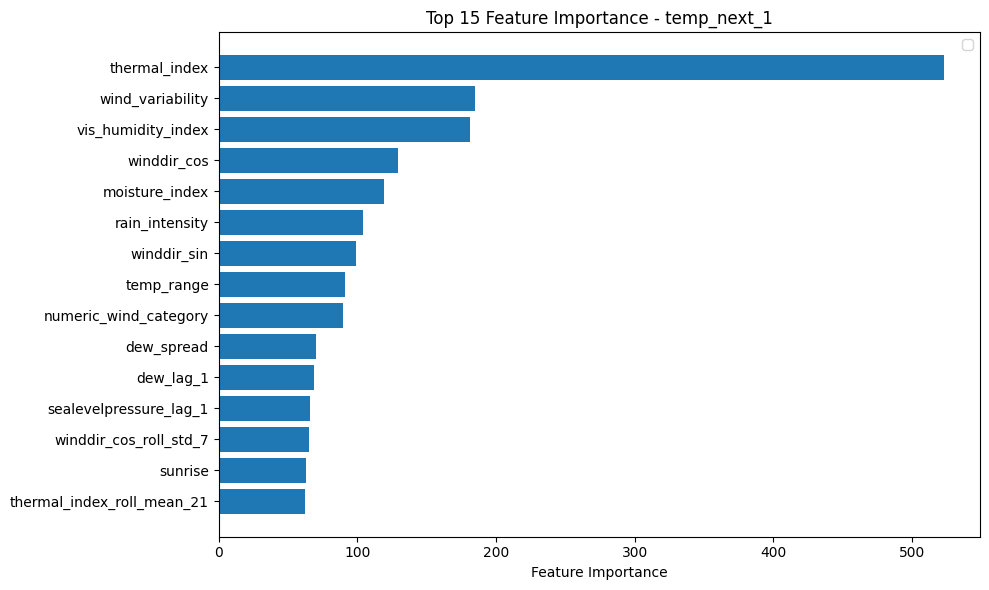


📊 FEATURE IMPORTANCE FOR: temp_next_2
--------------------------------------------------
Top 10 quan trọng nhất cho temp_next_2:
  thermal_index: 514.0000
  winddir_cos: 267.0000
  sunrise: 140.0000
  wind_variability: 137.0000
  vis_humidity_index: 131.0000
  sunrise_cos: 115.0000
  thermal_index_roll_mean_21: 105.0000
  numeric_wind_category: 99.0000
  moisture_index: 91.0000
  uvindex_roll_mean_21: 77.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


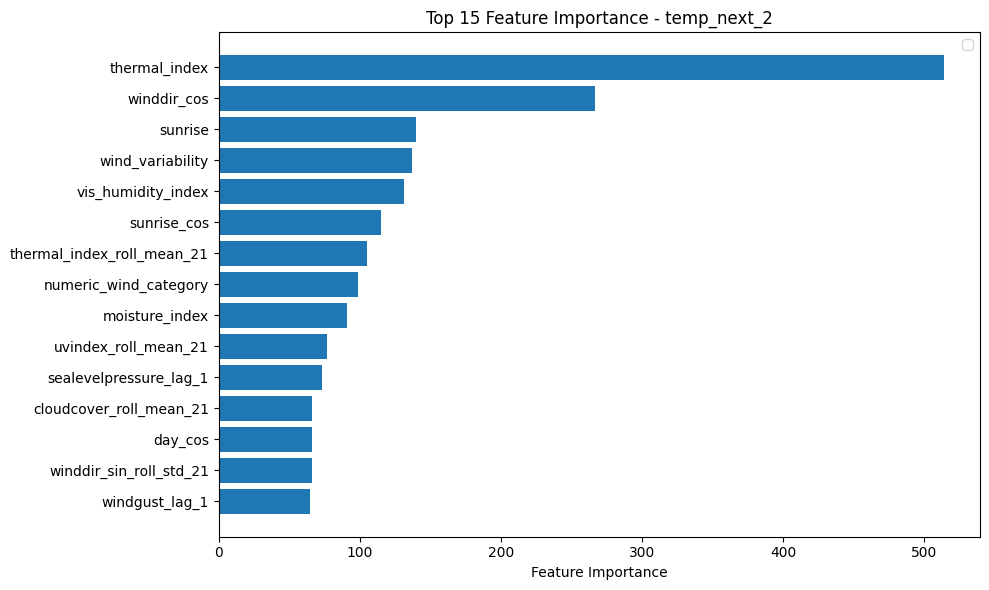


📊 FEATURE IMPORTANCE FOR: temp_next_3
--------------------------------------------------
Top 10 quan trọng nhất cho temp_next_3:
  thermal_index: 412.0000
  uvindex_roll_mean_21: 307.0000
  winddir_cos: 291.0000
  sunrise_cos: 281.0000
  winddir_sin_roll_std_21: 246.0000
  season: 242.0000
  sunrise_sin: 236.0000
  sunrise: 208.0000
  sealevelpressure_lag_1: 203.0000
  uvindex_roll_std_21: 195.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


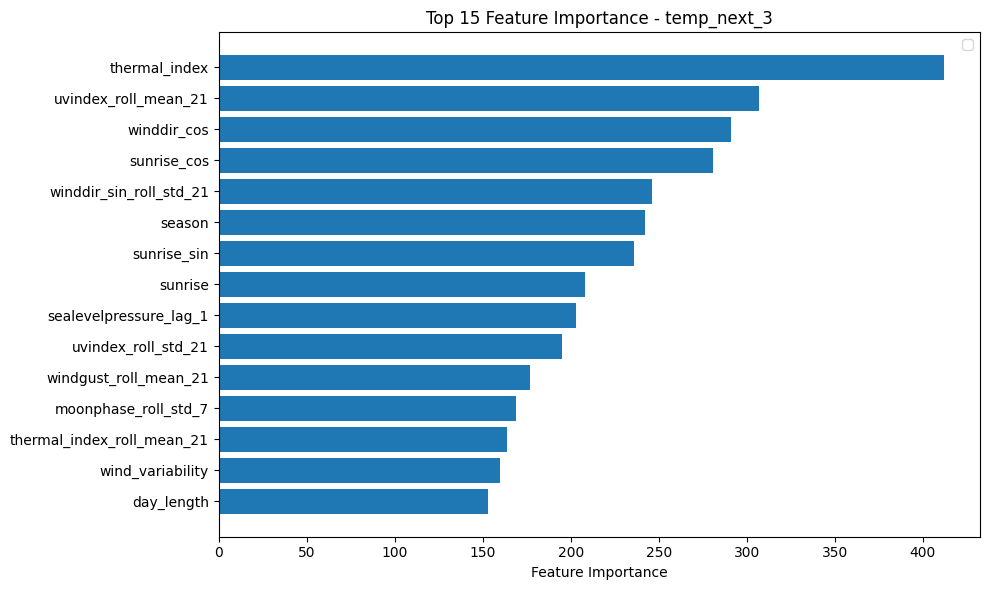


📊 FEATURE IMPORTANCE FOR: temp_next_4
--------------------------------------------------
Top 10 quan trọng nhất cho temp_next_4:
  winddir_sin_roll_std_21: 715.0000
  sunrise_cos: 530.0000
  thermal_index_roll_mean_21: 454.0000
  uvindex_roll_mean_21: 450.0000
  windgust_roll_mean_21: 407.0000
  uvindex_roll_std_21: 386.0000
  precip_roll_mean_21: 384.0000
  day_length: 367.0000
  season: 352.0000
  dew_roll_std_14: 342.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


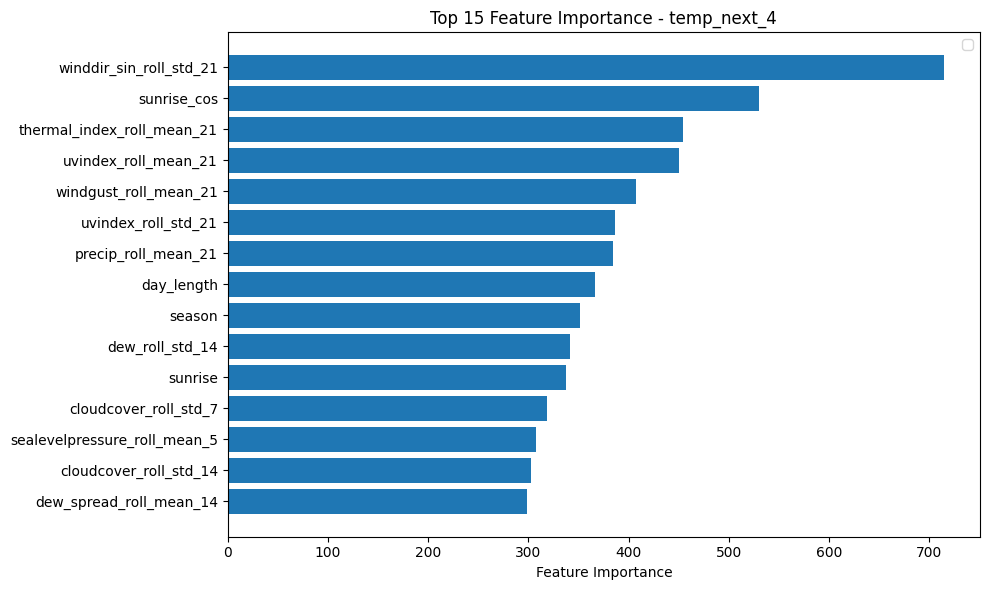


📊 FEATURE IMPORTANCE FOR: temp_next_5
--------------------------------------------------
Top 10 quan trọng nhất cho temp_next_5:
  sunrise: 166.0000
  season: 106.0000
  uvindex_roll_mean_21: 95.0000
  winddir_sin_roll_std_21: 79.0000
  sunrise_cos: 71.0000
  day_cos: 67.0000
  day_length: 66.0000
  sunrise_sin: 64.0000
  uvindex_roll_std_21: 63.0000
  thermal_index_roll_mean_21: 52.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


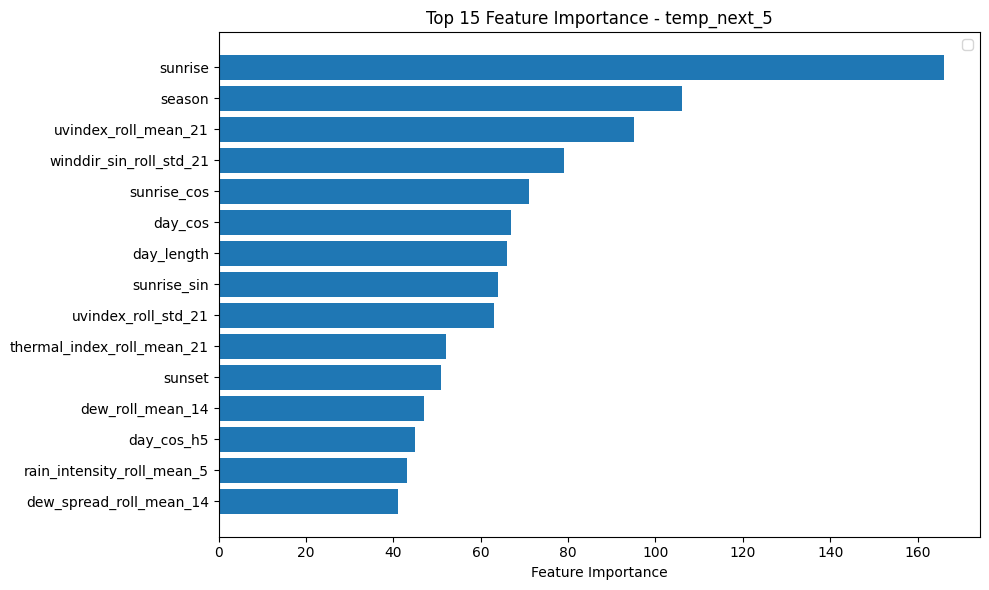


🔬 COMPARING FEATURE IMPORTANCE ACROSS TARGETS

📈 MOST IMPORTANT FEATURES ACROSS ALL TARGETS:
--------------------------------------------------
Top 15 features quan trọng nhất (tổng hợp tất cả targets):
  thermal_index: 1680.0000
  winddir_sin_roll_std_21: 1138.0000
  sunrise_cos: 1035.0000
  uvindex_roll_mean_21: 971.0000
  sunrise: 915.0000
  thermal_index_roll_mean_21: 837.0000
  winddir_cos: 798.0000
  season: 749.0000
  uvindex_roll_std_21: 730.0000
  day_length: 686.0000
  windgust_roll_mean_21: 678.0000
  sunrise_sin: 646.0000
  precip_roll_mean_21: 614.0000
  sealevelpressure_lag_1: 588.0000
  day_cos: 568.0000

🏷️ FEATURE CATEGORY ANALYSIS

Feature Importance by Category:
                            temp_next_1  temp_next_2  temp_next_3  \
Wind Features                      1771         1850         3649   
Atmospheric Features               1265         1260         3330   
Temperature Features               1706         1520         2559   
Temporal Features                

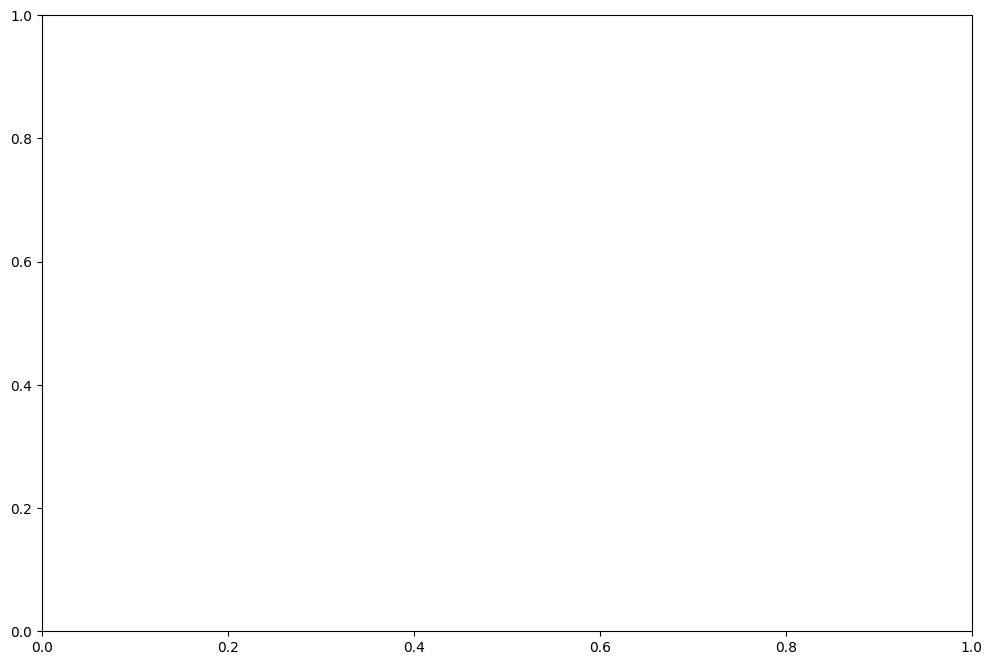

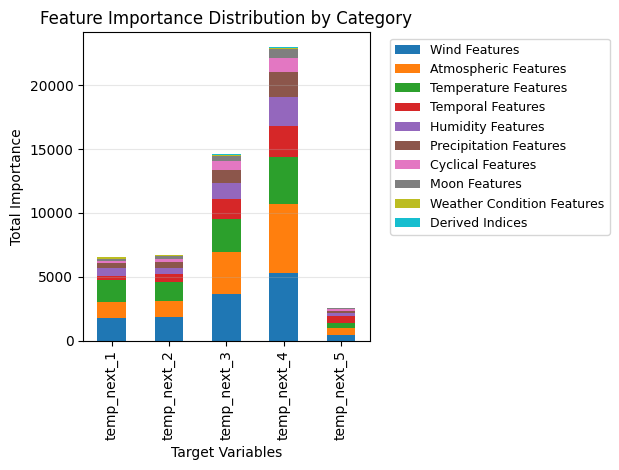


📊 TỔNG QUAN PHÂN BỐ FEATURE IMPORTANCE:
--------------------------------------------------
Wind Features                 : 12987.00 (24.3%)
Atmospheric Features          : 11853.00 (22.2%)
Temperature Features          : 9820.00 (18.4%)
Temporal Features             : 5467.00 (10.2%)
Humidity Features             : 4759.00 (8.9%)
Precipitation Features        : 4071.00 (7.6%)
Cyclical Features             : 2349.00 (4.4%)
Moon Features                 : 1520.00 (2.8%)
Weather Condition Features    : 352.00 (0.7%)
Derived Indices               : 266.00 (0.5%)

✅ FEATURE IMPORTANCE ANALYSIS COMPLETED!


In [22]:
# Load model
lgbm_models_path = r"models/Complete_LGBM_models.pkl" 
saved_data = joblib.load(lgbm_models_path)

# Lấy final_multi_model và các thông tin khác
final_multi_model = saved_data['final_multi_model']
best_complete_models_per_target = saved_data['models']
complete_pipelines_per_target = saved_data['pipelines']

# === PHÂN TÍCH FEATURE IMPORTANCE CHO TỪNG TARGET ===
print("🔍 ANALYZING FEATURE IMPORTANCE FOR ALL TARGETS")
print("=" * 60)

for target_name, model_info in best_complete_models_per_target.items():
    print(f"\n📊 FEATURE IMPORTANCE FOR: {target_name}")
    print("-" * 50)
    
    # Lấy model và pipeline
    model = model_info['model']
    pipeline = model_info['complete_pipeline']
    
    # Lấy feature names sau khi transform
    try:
        # Transform một mẫu để lấy feature names
        sample_processed = pipeline.transform(X_train.head(50))
        feature_names = sample_processed.columns.tolist()
        
        # Lấy feature importance từ model
        importance_scores = model.feature_importances_
        
        # Tạo DataFrame để hiển thị
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        }).sort_values('importance', ascending=False)
        
        # Hiển thị top 10 features quan trọng nhất
        print(f"Top 10 quan trọng nhất cho {target_name}:")
        for i, row in importance_df.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
            
        # Vẽ biểu đồ feature importance
        plt.figure(figsize=(10, 6))
        top_features = importance_df.head(15)
        plt.barh(top_features['feature'], top_features['importance'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importance - {target_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        # Log lên ClearML
        logger_lgbm.report_table(
            title=f"Feature Importance - {target_name}",
            series="top_features",
            iteration=0,
            table_plot=importance_df.head(15)
        )
        
    except Exception as e:
        print(f"Error analyzing feature importance for {target_name}: {e}")
        continue

# === SO SÁNH FEATURE IMPORTANCE GIỮA CÁC TARGET ===
print("\n🔬 COMPARING FEATURE IMPORTANCE ACROSS TARGETS")
print("=" * 60)

# Tạo DataFrame tổng hợp feature importance cho tất cả targets
all_importances = {}

for target_name, model_info in best_complete_models_per_target.items():
    model = model_info['model']
    pipeline = model_info['complete_pipeline']
    
    try:
        # Lấy feature names
        sample_processed = pipeline.transform(X_train.head(50))
        feature_names = sample_processed.columns.tolist()
        
        # Lấy importance scores
        importance_scores = model.feature_importances_
        
        # Lưu vào dictionary
        all_importances[target_name] = dict(zip(feature_names, importance_scores))
        
    except Exception as e:
        print(f"Error processing {target_name}: {e}")
        continue

# Tạo DataFrame so sánh
comparison_df = pd.DataFrame(all_importances).fillna(0)

# Hiển thị các features quan trọng nhất trên tất cả targets
print("\n📈 MOST IMPORTANT FEATURES ACROSS ALL TARGETS:")
print("-" * 50)

# Tính tổng importance cho mỗi feature across all targets
total_importance = comparison_df.sum(axis=1)
top_overall_features = total_importance.sort_values(ascending=False).head(15)

print("Top 15 features quan trọng nhất (tổng hợp tất cả targets):")
for feature, importance in top_overall_features.items():
    print(f"  {feature}: {importance:.4f}")

# === PHÂN TÍCH THEO NHÓM FEATURES ===
print("\n🏷️ FEATURE CATEGORY ANALYSIS")
print("=" * 60)

# Phân loại features theo nhóm đơn giản
def categorize_feature(feature_name):
    feature_name = feature_name.lower()
    
    # Temporal Features (Time-based) - THÊM SEASON VÀO ĐÂY
    if any(time_keyword in feature_name for time_keyword in ['month', 'weekday', 'day_of_year', 'is_weekend', 
                                                           'hour', 'sunrise', 'sunset', 'day_length', 'season']):
        return 'Temporal Features'
    
    # Temperature Features
    elif any(temp_keyword in feature_name for temp_keyword in ['temp', 'thermal_index', 'temp_range', 'dew_spread', 
                                                             'feelslike', 'heat_index', 'wind_chill']):
        return 'Temperature Features'
    
    # Wind Features
    elif any(wind_keyword in feature_name for wind_keyword in ['wind', 'winddir', 'windgust']):
        return 'Wind Features'
    
    # Humidity Features
    elif any(humidity_keyword in feature_name for humidity_keyword in ['humidity', 'dew']):
        return 'Humidity Features'
    
    # Atmospheric Features
    elif any(atmos_keyword in feature_name for atmos_keyword in ['cloudcover', 'visibility', 'sealevelpressure', 
                                                               'uvindex', 'solarradiation', 'solarenergy']):
        return 'Atmospheric Features'
    
    # Precipitation Features
    elif any(precip_keyword in feature_name for precip_keyword in ['precip', 'precipcover', 'rain']):
        return 'Precipitation Features'
    
    # Moon Features
    elif 'moonphase' in feature_name:
        return 'Moon Features'
    
    # Weather Condition Features
    elif any(condition_keyword in feature_name for condition_keyword in ['condition', 'humid_foggy_day', 'moisture_index']):
        return 'Weather Condition Features'
    
    # Derived Indices
    elif any(index_keyword in feature_name for index_keyword in ['index', 'variability', 'intensity', 'spread']):
        return 'Derived Indices'
    
    # Lag Features
    elif 'lag' in feature_name:
        # Xác định loại của lag feature dựa trên base feature
        base_feature = feature_name.replace('_lag_', ' ').split(' ')[0]
        return f'Lag Features ({categorize_feature(base_feature)})'
    
    # Rolling Features
    elif 'roll' in feature_name:
        # Xác định loại của rolling feature dựa trên base feature
        base_feature = feature_name.replace('_roll_', ' ').split(' ')[0]
        return f'Rolling Features ({categorize_feature(base_feature)})'
    
    else:
        # Nhóm các features không xác định vào nhóm chính gần nhất
        if any(keyword in feature_name for keyword in ['sin', 'cos']):
            return 'Cyclical Features'
        else:
            return 'Other Features'

# Phân tích importance theo nhóm cho từng target
category_analysis = {}

for target_name, importances_dict in all_importances.items():
    category_sums = {}
    for feature, importance in importances_dict.items():
        category = categorize_feature(feature)
        category_sums[category] = category_sums.get(category, 0) + importance
    
    category_analysis[target_name] = category_sums

# Hiển thị phân tích theo nhóm
category_df = pd.DataFrame(category_analysis).fillna(0)

# Sắp xếp các category theo tổng importance giảm dần
category_totals = category_df.sum(axis=1).sort_values(ascending=False)
category_df = category_df.loc[category_totals.index]

print("\nFeature Importance by Category:")
print(category_df.round(4))

# Vẽ biểu đồ phân bố importance theo nhóm (CHỈ 1 FIGURE)
plt.figure(figsize=(12, 8))
category_df.T.plot(kind='bar', stacked=True)
plt.title('Feature Importance Distribution by Category')
plt.xlabel('Target Variables')
plt.ylabel('Total Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Thống kê tổng quan
print(f"\n📊 TỔNG QUAN PHÂN BỐ FEATURE IMPORTANCE:")
print("-" * 50)
total_importance_by_category = category_df.sum(axis=1)
for category, importance in total_importance_by_category.items():
    percentage = (importance / total_importance_by_category.sum()) * 100
    print(f"{category:<30}: {importance:.2f} ({percentage:.1f}%)")

print("\n✅ FEATURE IMPORTANCE ANALYSIS COMPLETED!")

📊 AVERAGE FEATURE IMPORTANCE ACROSS 5 TARGETS


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



📈 TOP 20 FEATURES QUAN TRỌNG NHẤT (TRUNG BÌNH 5 TARGETS):
----------------------------------------------------------------------
Feature                                  Avg Importance  Std       
----------------------------------------------------------------------
thermal_index                            336.0000        191.4586  
winddir_sin_roll_std_21                  227.6000        254.6972  
sunrise_cos                              207.0000        181.8384  
uvindex_roll_mean_21                     194.2000        158.0499  
sunrise                                  183.0000        90.7612   
thermal_index_roll_mean_21               167.4000        148.6413  
winddir_cos                              159.6000        104.9030  
season                                   149.8000        128.7515  
uvindex_roll_std_21                      146.0000        132.8428  
day_length                               137.2000        121.1138  
windgust_roll_mean_21                    135.6000  

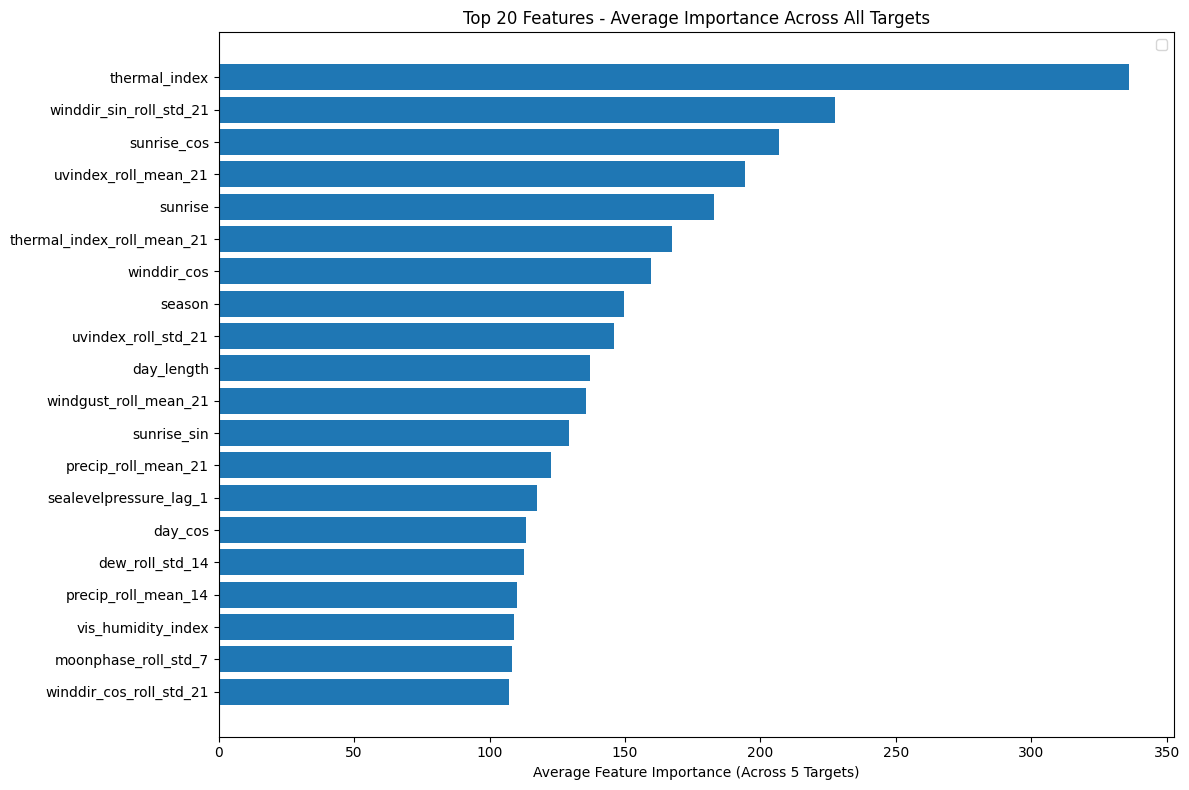

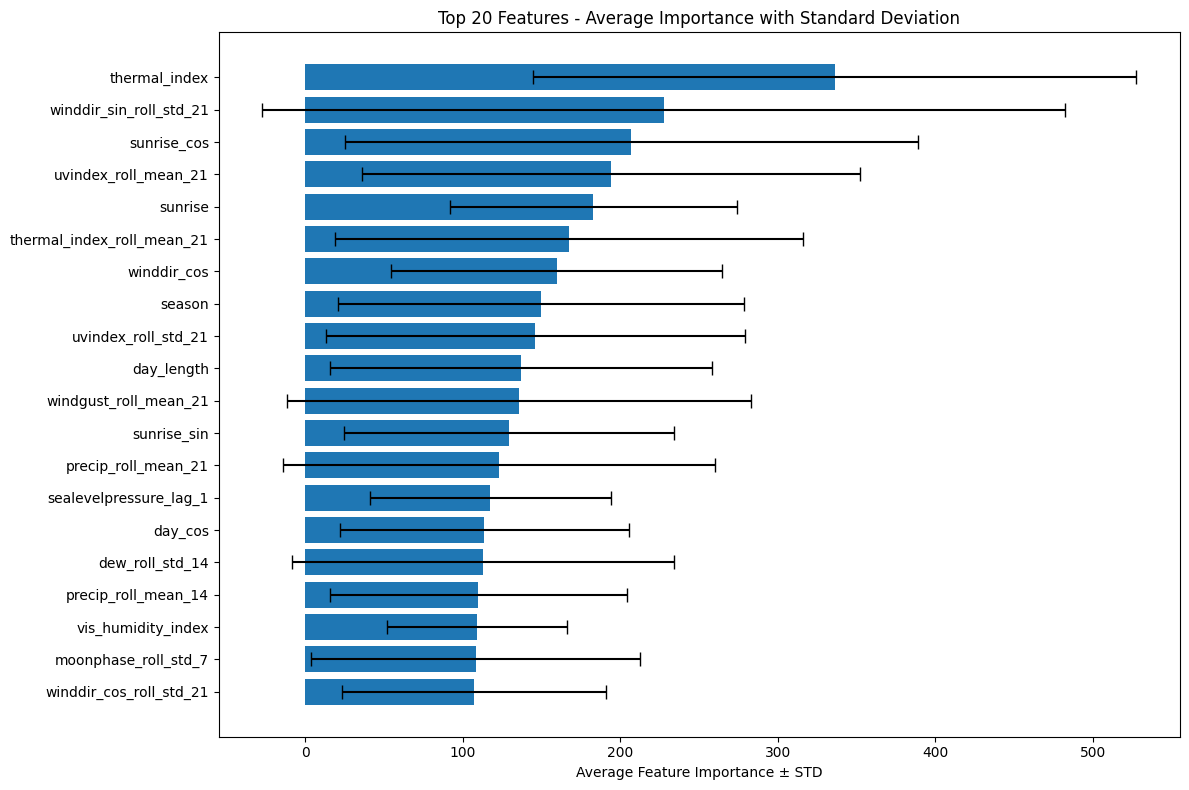


🏷️ FEATURE CATEGORY DISTRIBUTION (AVERAGE):
--------------------------------------------------
Wind Features            : 2623.1000 (24.5%)
Atmospheric Features     : 2370.6000 (22.1%)
Temperature Features     : 1964.0000 (18.3%)
Temporal Features        : 1093.4000 (10.2%)
Humidity Features        : 951.8000 (8.9%)
Precipitation Features   : 814.2000 (7.6%)
Cyclical Features        : 469.8000 (4.4%)
Moon Features            : 304.0000 (2.8%)
Weather Condition Features: 72.0333 (0.7%)
Derived Indices          : 53.2000 (0.5%)

🔍 CHI TIẾT FEATURES THEO TỪNG CATEGORY:

📂 Wind Features (Total Importance: 2623.1000)
------------------------------------------------------------
   1. winddir_sin_roll_std_21                       227.6000
   2. winddir_cos                                   159.6000
   3. windgust_roll_mean_21                         135.6000
   4. winddir_cos_roll_std_21                       107.0000
   5. wind_variability                              103.4000
   6. windgus

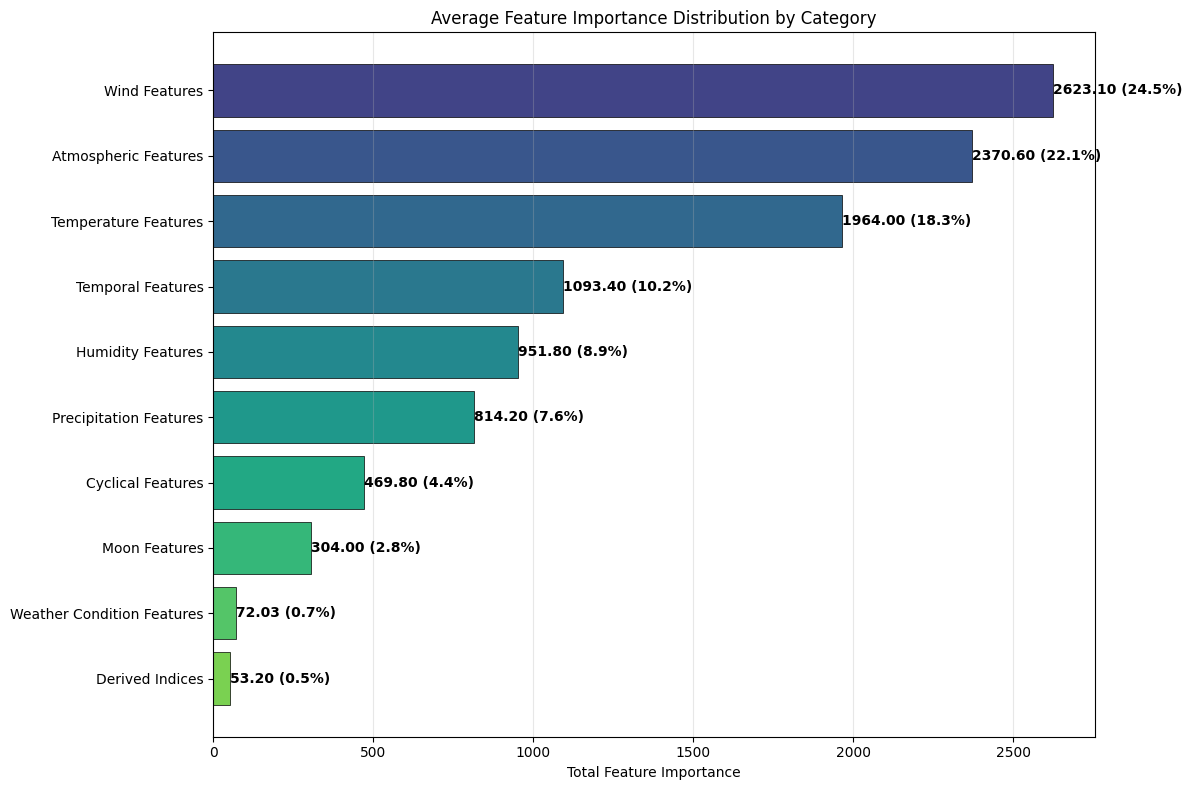


✅ AVERAGE FEATURE IMPORTANCE ANALYSIS COMPLETED!
📋 Total features analyzed: 270
🎯 Top 3 most important features on average:
   1. thermal_index: 336.0000
   2. winddir_sin_roll_std_21: 227.6000
   3. sunrise_cos: 207.0000


In [24]:
import seaborn as sns

print("📊 AVERAGE FEATURE IMPORTANCE ACROSS 5 TARGETS")
print("=" * 60)

# Dictionary để lưu tất cả feature importance
all_features_importance = {}

# Thu thập feature importance từ tất cả targets
for target_name, model_info in best_complete_models_per_target.items():
    model = model_info['model']
    pipeline = model_info['complete_pipeline']
    
    # Lấy feature names
    sample_processed = pipeline.transform(X_train.head(50))
    feature_names = sample_processed.columns.tolist()
    
    # Lấy importance scores
    importance_scores = model.feature_importances_
    
    # Lưu vào dictionary
    for feature, importance in zip(feature_names, importance_scores):
        if feature not in all_features_importance:
            all_features_importance[feature] = []
        all_features_importance[feature].append(importance)

# Tính average importance cho mỗi feature
average_importance = {}
for feature, importances in all_features_importance.items():
    average_importance[feature] = np.mean(importances)

# Sắp xếp theo importance giảm dần
sorted_avg_importance = sorted(average_importance.items(), key=lambda x: x[1], reverse=True)

# Hiển thị kết quả
print(f"\n📈 TOP 20 FEATURES QUAN TRỌNG NHẤT (TRUNG BÌNH 5 TARGETS):")
print("-" * 70)
print(f"{'Feature':<40} {'Avg Importance':<15} {'Std':<10}")
print("-" * 70)

for feature, avg_imp in sorted_avg_importance[:20]:
    std_imp = np.std(all_features_importance[feature])
    print(f"{feature:<40} {avg_imp:<15.4f} {std_imp:<10.4f}")

# Tạo DataFrame cho dễ xử lý
avg_importance_df = pd.DataFrame([
    {
        'feature': feature,
        'avg_importance': avg_imp,
        'std_importance': np.std(all_features_importance[feature]),
        'min_importance': np.min(all_features_importance[feature]),
        'max_importance': np.max(all_features_importance[feature])
    }
    for feature, avg_imp in sorted_avg_importance
])

# Vẽ biểu đồ average feature importance
plt.figure(figsize=(12, 8))
top_20_avg = avg_importance_df.head(20)
plt.barh(top_20_avg['feature'], top_20_avg['avg_importance'])
plt.xlabel('Average Feature Importance (Across 5 Targets)')
plt.title('Top 20 Features - Average Importance Across All Targets')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Vẽ biểu đồ với error bars (std)
plt.figure(figsize=(12, 8))
plt.barh(top_20_avg['feature'], top_20_avg['avg_importance'], 
         xerr=top_20_avg['std_importance'], capsize=5)
plt.xlabel('Average Feature Importance ± STD')
plt.title('Top 20 Features - Average Importance with Standard Deviation')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Phân tích theo nhóm features (trung bình) - CẬP NHẬT PHÂN LOẠI
def categorize_feature(feature_name):
    feature_name = feature_name.lower()
    
    # Temporal Features (Time-based)
    if any(time_keyword in feature_name for time_keyword in ['month', 'weekday', 'day_of_year', 'is_weekend', 
                                                           'hour', 'sunrise', 'sunset', 'day_length', 'season']):
        return 'Temporal Features'
    
    # Temperature Features
    elif any(temp_keyword in feature_name for temp_keyword in ['temp', 'thermal_index', 'temp_range', 'dew_spread', 
                                                             'feelslike', 'heat_index', 'wind_chill']):
        return 'Temperature Features'
    
    # Wind Features
    elif any(wind_keyword in feature_name for wind_keyword in ['wind', 'winddir', 'windgust']):
        return 'Wind Features'
    
    # Humidity Features
    elif any(humidity_keyword in feature_name for humidity_keyword in ['humidity', 'dew']):
        return 'Humidity Features'
    
    # Atmospheric Features
    elif any(atmos_keyword in feature_name for atmos_keyword in ['cloudcover', 'visibility', 'sealevelpressure', 
                                                               'uvindex', 'solarradiation', 'solarenergy']):
        return 'Atmospheric Features'
    
    # Precipitation Features
    elif any(precip_keyword in feature_name for precip_keyword in ['precip', 'precipcover', 'rain']):
        return 'Precipitation Features'
    
    # Moon Features
    elif 'moonphase' in feature_name:
        return 'Moon Features'
    
    # Weather Condition Features
    elif any(condition_keyword in feature_name for condition_keyword in ['condition', 'humid_foggy_day', 'moisture_index']):
        return 'Weather Condition Features'
    
    # Derived Indices
    elif any(index_keyword in feature_name for index_keyword in ['index', 'variability', 'intensity', 'spread']):
        return 'Derived Indices'
    
    # Lag Features
    elif 'lag' in feature_name:
        return 'Lag Features'
    
    # Rolling Features
    elif 'roll' in feature_name:
        return 'Rolling Features'
    
    else:
        # Nhóm các features không xác định
        if any(keyword in feature_name for keyword in ['sin', 'cos']):
            return 'Cyclical Features'
        else:
            return 'Other Features'

# Tính tổng importance theo nhóm và lưu danh sách features trong mỗi category
category_totals = {}
category_features = {}  # Dictionary mới để lưu features trong mỗi category

for feature, avg_imp in average_importance.items():
    category = categorize_feature(feature)
    category_totals[category] = category_totals.get(category, 0) + avg_imp
    
    # Lưu feature vào category tương ứng
    if category not in category_features:
        category_features[category] = []
    category_features[category].append((feature, avg_imp))

# Hiển thị phân bố theo nhóm
print(f"\n🏷️ FEATURE CATEGORY DISTRIBUTION (AVERAGE):")
print("-" * 50)
for category, total_imp in sorted(category_totals.items(), key=lambda x: x[1], reverse=True):
    percentage = (total_imp / sum(category_totals.values())) * 100
    print(f"{category:<25}: {total_imp:.4f} ({percentage:.1f}%)")

# HIỂN THỊ CHI TIẾT FEATURES TRONG MỖI CATEGORY
print(f"\n🔍 CHI TIẾT FEATURES THEO TỪNG CATEGORY:")
print("=" * 80)

for category, total_imp in sorted(category_totals.items(), key=lambda x: x[1], reverse=True):
    print(f"\n📂 {category} (Total Importance: {total_imp:.4f})")
    print("-" * 60)
    
    # Lấy features trong category này và sắp xếp theo importance
    features_in_category = sorted(category_features[category], key=lambda x: x[1], reverse=True)
    
    # Chỉ hiển thị top 10 features quan trọng nhất trong mỗi category
    for i, (feature, imp) in enumerate(features_in_category[:10]):
        print(f"  {i+1:2d}. {feature:<45} {imp:.4f}")
    
    # Thông tin tổng số features trong category
    total_features = len(features_in_category)
    if total_features > 10:
        print(f"  ... và {total_features - 10} features khác")
    
    print(f"  Tổng số features: {total_features}")

# Vẽ biểu đồ phân bố nhóm - BIỂU ĐỒ CỘT NẰM NGANG
plt.figure(figsize=(12, 8))
categories = list(category_totals.keys())
values = list(category_totals.values())

# Sắp xếp theo giá trị giảm dần
sorted_indices = np.argsort(values)[::-1]
categories_sorted = [categories[i] for i in sorted_indices]
values_sorted = [values[i] for i in sorted_indices]

# Tạo màu gradient
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(categories_sorted)))

plt.barh(categories_sorted, values_sorted, color=colors, edgecolor='black', linewidth=0.5)
plt.xlabel('Total Feature Importance')
plt.title('Average Feature Importance Distribution by Category')
plt.grid(True, alpha=0.3, axis='x')

# Thêm giá trị trên mỗi bar
for i, value in enumerate(values_sorted):
    percentage = (value / sum(values_sorted)) * 100
    plt.text(value + 0.01, i, f'{value:.2f} ({percentage:.1f}%)', 
             va='center', fontweight='bold', fontsize=10)

plt.gca().invert_yaxis()  # Để category quan trọng nhất ở trên cùng
plt.tight_layout()
plt.show()

print(f"\n✅ AVERAGE FEATURE IMPORTANCE ANALYSIS COMPLETED!")
print(f"📋 Total features analyzed: {len(average_importance)}")
print(f"🎯 Top 3 most important features on average:")
for i, (feature, imp) in enumerate(sorted_avg_importance[:3], 1):
    print(f"   {i}. {feature}: {imp:.4f}")

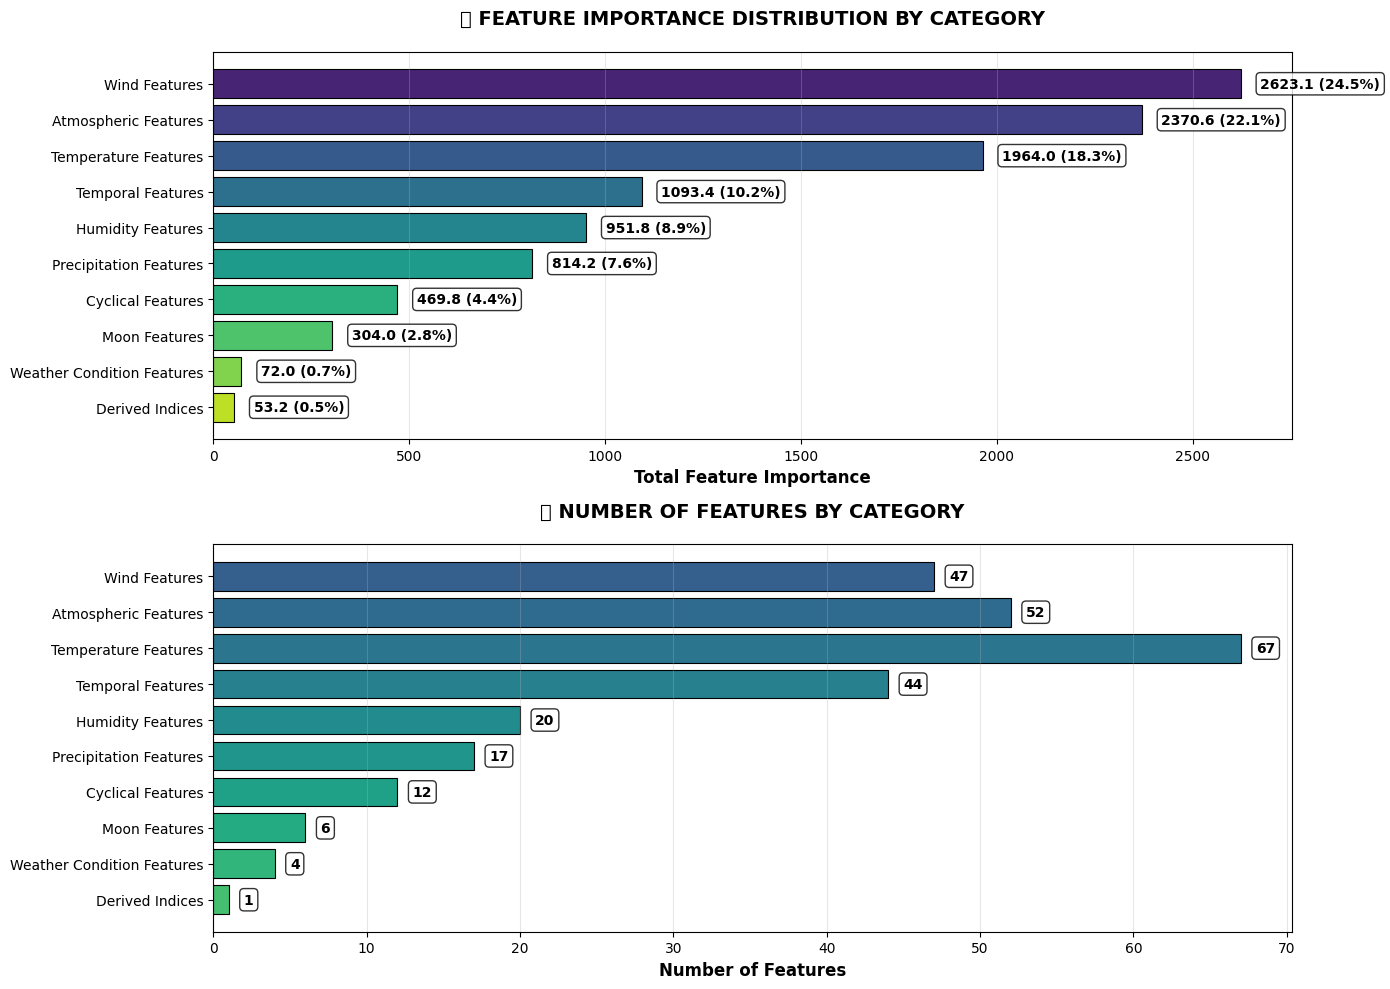

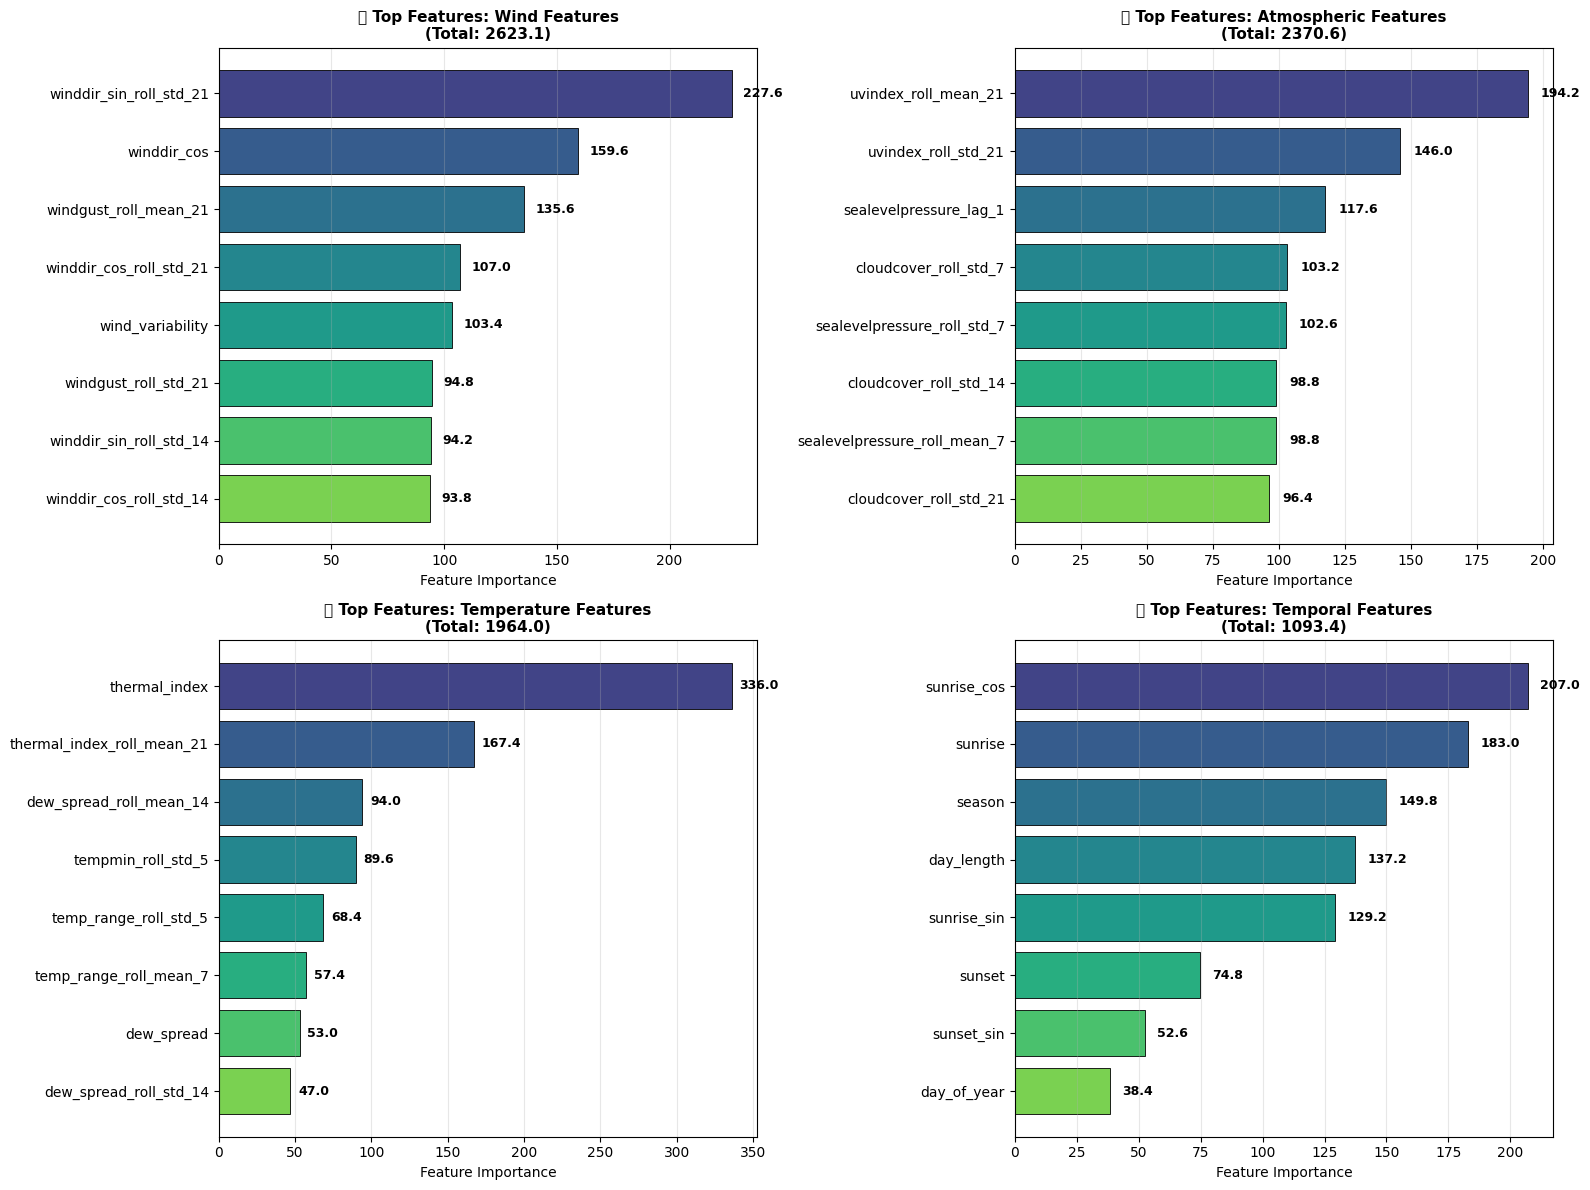

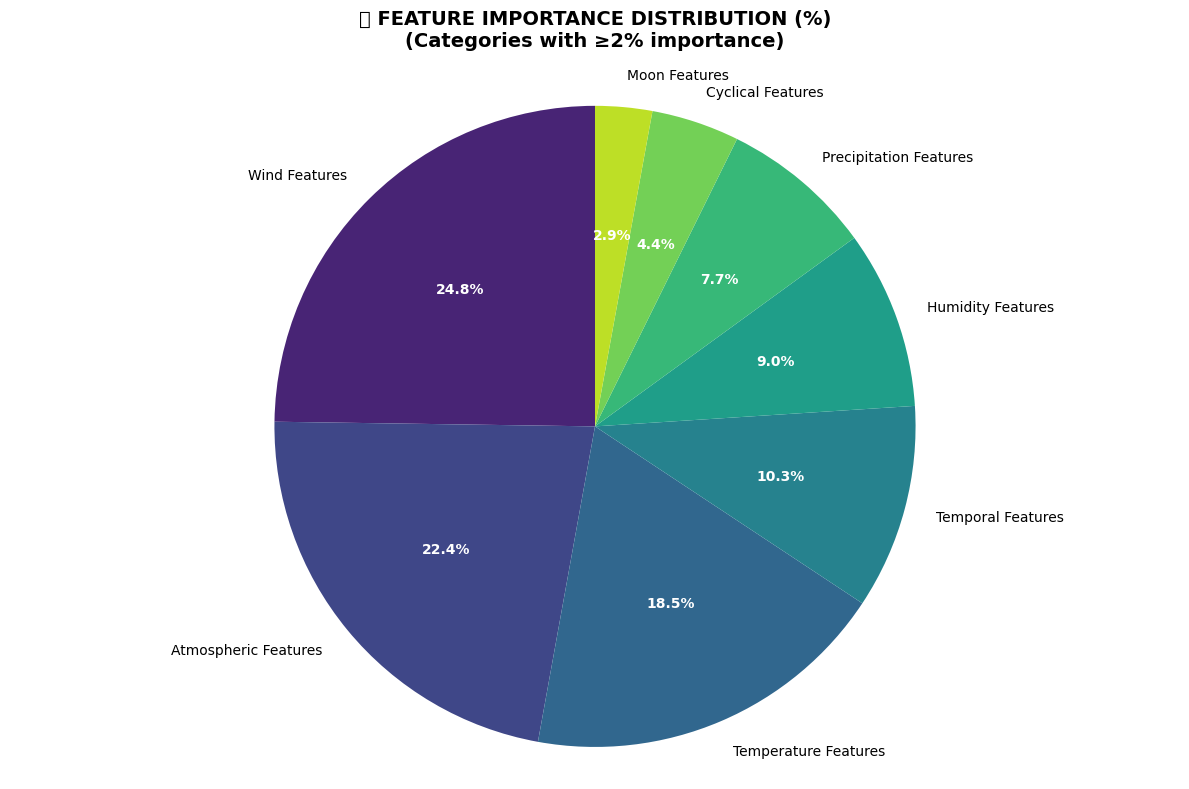


📊 TỔNG QUAN THỐNG KÊ:
Tổng Feature Importance: 10716.1
Tổng số Features: 270
Số lượng Categories: 10
Category quan trọng nhất: Wind Features (24.5%)
Category có nhiều features nhất: Temperature Features
Category có ít features nhất: Derived Indices


In [25]:
# Dữ liệu từ kết quả của bạn
category_data = {
    'Wind Features': 2623.1000,
    'Atmospheric Features': 2370.6000,
    'Temperature Features': 1964.0000,
    'Temporal Features': 1093.4000,
    'Humidity Features': 951.8000,
    'Precipitation Features': 814.2000,
    'Cyclical Features': 469.8000,
    'Moon Features': 304.0000,
    'Weather Condition Features': 72.0333,
    'Derived Indices': 53.2000
}

# Dữ liệu chi tiết từng category
category_details = {
    'Wind Features': {
        'total_features': 47,
        'top_features': [
            ('winddir_sin_roll_std_21', 227.6),
            ('winddir_cos', 159.6),
            ('windgust_roll_mean_21', 135.6),
            ('winddir_cos_roll_std_21', 107.0),
            ('wind_variability', 103.4),
            ('windgust_roll_std_21', 94.8),
            ('winddir_sin_roll_std_14', 94.2),
            ('winddir_cos_roll_std_14', 93.8),
            ('winddir_sin_roll_std_7', 87.4),
            ('winddir_cos_roll_std_7', 81.2)
        ]
    },
    'Atmospheric Features': {
        'total_features': 52,
        'top_features': [
            ('uvindex_roll_mean_21', 194.2),
            ('uvindex_roll_std_21', 146.0),
            ('sealevelpressure_lag_1', 117.6),
            ('cloudcover_roll_std_7', 103.2),
            ('sealevelpressure_roll_std_7', 102.6),
            ('cloudcover_roll_std_14', 98.8),
            ('sealevelpressure_roll_mean_7', 98.8),
            ('cloudcover_roll_std_21', 96.4),
            ('sealevelpressure_roll_mean_5', 95.6),
            ('solar_visibility_index', 87.0)
        ]
    },
    'Temperature Features': {
        'total_features': 67,
        'top_features': [
            ('thermal_index', 336.0),
            ('thermal_index_roll_mean_21', 167.4),
            ('dew_spread_roll_mean_14', 94.0),
            ('tempmin_roll_std_5', 89.6),
            ('temp_range_roll_std_5', 68.4),
            ('temp_range_roll_mean_7', 57.4),
            ('dew_spread', 53.0),
            ('dew_spread_roll_std_14', 47.0),
            ('temp_roll_std_5', 46.0),
            ('temp_range_roll_std_7', 44.4)
        ]
    },
    'Temporal Features': {
        'total_features': 44,
        'top_features': [
            ('sunrise_cos', 207.0),
            ('sunrise', 183.0),
            ('season', 149.8),
            ('day_length', 137.2),
            ('sunrise_sin', 129.2),
            ('sunset', 74.8),
            ('sunset_sin', 52.6),
            ('day_of_year', 38.4),
            ('sunset_cos', 24.8),
            ('day_of_year_h1', 17.2)
        ]
    },
    'Humidity Features': {
        'total_features': 20,
        'top_features': [
            ('dew_roll_std_14', 112.8),
            ('vis_humidity_index', 109.2),
            ('dew_roll_mean_21', 98.6),
            ('dew_roll_mean_14', 86.4),
            ('dew_roll_std_21', 80.8),
            ('humidity_roll_std_14', 74.0),
            ('humidity_roll_mean_14', 66.4),
            ('dew_roll_std_7', 51.2),
            ('humidity_roll_std_7', 39.0),
            ('dew_roll_mean_7', 31.6)
        ]
    },
    'Precipitation Features': {
        'total_features': 17,
        'top_features': [
            ('precip_roll_mean_21', 122.8),
            ('precip_roll_mean_14', 110.0),
            ('rain_intensity_roll_mean_5', 78.8),
            ('precip_roll_mean_7', 73.6),
            ('precip_roll_std_21', 71.0),
            ('precip_roll_std_14', 65.0),
            ('precip_roll_std_7', 50.4),
            ('rain_intensity', 39.8),
            ('rain_intensity_roll_mean_3', 38.0),
            ('precip_roll_sum_14', 34.4)
        ]
    },
    'Cyclical Features': {
        'total_features': 12,
        'top_features': [
            ('day_cos', 113.6),
            ('day_cos_h5', 79.8),
            ('day_cos_h1', 55.2),
            ('day_cos_h4', 53.0),
            ('day_sin', 52.0),
            ('day_cos_h3', 39.6),
            ('day_cos_h2', 38.0),
            ('day_sin_h1', 15.8),
            ('day_sin_h2', 7.2),
            ('day_sin_h5', 6.0)
        ]
    },
    'Moon Features': {
        'total_features': 6,
        'top_features': [
            ('moonphase_roll_std_7', 108.2),
            ('moonphase_roll_mean_7', 65.2),
            ('moonphase_lag_14', 38.6),
            ('moonphase_lag_7', 34.6),
            ('moonphase_cos', 34.4),
            ('moonphase_sin', 23.0)
        ]
    },
    'Weather Condition Features': {
        'total_features': 4,
        'top_features': [
            ('moisture_index', 68.2),
            ('numeric_conditions', 3.33),
            ('conditions', 0.5),
            ('humid_foggy_day', 0.0)
        ]
    },
    'Derived Indices': {
        'total_features': 1,
        'top_features': [
            ('uv_cloud_index', 53.2)
        ]
    }
}

# ===== BIỂU ĐỒ 1: Phân bố Feature Importance theo Category =====
plt.figure(figsize=(14, 10))

# Tính phần trăm
total_importance = sum(category_data.values())
categories = list(category_data.keys())
values = list(category_data.values())
percentages = [(v / total_importance) * 100 for v in values]

# Sắp xếp theo giá trị giảm dần
sorted_indices = np.argsort(values)[::-1]
categories_sorted = [categories[i] for i in sorted_indices]
values_sorted = [values[i] for i in sorted_indices]
percentages_sorted = [percentages[i] for i in sorted_indices]

# SỬA MÀU: Dùng viridis giống biểu đồ 3
colors_viridis = plt.cm.viridis(np.linspace(0.1, 0.9, len(categories_sorted)))

# Biểu đồ cột ngang
plt.subplot(2, 1, 1)
bars = plt.barh(categories_sorted, values_sorted, color=colors_viridis, edgecolor='black', linewidth=0.8)
plt.xlabel('Total Feature Importance', fontsize=12, fontweight='bold')
plt.title('📊 FEATURE IMPORTANCE DISTRIBUTION BY CATEGORY', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Thêm giá trị và phần trăm trên mỗi bar
for i, (value, percentage) in enumerate(zip(values_sorted, percentages_sorted)):
    plt.text(value + 50, i, f'{value:.1f} ({percentage:.1f}%)', 
             va='center', fontweight='bold', fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.gca().invert_yaxis()

# ===== BIỂU ĐỒ 2: Số lượng Features theo Category =====
plt.subplot(2, 1, 2)

# SỬA MÀU: Dùng viridis nhưng với range khác để tạo sự tương phản
colors_viridis_count = plt.cm.viridis(np.linspace(0.3, 0.7, len(categories_sorted)))

feature_counts = [category_details[cat]['total_features'] for cat in categories_sorted]

bars_count = plt.barh(categories_sorted, feature_counts, color=colors_viridis_count, edgecolor='black', linewidth=0.8)
plt.xlabel('Number of Features', fontsize=12, fontweight='bold')
plt.title('🔢 NUMBER OF FEATURES BY CATEGORY', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Thêm số lượng features trên mỗi bar
for i, count in enumerate(feature_counts):
    plt.text(count + 1, i, f'{count}', 
             va='center', fontweight='bold', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===== BIỂU ĐỒ 3: Top Features trong mỗi Category (4 categories quan trọng nhất) =====
top_4_categories = categories_sorted[:4]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, category in enumerate(top_4_categories):
    if idx < len(axes):
        features = [f[0] for f in category_details[category]['top_features'][:8]]  # Top 8 features
        importances = [f[1] for f in category_details[category]['top_features'][:8]]
        
        # GIỮ NGUYÊN MÀU VIRIDIS CỦA BIỂU ĐỒ 3
        colors_feature = plt.cm.viridis(np.linspace(0.2, 0.8, len(features)))
        
        axes[idx].barh(features, importances, color=colors_feature, edgecolor='black', linewidth=0.6)
        axes[idx].set_xlabel('Feature Importance')
        axes[idx].set_title(f'🏆 Top Features: {category}\n(Total: {category_data[category]:.1f})', 
                           fontweight='bold', fontsize=11)
        axes[idx].grid(True, alpha=0.3, axis='x')
        axes[idx].invert_yaxis()
        
        # Thêm giá trị trên mỗi bar
        for i, value in enumerate(importances):
            axes[idx].text(value + 5, i, f'{value:.1f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# ===== BIỂU ĐỒ 4: Pie chart tỷ lệ phần trăm =====
plt.figure(figsize=(12, 8))

# Chỉ hiển thị các category có tỷ lệ > 2%
significant_categories = []
significant_values = []
significant_percentages = []

for cat, val, pct in zip(categories_sorted, values_sorted, percentages_sorted):
    if pct >= 2:  # Chỉ hiển thị category có >= 2%
        significant_categories.append(cat)
        significant_values.append(val)
        significant_percentages.append(pct)

# SỬA MÀU: Dùng viridis cho pie chart
colors_viridis_pie = plt.cm.viridis(np.linspace(0.1, 0.9, len(significant_categories)))

# Tạo pie chart
wedges, texts, autotexts = plt.pie(significant_values, labels=significant_categories, 
                                   autopct='%1.1f%%', startangle=90,
                                   colors=colors_viridis_pie,
                                   textprops={'fontsize': 10})

# Làm đậm phần trăm
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title('📈 FEATURE IMPORTANCE DISTRIBUTION (%)\n(Categories with ≥2% importance)', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

# ===== THỐNG KÊ TỔNG QUAN =====
print(f"\n📊 TỔNG QUAN THỐNG KÊ:")
print("=" * 50)
print(f"Tổng Feature Importance: {total_importance:.1f}")
print(f"Tổng số Features: {sum([details['total_features'] for details in category_details.values()])}")
print(f"Số lượng Categories: {len(category_data)}")
print(f"Category quan trọng nhất: {categories_sorted[0]} ({percentages_sorted[0]:.1f}%)")
print(f"Category có nhiều features nhất: {max(category_details.items(), key=lambda x: x[1]['total_features'])[0]}")
print(f"Category có ít features nhất: {min(category_details.items(), key=lambda x: x[1]['total_features'])[0]}")

### **3.3. Result Analysis** 

*   `The hyperparameter tuning process significantly improved performance compared to the baseline model. The best model (Tuning #5) achieved an average test RMSE of 2.182 (more precisely 2.1816), a substantial reduction from the baseline's RMSE of 2.399. This improvement is also reflected in the R² score, which increased from 0.756 (Baseline) to 0.816 (Tuning #5) (more precisely 0.8158). This indicates the tuned model explains a significantly larger portion of the data's variance.`

*   `Based on the Optuna plot_param_importances charts generated for each target (e.g., for temp_next_1, temp_next_3, temp_next_4, etc.), the most critical hyperparameters were consistently boosting_type and learning_rate. num_leaves and n_estimators also frequently showed a significant impact on performance. The feature encoding parameters, such as encoding_method_condition and the is_category flags, generally had a lower importance ranking, though they were still relevant.`

*   `An interesting finding from the experiment summary (Table 3.1) is that running 100 trials without a pruner (Tuning #5, RMSE 2.182) outperformed 100 trials with a pruner (Tuning #4, RMSE 2.206). This suggests the pruner may have prematurely terminated some promising trials. Furthermore, the optimization process confirmed the value of tuning models independently for each target, as it selected different optimal boosting_type values (gbdt and goss) for different forecast horizons (e.g., temp_next_1 vs temp_next_3).`

## **4. Conclusion**

* `Successfully developed a LightGBM model for temperature forecasting. The process involved comprehensive data preparation, feature engineering (creating lag and rolling features), and categorical encoding. A baseline model using default LGBM parameters established an initial test RMSE of 2.399. By employing Bayesian optimization with Optuna's TPESampler over 100 trials, we independently tuned models for each of the 5 forecast days. This tuning process led to the selection of "Tuning #5," which significantly improved performance, achieving a final average test RMSE of 2.182 and an R² of 0.816.`